In [278]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import median_absolute_error, mean_squared_error

#KERAS MODEL DEFINITION
from keras.layers import Input, Dropout, Dense,Bidirectional, LSTM, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization, GlobalMaxPool1D, Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
import collections

In [298]:
import requests
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

def get_values_not_in_first(arr1, arr2):
    values = []
    for val in arr2:
        if val not in arr1:
            values.append(val)
    return values

def make_api_call_get_json(url):
    try:
        req = requests.get(url)
        if req.status_code == 200:
            return req.json()
    except Exception as e:
        print('Error occured : ', str(e))
    print('Request was not successful : ', req)
    return 

def combine_train_test_set(train, test, target='target'):
    train = train[pd.notnull(train[target])]
    test[target] = np.nan
    return pd.concat([train, test[train.columns.tolist()]])
    
def split_train_test_set(combine, target='target'):
    train = combine[combine[target].notnull()]
    test = combine[combine[target].isnull()]
    return train, test

def train_model(model, X_train, y_train, X_test, y_test):
    model.fit( X_train, y_train)
    predictions = model.predict(X_test)
    print("RMSE on test data: "+ str(rmse_error(predictions, y_test)))
    return model

def rmse_error(predictions, y_test):
    return np.sqrt(mean_squared_error(predictions, y_test))


def plot_keras():
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def target_encoding(data, cols, y_label, smoothing=False, smooth_val = 10):
    ce_target = ce.TargetEncoder(cols = cols, smoothing = smooth_val) if smoothing else ce.TargetEncoder(cols = cols)
    fit_data = data[data[y_label].notnull()]
    y = fit_data[y_label]
    ce_target.fit(fit_data, y)
    return ce_target.transform(data)

# demonstrate data normalization with sklearn

def min_max_normalise(data, cols = None):
    data = data.copy()
    scalers = {}
    if cols == None:
        cols = data.columns
    for col in cols:
        print(col)
        if data[col].dtype == 'object': continue
        scaler = MinMaxScaler()
        scalers[col] = scaler
        scaler.fit(data[col])
        data[col] = scaler.transform(data[col])
#         scaler.inverse_transform(normalized)
    return scalers

def quantile_transformer(data, cols=None):
    data = data.copy()
    scalers = {}
    if cols == None:
        cols = data.columns
    for col in cols:
        if data[col].dtype == 'object': continue
        scaler = QuantileTransformer()
        scalers[col] = scaler
        scaler.fit(data[col])
        data[col] = scaler.transform(data[col])
    return scalers
    

In [299]:
from datetime import timedelta

def convert_time_str(time):
    time_parts = time.split(' ')
    comps = time_parts[0].split(':')
    comps = list(map(int, comps))
    if time_parts[1].lower() == 'pm' and comps[0] != 12:
        comps[0] += 12
    elif time_parts[1].lower() == 'am' and comps[0] == 12:
        comps[0] = 0
    return np.array(comps)

def convert_time_str_hours(time):
    return convert_time_str(time)[0]

def convert_time_str_minutes(time):
    return convert_time_str(time)[1]

def convert_time_str_seconds(time):
    return convert_time_str(time)[2]
    
def combine_data_with_riders(data, riders):
    data = data.copy()
    riders = riders.set_index('Rider Id')
    for col in riders.columns:
        data['Riders ' + col] = data['Rider Id'].apply(lambda r: riders[col].loc[r])
    return data

def to_timedelta(t):
    t = convert_time_str(t)
    t = timedelta(hours=t[0], minutes=t[1], seconds=t[2])
    return t

def time_difference(t1, t2):
    t1 = t1.apply(to_timedelta)
    t2 = t2.apply(to_timedelta)
    return (t2 - t1).apply(lambda t: t.seconds)

def sphere_dist_bear(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

def radian_conv(degree):
    """
    Return radian.
    """
    return np.radians(degree) 

# time_difference(combine_set['Placement - Time'], combine_set['Confirmation - Time'])

In [300]:
def add_bearing_features(data):
    data['bearing'] = sphere_dist_bear(data['Pickup Lat'], data['Pickup Long'], 
                                   data['Destination Lat'] , data['Destination Long'])

def drop_date_info(data):
    return data.drop(columns=['Placement - Day of Month', 'Placement - Weekday (Mo = 1)', 
                       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)'])

def delete_passive_outliers(data):
    data = data[(data['Placement - Weekday (Mo = 1)'] == data['Confirmation - Weekday (Mo = 1)']) 
                | data['Time from Pickup to Arrival'].isna()]
    data = data[(data['Distance (KM)'] < 30) | data['Time from Pickup to Arrival'].isna()]
    data = data[(data['Time from Pickup to Arrival'] > 5000) | data['Time from Pickup to Arrival'].isna()]
    return data

def drop_time_variables(data):
    return data.drop(columns=time_variables)

def change_time_variables(data, cols=time_variables):
    for col in cols:
        data[col + ' hours'] = data[col].apply(convert_time_str_hours) 
        data[col + ' minutes'] = data[col].apply(convert_time_str_minutes) 
        data[col + ' seconds'] = data[col].apply(convert_time_str_seconds)
    return data
        
def convert_to_randians(data, 
                        cols=['Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long'], 
                        only_temp=False):
    data = data.copy()
    if not only_temp:
        for col in cols:
            data[col] = radian_conv(data[col])
    return data
        
def add_time_diff(data):
    data = data.copy()
    for i in range(len(time_variables)-1):
        col1 = time_variables[i]
        for j in range(i+1, len(time_variables)):
            col2 = time_variables[j]
            data[ col2 + ' - ' + col1] = time_difference(data[col2], data[col1])
    return data

def encode_platform_and_pb(data):
    data = data.drop(columns=columns_not_considers)
    data['Personal or Business'] = pd.Categorical(data['Personal or Business']).codes
    platform_encode = pd.get_dummies(data['Platform Type'])
    for col in platform_encode.columns:
        data['Platform_' + str(col)] = platform_encode[col]
    data = data.drop(columns=['Platform Type'])
    return data

def fillna_temp(data):
    data = data.copy()
    data['Temperature'] = data['Temperature'].fillna(-1)
    return data

def pipeline(data, pipes):
    for action in pipes:
        data = action(data)
    return data

def get_xgb_importnace_features(model):
    features_impotance = model.get_booster().get_score(importance_type='gain')
    return collections.OrderedDict(sorted(features_impotance.items(), 
                                                        key=lambda kv: kv[1], reverse=True)).keys()

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 40))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

In [302]:
# Load data
train_set = pd.read_csv('data/Train.csv')
test_set = pd.read_csv('data/Test.csv')
riders = pd.read_csv('data/Riders.csv')
# variables_info = pd.read_csv('data/VariableDefinitions.csv')

In [303]:
y_label = 'Time from Pickup to Arrival'
columns_not_considers = ['User Id', 'User Id', 'Vehicle Type', 'Precipitation in millimeters', 'Rider Id']
time_variables = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time']

In [304]:
passive_important_features = ['Distance (KM)', 'Riders No_Of_Orders', 'Riders Average_Rating', 'Riders Age', 
                              'Destination Lat', 'Pickup Lat', 'Riders No_of_Ratings', 
                              'Arrival at Pickup - Time hours',  'Destination Long', 'Pickup Long', 
                              'Arrival at Pickup - Weekday (Mo = 1)']

cat_variables = [ 
                 'Arrival at Pickup - Day of Month', 'Arrival at Pickup - Weekday (Mo = 1)', 
                 'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)'
                 , 'Placement - Time hours', 'Confirmation - Time hours'
                 , 'Arrival at Pickup - Time hours', 'Pickup - Time hours'
                ]

In [305]:
train_set.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [306]:
test_set.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,...,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,...,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [307]:
columns_not_in_test = get_values_not_in_first(test_set.columns, train_set.columns)
columns_not_in_test

['Arrival at Destination - Day of Month',
 'Arrival at Destination - Weekday (Mo = 1)',
 'Arrival at Destination - Time',
 'Time from Pickup to Arrival']

In [308]:
train_common = train_set.drop(columns=columns_not_in_test[:-1])
train_common.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:27:30 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,11:44:09 AM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,12:53:03 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,9:43:06 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:05:23 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [316]:
combine_data = combine_train_test_set(train_common, test_set,y_label)
combine_data.columns

Index([u'Order No', u'User Id', u'Vehicle Type', u'Platform Type',
       u'Personal or Business', u'Placement - Day of Month',
       u'Placement - Weekday (Mo = 1)', u'Placement - Time',
       u'Confirmation - Day of Month', u'Confirmation - Weekday (Mo = 1)',
       u'Confirmation - Time', u'Arrival at Pickup - Day of Month',
       u'Arrival at Pickup - Weekday (Mo = 1)', u'Arrival at Pickup - Time',
       u'Pickup - Day of Month', u'Pickup - Weekday (Mo = 1)',
       u'Pickup - Time', u'Distance (KM)', u'Temperature',
       u'Precipitation in millimeters', u'Pickup Lat', u'Pickup Long',
       u'Destination Lat', u'Destination Long', u'Rider Id',
       u'Time from Pickup to Arrival'],
      dtype='object')

In [365]:
combined_with_riders = combine_data_with_riders(combine_data, riders)
combined_with_riders = change_time_variables(combined_with_riders)
combined_with_riders = combined_with_riders[['Order No', y_label] + passive_important_features]
combined_with_riders.head()

,Order No,Time from Pickup to Arrival,Distance (KM),Riders No_Of_Orders,Riders Average_Rating,Riders Age,Destination Lat,Pickup Lat,Riders No_of_Ratings,Arrival at Pickup - Time hours,Destination Long,Pickup Long,Arrival at Pickup - Weekday (Mo = 1)
0,Order_No_4211,745.0,4,1637,13.8,1309,-1.300406,-1.317755,549,10,36.829741,36.830370,5
1,Order_No_25375,1993.0,16,396,13.6,339,-1.295004,-1.351453,69,11,36.814358,36.899315,5
2,Order_No_1899,455.0,3,1023,12.5,242,-1.300921,-1.308284,114,12,36.828195,36.843419,2
3,Order_No_9336,1341.0,9,886,14.5,283,-1.257147,-1.281301,113,9,36.795063,36.832396,5
4,Order_No_27883,1214.0,9,2311,14.1,872,-1.295041,-1.266597,533,10,36.809817,36.792118,1


In [366]:
combined_with_riders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28269 entries, 0 to 7067
Data columns (total 13 columns):
Order No                                28269 non-null object
Time from Pickup to Arrival             21201 non-null float64
Distance (KM)                           28269 non-null int64
Riders No_Of_Orders                     28269 non-null int64
Riders Average_Rating                   28269 non-null float64
Riders Age                              28269 non-null int64
Destination Lat                         28269 non-null float64
Pickup Lat                              28269 non-null float64
Riders No_of_Ratings                    28269 non-null int64
Arrival at Pickup - Time hours          28269 non-null int64
Destination Long                        28269 non-null float64
Pickup Long                             28269 non-null float64
Arrival at Pickup - Weekday (Mo = 1)    28269 non-null int64
dtypes: float64(6), int64(6), object(1)
memory usage: 3.0+ MB


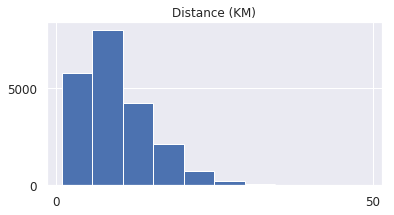

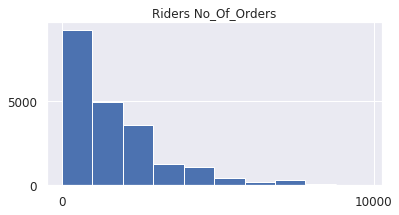

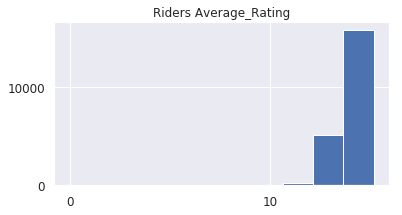

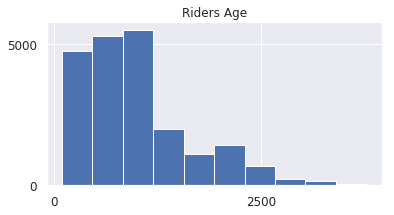

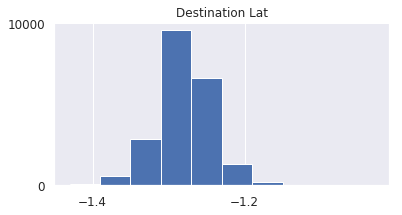

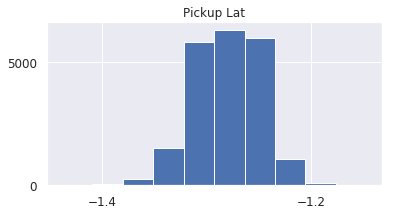

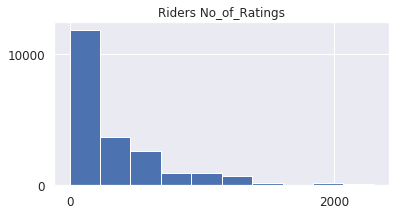

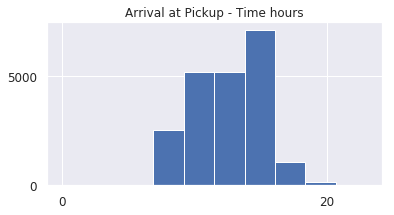

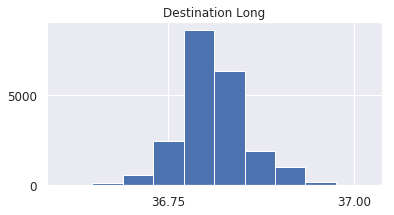

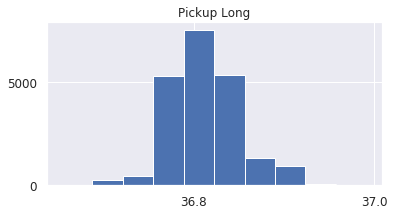

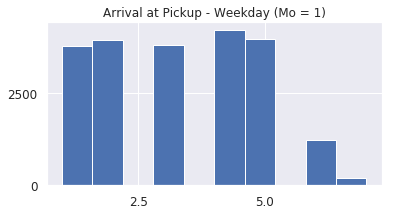

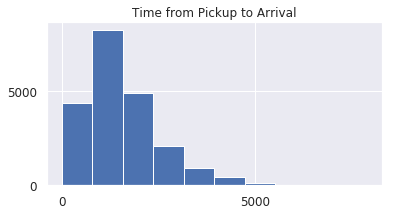

In [359]:
# combined_with_riders[passive_important_features[:4]].hist(bins=30)
# import matplotlib
# matplotlib.rcParams.update({'font.size': 12})
for col in combined_with_riders.columns:
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.hist(combined_with_riders[col][combined_with_riders[y_label].notnull()])
    ax.set_title(col)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

In [367]:
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from xgboost import XGBRegressor

In [368]:
train, test = split_train_test_set(combined_with_riders, y_label)

In [369]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=[y_label, 'Order No']), train[y_label])

In [370]:
test = test.drop(columns=[y_label])

In [371]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.001,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
    
train_set = lgbm.Dataset(X_train, y_train, silent=False)
valid_set = lgbm.Dataset(X_test, y_test, silent=False)
model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500, valid_sets=valid_set)

[1]	valid_0's rmse: 996.234
Training until validation scores don't improve for 500 rounds
[2]	valid_0's rmse: 995.868
[3]	valid_0's rmse: 995.502
[4]	valid_0's rmse: 995.131
[5]	valid_0's rmse: 994.77
[6]	valid_0's rmse: 994.405
[7]	valid_0's rmse: 994.035
[8]	valid_0's rmse: 993.793
[9]	valid_0's rmse: 993.428
[10]	valid_0's rmse: 993.067
[11]	valid_0's rmse: 992.701
[12]	valid_0's rmse: 992.343
[13]	valid_0's rmse: 991.98
[14]	valid_0's rmse: 991.624
[15]	valid_0's rmse: 991.385
[16]	valid_0's rmse: 991.13
[17]	valid_0's rmse: 990.77
[18]	valid_0's rmse: 990.409
[19]	valid_0's rmse: 990.052
[20]	valid_0's rmse: 989.781
[21]	valid_0's rmse: 989.426
[22]	valid_0's rmse: 989.239
[23]	valid_0's rmse: 988.882
[24]	valid_0's rmse: 988.529
[25]	valid_0's rmse: 988.391
[26]	valid_0's rmse: 988.034
[27]	valid_0's rmse: 987.677
[28]	valid_0's rmse: 987.321
[29]	valid_0's rmse: 986.968
[30]	valid_0's rmse: 986.61
[31]	valid_0's rmse: 986.341
[32]	valid_0's rmse: 986.134
[33]	valid_0's rmse: 986

[322]	valid_0's rmse: 914.424
[323]	valid_0's rmse: 914.186
[324]	valid_0's rmse: 913.95
[325]	valid_0's rmse: 913.789
[326]	valid_0's rmse: 913.556
[327]	valid_0's rmse: 913.403
[328]	valid_0's rmse: 913.175
[329]	valid_0's rmse: 912.938
[330]	valid_0's rmse: 912.786
[331]	valid_0's rmse: 912.545
[332]	valid_0's rmse: 912.31
[333]	valid_0's rmse: 912.071
[334]	valid_0's rmse: 911.974
[335]	valid_0's rmse: 911.735
[336]	valid_0's rmse: 911.614
[337]	valid_0's rmse: 911.517
[338]	valid_0's rmse: 911.29
[339]	valid_0's rmse: 911.223
[340]	valid_0's rmse: 910.994
[341]	valid_0's rmse: 910.762
[342]	valid_0's rmse: 910.613
[343]	valid_0's rmse: 910.381
[344]	valid_0's rmse: 910.223
[345]	valid_0's rmse: 910.077
[346]	valid_0's rmse: 909.85
[347]	valid_0's rmse: 909.619
[348]	valid_0's rmse: 909.388
[349]	valid_0's rmse: 909.154
[350]	valid_0's rmse: 908.979
[351]	valid_0's rmse: 908.752
[352]	valid_0's rmse: 908.527
[353]	valid_0's rmse: 908.302
[354]	valid_0's rmse: 908.16
[355]	valid_0's

[649]	valid_0's rmse: 860.729
[650]	valid_0's rmse: 860.582
[651]	valid_0's rmse: 860.469
[652]	valid_0's rmse: 860.316
[653]	valid_0's rmse: 860.163
[654]	valid_0's rmse: 860.01
[655]	valid_0's rmse: 859.854
[656]	valid_0's rmse: 859.746
[657]	valid_0's rmse: 859.638
[658]	valid_0's rmse: 859.494
[659]	valid_0's rmse: 859.343
[660]	valid_0's rmse: 859.195
[661]	valid_0's rmse: 859.048
[662]	valid_0's rmse: 858.898
[663]	valid_0's rmse: 858.75
[664]	valid_0's rmse: 858.602
[665]	valid_0's rmse: 858.513
[666]	valid_0's rmse: 858.427
[667]	valid_0's rmse: 858.285
[668]	valid_0's rmse: 858.137
[669]	valid_0's rmse: 858.048
[670]	valid_0's rmse: 857.986
[671]	valid_0's rmse: 857.839
[672]	valid_0's rmse: 857.686
[673]	valid_0's rmse: 857.54
[674]	valid_0's rmse: 857.44
[675]	valid_0's rmse: 857.341
[676]	valid_0's rmse: 857.2
[677]	valid_0's rmse: 857.141
[678]	valid_0's rmse: 856.996
[679]	valid_0's rmse: 856.855
[680]	valid_0's rmse: 856.712
[681]	valid_0's rmse: 856.65
[682]	valid_0's r

[947]	valid_0's rmse: 829.084
[948]	valid_0's rmse: 828.987
[949]	valid_0's rmse: 828.885
[950]	valid_0's rmse: 828.789
[951]	valid_0's rmse: 828.728
[952]	valid_0's rmse: 828.685
[953]	valid_0's rmse: 828.633
[954]	valid_0's rmse: 828.542
[955]	valid_0's rmse: 828.475
[956]	valid_0's rmse: 828.401
[957]	valid_0's rmse: 828.299
[958]	valid_0's rmse: 828.196
[959]	valid_0's rmse: 828.132
[960]	valid_0's rmse: 828.036
[961]	valid_0's rmse: 827.94
[962]	valid_0's rmse: 827.868
[963]	valid_0's rmse: 827.767
[964]	valid_0's rmse: 827.695
[965]	valid_0's rmse: 827.603
[966]	valid_0's rmse: 827.535
[967]	valid_0's rmse: 827.436
[968]	valid_0's rmse: 827.341
[969]	valid_0's rmse: 827.241
[970]	valid_0's rmse: 827.146
[971]	valid_0's rmse: 827.082
[972]	valid_0's rmse: 827.01
[973]	valid_0's rmse: 826.915
[974]	valid_0's rmse: 826.818
[975]	valid_0's rmse: 826.752
[976]	valid_0's rmse: 826.659
[977]	valid_0's rmse: 826.588
[978]	valid_0's rmse: 826.495
[979]	valid_0's rmse: 826.399
[980]	valid_

[1215]	valid_0's rmse: 809.847
[1216]	valid_0's rmse: 809.814
[1217]	valid_0's rmse: 809.761
[1218]	valid_0's rmse: 809.695
[1219]	valid_0's rmse: 809.622
[1220]	valid_0's rmse: 809.554
[1221]	valid_0's rmse: 809.528
[1222]	valid_0's rmse: 809.479
[1223]	valid_0's rmse: 809.411
[1224]	valid_0's rmse: 809.345
[1225]	valid_0's rmse: 809.3
[1226]	valid_0's rmse: 809.229
[1227]	valid_0's rmse: 809.162
[1228]	valid_0's rmse: 809.115
[1229]	valid_0's rmse: 809.045
[1230]	valid_0's rmse: 809.002
[1231]	valid_0's rmse: 808.935
[1232]	valid_0's rmse: 808.907
[1233]	valid_0's rmse: 808.86
[1234]	valid_0's rmse: 808.79
[1235]	valid_0's rmse: 808.722
[1236]	valid_0's rmse: 808.676
[1237]	valid_0's rmse: 808.611
[1238]	valid_0's rmse: 808.544
[1239]	valid_0's rmse: 808.478
[1240]	valid_0's rmse: 808.408
[1241]	valid_0's rmse: 808.339
[1242]	valid_0's rmse: 808.269
[1243]	valid_0's rmse: 808.207
[1244]	valid_0's rmse: 808.182
[1245]	valid_0's rmse: 808.135
[1246]	valid_0's rmse: 808.064
[1247]	valid

[1532]	valid_0's rmse: 794.605
[1533]	valid_0's rmse: 794.586
[1534]	valid_0's rmse: 794.536
[1535]	valid_0's rmse: 794.489
[1536]	valid_0's rmse: 794.442
[1537]	valid_0's rmse: 794.395
[1538]	valid_0's rmse: 794.354
[1539]	valid_0's rmse: 794.305
[1540]	valid_0's rmse: 794.257
[1541]	valid_0's rmse: 794.209
[1542]	valid_0's rmse: 794.18
[1543]	valid_0's rmse: 794.151
[1544]	valid_0's rmse: 794.105
[1545]	valid_0's rmse: 794.056
[1546]	valid_0's rmse: 794.015
[1547]	valid_0's rmse: 793.963
[1548]	valid_0's rmse: 793.915
[1549]	valid_0's rmse: 793.869
[1550]	valid_0's rmse: 793.825
[1551]	valid_0's rmse: 793.779
[1552]	valid_0's rmse: 793.752
[1553]	valid_0's rmse: 793.719
[1554]	valid_0's rmse: 793.689
[1555]	valid_0's rmse: 793.659
[1556]	valid_0's rmse: 793.64
[1557]	valid_0's rmse: 793.593
[1558]	valid_0's rmse: 793.563
[1559]	valid_0's rmse: 793.534
[1560]	valid_0's rmse: 793.506
[1561]	valid_0's rmse: 793.463
[1562]	valid_0's rmse: 793.416
[1563]	valid_0's rmse: 793.369
[1564]	val

[1825]	valid_0's rmse: 784.501
[1826]	valid_0's rmse: 784.477
[1827]	valid_0's rmse: 784.451
[1828]	valid_0's rmse: 784.421
[1829]	valid_0's rmse: 784.388
[1830]	valid_0's rmse: 784.359
[1831]	valid_0's rmse: 784.327
[1832]	valid_0's rmse: 784.312
[1833]	valid_0's rmse: 784.286
[1834]	valid_0's rmse: 784.257
[1835]	valid_0's rmse: 784.222
[1836]	valid_0's rmse: 784.197
[1837]	valid_0's rmse: 784.18
[1838]	valid_0's rmse: 784.15
[1839]	valid_0's rmse: 784.117
[1840]	valid_0's rmse: 784.087
[1841]	valid_0's rmse: 784.065
[1842]	valid_0's rmse: 784.031
[1843]	valid_0's rmse: 784.014
[1844]	valid_0's rmse: 783.992
[1845]	valid_0's rmse: 783.957
[1846]	valid_0's rmse: 783.925
[1847]	valid_0's rmse: 783.906
[1848]	valid_0's rmse: 783.877
[1849]	valid_0's rmse: 783.844
[1850]	valid_0's rmse: 783.813
[1851]	valid_0's rmse: 783.792
[1852]	valid_0's rmse: 783.775
[1853]	valid_0's rmse: 783.747
[1854]	valid_0's rmse: 783.721
[1855]	valid_0's rmse: 783.692
[1856]	valid_0's rmse: 783.659
[1857]	val

[2103]	valid_0's rmse: 777.764
[2104]	valid_0's rmse: 777.737
[2105]	valid_0's rmse: 777.711
[2106]	valid_0's rmse: 777.689
[2107]	valid_0's rmse: 777.666
[2108]	valid_0's rmse: 777.653
[2109]	valid_0's rmse: 777.628
[2110]	valid_0's rmse: 777.603
[2111]	valid_0's rmse: 777.583
[2112]	valid_0's rmse: 777.565
[2113]	valid_0's rmse: 777.542
[2114]	valid_0's rmse: 777.523
[2115]	valid_0's rmse: 777.497
[2116]	valid_0's rmse: 777.476
[2117]	valid_0's rmse: 777.456
[2118]	valid_0's rmse: 777.433
[2119]	valid_0's rmse: 777.412
[2120]	valid_0's rmse: 777.39
[2121]	valid_0's rmse: 777.361
[2122]	valid_0's rmse: 777.348
[2123]	valid_0's rmse: 777.329
[2124]	valid_0's rmse: 777.312
[2125]	valid_0's rmse: 777.288
[2126]	valid_0's rmse: 777.268
[2127]	valid_0's rmse: 777.245
[2128]	valid_0's rmse: 777.227
[2129]	valid_0's rmse: 777.207
[2130]	valid_0's rmse: 777.182
[2131]	valid_0's rmse: 777.162
[2132]	valid_0's rmse: 777.145
[2133]	valid_0's rmse: 777.125
[2134]	valid_0's rmse: 777.104
[2135]	va

[2369]	valid_0's rmse: 772.684
[2370]	valid_0's rmse: 772.66
[2371]	valid_0's rmse: 772.641
[2372]	valid_0's rmse: 772.624
[2373]	valid_0's rmse: 772.604
[2374]	valid_0's rmse: 772.586
[2375]	valid_0's rmse: 772.566
[2376]	valid_0's rmse: 772.549
[2377]	valid_0's rmse: 772.531
[2378]	valid_0's rmse: 772.516
[2379]	valid_0's rmse: 772.5
[2380]	valid_0's rmse: 772.485
[2381]	valid_0's rmse: 772.462
[2382]	valid_0's rmse: 772.444
[2383]	valid_0's rmse: 772.424
[2384]	valid_0's rmse: 772.405
[2385]	valid_0's rmse: 772.383
[2386]	valid_0's rmse: 772.371
[2387]	valid_0's rmse: 772.354
[2388]	valid_0's rmse: 772.346
[2389]	valid_0's rmse: 772.325
[2390]	valid_0's rmse: 772.309
[2391]	valid_0's rmse: 772.293
[2392]	valid_0's rmse: 772.274
[2393]	valid_0's rmse: 772.257
[2394]	valid_0's rmse: 772.237
[2395]	valid_0's rmse: 772.217
[2396]	valid_0's rmse: 772.2
[2397]	valid_0's rmse: 772.185
[2398]	valid_0's rmse: 772.168
[2399]	valid_0's rmse: 772.151
[2400]	valid_0's rmse: 772.133
[2401]	valid_

[2690]	valid_0's rmse: 767.905
[2691]	valid_0's rmse: 767.888
[2692]	valid_0's rmse: 767.875
[2693]	valid_0's rmse: 767.861
[2694]	valid_0's rmse: 767.849
[2695]	valid_0's rmse: 767.837
[2696]	valid_0's rmse: 767.823
[2697]	valid_0's rmse: 767.808
[2698]	valid_0's rmse: 767.794
[2699]	valid_0's rmse: 767.781
[2700]	valid_0's rmse: 767.765
[2701]	valid_0's rmse: 767.755
[2702]	valid_0's rmse: 767.742
[2703]	valid_0's rmse: 767.73
[2704]	valid_0's rmse: 767.719
[2705]	valid_0's rmse: 767.708
[2706]	valid_0's rmse: 767.692
[2707]	valid_0's rmse: 767.679
[2708]	valid_0's rmse: 767.667
[2709]	valid_0's rmse: 767.652
[2710]	valid_0's rmse: 767.641
[2711]	valid_0's rmse: 767.631
[2712]	valid_0's rmse: 767.618
[2713]	valid_0's rmse: 767.605
[2714]	valid_0's rmse: 767.591
[2715]	valid_0's rmse: 767.58
[2716]	valid_0's rmse: 767.566
[2717]	valid_0's rmse: 767.551
[2718]	valid_0's rmse: 767.538
[2719]	valid_0's rmse: 767.524
[2720]	valid_0's rmse: 767.512
[2721]	valid_0's rmse: 767.499
[2722]	val

[2962]	valid_0's rmse: 764.736
[2963]	valid_0's rmse: 764.725
[2964]	valid_0's rmse: 764.717
[2965]	valid_0's rmse: 764.707
[2966]	valid_0's rmse: 764.696
[2967]	valid_0's rmse: 764.686
[2968]	valid_0's rmse: 764.675
[2969]	valid_0's rmse: 764.663
[2970]	valid_0's rmse: 764.649
[2971]	valid_0's rmse: 764.637
[2972]	valid_0's rmse: 764.629
[2973]	valid_0's rmse: 764.62
[2974]	valid_0's rmse: 764.604
[2975]	valid_0's rmse: 764.595
[2976]	valid_0's rmse: 764.582
[2977]	valid_0's rmse: 764.569
[2978]	valid_0's rmse: 764.555
[2979]	valid_0's rmse: 764.542
[2980]	valid_0's rmse: 764.534
[2981]	valid_0's rmse: 764.522
[2982]	valid_0's rmse: 764.51
[2983]	valid_0's rmse: 764.498
[2984]	valid_0's rmse: 764.489
[2985]	valid_0's rmse: 764.478
[2986]	valid_0's rmse: 764.467
[2987]	valid_0's rmse: 764.454
[2988]	valid_0's rmse: 764.439
[2989]	valid_0's rmse: 764.427
[2990]	valid_0's rmse: 764.414
[2991]	valid_0's rmse: 764.402
[2992]	valid_0's rmse: 764.39
[2993]	valid_0's rmse: 764.378
[2994]	vali

[3238]	valid_0's rmse: 762.001
[3239]	valid_0's rmse: 761.989
[3240]	valid_0's rmse: 761.982
[3241]	valid_0's rmse: 761.971
[3242]	valid_0's rmse: 761.964
[3243]	valid_0's rmse: 761.954
[3244]	valid_0's rmse: 761.943
[3245]	valid_0's rmse: 761.935
[3246]	valid_0's rmse: 761.924
[3247]	valid_0's rmse: 761.912
[3248]	valid_0's rmse: 761.9
[3249]	valid_0's rmse: 761.893
[3250]	valid_0's rmse: 761.88
[3251]	valid_0's rmse: 761.874
[3252]	valid_0's rmse: 761.868
[3253]	valid_0's rmse: 761.857
[3254]	valid_0's rmse: 761.846
[3255]	valid_0's rmse: 761.838
[3256]	valid_0's rmse: 761.828
[3257]	valid_0's rmse: 761.818
[3258]	valid_0's rmse: 761.812
[3259]	valid_0's rmse: 761.805
[3260]	valid_0's rmse: 761.794
[3261]	valid_0's rmse: 761.787
[3262]	valid_0's rmse: 761.78
[3263]	valid_0's rmse: 761.768
[3264]	valid_0's rmse: 761.764
[3265]	valid_0's rmse: 761.757
[3266]	valid_0's rmse: 761.745
[3267]	valid_0's rmse: 761.739
[3268]	valid_0's rmse: 761.729
[3269]	valid_0's rmse: 761.719
[3270]	valid

[3525]	valid_0's rmse: 759.703
[3526]	valid_0's rmse: 759.695
[3527]	valid_0's rmse: 759.687
[3528]	valid_0's rmse: 759.678
[3529]	valid_0's rmse: 759.672
[3530]	valid_0's rmse: 759.658
[3531]	valid_0's rmse: 759.652
[3532]	valid_0's rmse: 759.642
[3533]	valid_0's rmse: 759.633
[3534]	valid_0's rmse: 759.633
[3535]	valid_0's rmse: 759.628
[3536]	valid_0's rmse: 759.622
[3537]	valid_0's rmse: 759.615
[3538]	valid_0's rmse: 759.603
[3539]	valid_0's rmse: 759.594
[3540]	valid_0's rmse: 759.583
[3541]	valid_0's rmse: 759.58
[3542]	valid_0's rmse: 759.575
[3543]	valid_0's rmse: 759.568
[3544]	valid_0's rmse: 759.559
[3545]	valid_0's rmse: 759.555
[3546]	valid_0's rmse: 759.544
[3547]	valid_0's rmse: 759.534
[3548]	valid_0's rmse: 759.527
[3549]	valid_0's rmse: 759.523
[3550]	valid_0's rmse: 759.517
[3551]	valid_0's rmse: 759.506
[3552]	valid_0's rmse: 759.496
[3553]	valid_0's rmse: 759.485
[3554]	valid_0's rmse: 759.485
[3555]	valid_0's rmse: 759.476
[3556]	valid_0's rmse: 759.468
[3557]	va

[3812]	valid_0's rmse: 757.779
[3813]	valid_0's rmse: 757.767
[3814]	valid_0's rmse: 757.766
[3815]	valid_0's rmse: 757.761
[3816]	valid_0's rmse: 757.753
[3817]	valid_0's rmse: 757.749
[3818]	valid_0's rmse: 757.742
[3819]	valid_0's rmse: 757.734
[3820]	valid_0's rmse: 757.73
[3821]	valid_0's rmse: 757.726
[3822]	valid_0's rmse: 757.716
[3823]	valid_0's rmse: 757.71
[3824]	valid_0's rmse: 757.709
[3825]	valid_0's rmse: 757.704
[3826]	valid_0's rmse: 757.702
[3827]	valid_0's rmse: 757.696
[3828]	valid_0's rmse: 757.692
[3829]	valid_0's rmse: 757.685
[3830]	valid_0's rmse: 757.68
[3831]	valid_0's rmse: 757.674
[3832]	valid_0's rmse: 757.671
[3833]	valid_0's rmse: 757.662
[3834]	valid_0's rmse: 757.657
[3835]	valid_0's rmse: 757.65
[3836]	valid_0's rmse: 757.646
[3837]	valid_0's rmse: 757.639
[3838]	valid_0's rmse: 757.627
[3839]	valid_0's rmse: 757.623
[3840]	valid_0's rmse: 757.618
[3841]	valid_0's rmse: 757.612
[3842]	valid_0's rmse: 757.608
[3843]	valid_0's rmse: 757.603
[3844]	valid

[4109]	valid_0's rmse: 756.101
[4110]	valid_0's rmse: 756.096
[4111]	valid_0's rmse: 756.094
[4112]	valid_0's rmse: 756.09
[4113]	valid_0's rmse: 756.087
[4114]	valid_0's rmse: 756.083
[4115]	valid_0's rmse: 756.073
[4116]	valid_0's rmse: 756.065
[4117]	valid_0's rmse: 756.054
[4118]	valid_0's rmse: 756.049
[4119]	valid_0's rmse: 756.042
[4120]	valid_0's rmse: 756.036
[4121]	valid_0's rmse: 756.032
[4122]	valid_0's rmse: 756.027
[4123]	valid_0's rmse: 756.024
[4124]	valid_0's rmse: 756.02
[4125]	valid_0's rmse: 756.017
[4126]	valid_0's rmse: 756.011
[4127]	valid_0's rmse: 756.006
[4128]	valid_0's rmse: 756.001
[4129]	valid_0's rmse: 755.991
[4130]	valid_0's rmse: 755.985
[4131]	valid_0's rmse: 755.98
[4132]	valid_0's rmse: 755.976
[4133]	valid_0's rmse: 755.97
[4134]	valid_0's rmse: 755.962
[4135]	valid_0's rmse: 755.957
[4136]	valid_0's rmse: 755.957
[4137]	valid_0's rmse: 755.951
[4138]	valid_0's rmse: 755.948
[4139]	valid_0's rmse: 755.945
[4140]	valid_0's rmse: 755.938
[4141]	valid

[4409]	valid_0's rmse: 754.576
[4410]	valid_0's rmse: 754.569
[4411]	valid_0's rmse: 754.566
[4412]	valid_0's rmse: 754.559
[4413]	valid_0's rmse: 754.554
[4414]	valid_0's rmse: 754.547
[4415]	valid_0's rmse: 754.539
[4416]	valid_0's rmse: 754.532
[4417]	valid_0's rmse: 754.529
[4418]	valid_0's rmse: 754.527
[4419]	valid_0's rmse: 754.519
[4420]	valid_0's rmse: 754.515
[4421]	valid_0's rmse: 754.506
[4422]	valid_0's rmse: 754.502
[4423]	valid_0's rmse: 754.498
[4424]	valid_0's rmse: 754.491
[4425]	valid_0's rmse: 754.49
[4426]	valid_0's rmse: 754.485
[4427]	valid_0's rmse: 754.478
[4428]	valid_0's rmse: 754.476
[4429]	valid_0's rmse: 754.471
[4430]	valid_0's rmse: 754.462
[4431]	valid_0's rmse: 754.457
[4432]	valid_0's rmse: 754.453
[4433]	valid_0's rmse: 754.45
[4434]	valid_0's rmse: 754.45
[4435]	valid_0's rmse: 754.441
[4436]	valid_0's rmse: 754.437
[4437]	valid_0's rmse: 754.431
[4438]	valid_0's rmse: 754.426
[4439]	valid_0's rmse: 754.424
[4440]	valid_0's rmse: 754.418
[4441]	vali

[4709]	valid_0's rmse: 753.302
[4710]	valid_0's rmse: 753.296
[4711]	valid_0's rmse: 753.291
[4712]	valid_0's rmse: 753.287
[4713]	valid_0's rmse: 753.283
[4714]	valid_0's rmse: 753.278
[4715]	valid_0's rmse: 753.274
[4716]	valid_0's rmse: 753.272
[4717]	valid_0's rmse: 753.27
[4718]	valid_0's rmse: 753.267
[4719]	valid_0's rmse: 753.258
[4720]	valid_0's rmse: 753.257
[4721]	valid_0's rmse: 753.253
[4722]	valid_0's rmse: 753.248
[4723]	valid_0's rmse: 753.243
[4724]	valid_0's rmse: 753.239
[4725]	valid_0's rmse: 753.239
[4726]	valid_0's rmse: 753.236
[4727]	valid_0's rmse: 753.23
[4728]	valid_0's rmse: 753.229
[4729]	valid_0's rmse: 753.224
[4730]	valid_0's rmse: 753.221
[4731]	valid_0's rmse: 753.22
[4732]	valid_0's rmse: 753.215
[4733]	valid_0's rmse: 753.215
[4734]	valid_0's rmse: 753.21
[4735]	valid_0's rmse: 753.204
[4736]	valid_0's rmse: 753.202
[4737]	valid_0's rmse: 753.199
[4738]	valid_0's rmse: 753.196
[4739]	valid_0's rmse: 753.193
[4740]	valid_0's rmse: 753.192
[4741]	valid

[5022]	valid_0's rmse: 752.232
[5023]	valid_0's rmse: 752.227
[5024]	valid_0's rmse: 752.227
[5025]	valid_0's rmse: 752.223
[5026]	valid_0's rmse: 752.219
[5027]	valid_0's rmse: 752.217
[5028]	valid_0's rmse: 752.215
[5029]	valid_0's rmse: 752.209
[5030]	valid_0's rmse: 752.209
[5031]	valid_0's rmse: 752.203
[5032]	valid_0's rmse: 752.2
[5033]	valid_0's rmse: 752.198
[5034]	valid_0's rmse: 752.194
[5035]	valid_0's rmse: 752.19
[5036]	valid_0's rmse: 752.188
[5037]	valid_0's rmse: 752.187
[5038]	valid_0's rmse: 752.181
[5039]	valid_0's rmse: 752.177
[5040]	valid_0's rmse: 752.174
[5041]	valid_0's rmse: 752.173
[5042]	valid_0's rmse: 752.173
[5043]	valid_0's rmse: 752.168
[5044]	valid_0's rmse: 752.162
[5045]	valid_0's rmse: 752.156
[5046]	valid_0's rmse: 752.154
[5047]	valid_0's rmse: 752.152
[5048]	valid_0's rmse: 752.148
[5049]	valid_0's rmse: 752.147
[5050]	valid_0's rmse: 752.145
[5051]	valid_0's rmse: 752.143
[5052]	valid_0's rmse: 752.138
[5053]	valid_0's rmse: 752.138
[5054]	vali

[5342]	valid_0's rmse: 751.244
[5343]	valid_0's rmse: 751.237
[5344]	valid_0's rmse: 751.235
[5345]	valid_0's rmse: 751.231
[5346]	valid_0's rmse: 751.226
[5347]	valid_0's rmse: 751.222
[5348]	valid_0's rmse: 751.222
[5349]	valid_0's rmse: 751.221
[5350]	valid_0's rmse: 751.221
[5351]	valid_0's rmse: 751.217
[5352]	valid_0's rmse: 751.213
[5353]	valid_0's rmse: 751.207
[5354]	valid_0's rmse: 751.202
[5355]	valid_0's rmse: 751.201
[5356]	valid_0's rmse: 751.197
[5357]	valid_0's rmse: 751.195
[5358]	valid_0's rmse: 751.192
[5359]	valid_0's rmse: 751.189
[5360]	valid_0's rmse: 751.188
[5361]	valid_0's rmse: 751.184
[5362]	valid_0's rmse: 751.182
[5363]	valid_0's rmse: 751.178
[5364]	valid_0's rmse: 751.174
[5365]	valid_0's rmse: 751.169
[5366]	valid_0's rmse: 751.165
[5367]	valid_0's rmse: 751.158
[5368]	valid_0's rmse: 751.157
[5369]	valid_0's rmse: 751.155
[5370]	valid_0's rmse: 751.152
[5371]	valid_0's rmse: 751.148
[5372]	valid_0's rmse: 751.146
[5373]	valid_0's rmse: 751.141
[5374]	v

[5659]	valid_0's rmse: 750.393
[5660]	valid_0's rmse: 750.393
[5661]	valid_0's rmse: 750.391
[5662]	valid_0's rmse: 750.388
[5663]	valid_0's rmse: 750.384
[5664]	valid_0's rmse: 750.383
[5665]	valid_0's rmse: 750.383
[5666]	valid_0's rmse: 750.383
[5667]	valid_0's rmse: 750.381
[5668]	valid_0's rmse: 750.381
[5669]	valid_0's rmse: 750.38
[5670]	valid_0's rmse: 750.38
[5671]	valid_0's rmse: 750.376
[5672]	valid_0's rmse: 750.375
[5673]	valid_0's rmse: 750.373
[5674]	valid_0's rmse: 750.367
[5675]	valid_0's rmse: 750.363
[5676]	valid_0's rmse: 750.361
[5677]	valid_0's rmse: 750.356
[5678]	valid_0's rmse: 750.355
[5679]	valid_0's rmse: 750.353
[5680]	valid_0's rmse: 750.353
[5681]	valid_0's rmse: 750.351
[5682]	valid_0's rmse: 750.349
[5683]	valid_0's rmse: 750.35
[5684]	valid_0's rmse: 750.349
[5685]	valid_0's rmse: 750.346
[5686]	valid_0's rmse: 750.345
[5687]	valid_0's rmse: 750.339
[5688]	valid_0's rmse: 750.338
[5689]	valid_0's rmse: 750.336
[5690]	valid_0's rmse: 750.333
[5691]	vali

[5984]	valid_0's rmse: 749.716
[5985]	valid_0's rmse: 749.715
[5986]	valid_0's rmse: 749.713
[5987]	valid_0's rmse: 749.709
[5988]	valid_0's rmse: 749.703
[5989]	valid_0's rmse: 749.7
[5990]	valid_0's rmse: 749.698
[5991]	valid_0's rmse: 749.697
[5992]	valid_0's rmse: 749.698
[5993]	valid_0's rmse: 749.699
[5994]	valid_0's rmse: 749.698
[5995]	valid_0's rmse: 749.698
[5996]	valid_0's rmse: 749.699
[5997]	valid_0's rmse: 749.697
[5998]	valid_0's rmse: 749.695
[5999]	valid_0's rmse: 749.696
[6000]	valid_0's rmse: 749.695
[6001]	valid_0's rmse: 749.694
[6002]	valid_0's rmse: 749.691
[6003]	valid_0's rmse: 749.69
[6004]	valid_0's rmse: 749.691
[6005]	valid_0's rmse: 749.69
[6006]	valid_0's rmse: 749.688
[6007]	valid_0's rmse: 749.689
[6008]	valid_0's rmse: 749.688
[6009]	valid_0's rmse: 749.689
[6010]	valid_0's rmse: 749.689
[6011]	valid_0's rmse: 749.689
[6012]	valid_0's rmse: 749.688
[6013]	valid_0's rmse: 749.688
[6014]	valid_0's rmse: 749.689
[6015]	valid_0's rmse: 749.686
[6016]	valid

[6253]	valid_0's rmse: 749.22
[6254]	valid_0's rmse: 749.219
[6255]	valid_0's rmse: 749.216
[6256]	valid_0's rmse: 749.213
[6257]	valid_0's rmse: 749.215
[6258]	valid_0's rmse: 749.212
[6259]	valid_0's rmse: 749.213
[6260]	valid_0's rmse: 749.21
[6261]	valid_0's rmse: 749.208
[6262]	valid_0's rmse: 749.205
[6263]	valid_0's rmse: 749.202
[6264]	valid_0's rmse: 749.2
[6265]	valid_0's rmse: 749.2
[6266]	valid_0's rmse: 749.198
[6267]	valid_0's rmse: 749.194
[6268]	valid_0's rmse: 749.189
[6269]	valid_0's rmse: 749.19
[6270]	valid_0's rmse: 749.186
[6271]	valid_0's rmse: 749.185
[6272]	valid_0's rmse: 749.182
[6273]	valid_0's rmse: 749.182
[6274]	valid_0's rmse: 749.18
[6275]	valid_0's rmse: 749.178
[6276]	valid_0's rmse: 749.177
[6277]	valid_0's rmse: 749.177
[6278]	valid_0's rmse: 749.176
[6279]	valid_0's rmse: 749.174
[6280]	valid_0's rmse: 749.174
[6281]	valid_0's rmse: 749.173
[6282]	valid_0's rmse: 749.17
[6283]	valid_0's rmse: 749.169
[6284]	valid_0's rmse: 749.167
[6285]	valid_0's 

[6588]	valid_0's rmse: 748.662
[6589]	valid_0's rmse: 748.662
[6590]	valid_0's rmse: 748.66
[6591]	valid_0's rmse: 748.656
[6592]	valid_0's rmse: 748.656
[6593]	valid_0's rmse: 748.654
[6594]	valid_0's rmse: 748.651
[6595]	valid_0's rmse: 748.651
[6596]	valid_0's rmse: 748.648
[6597]	valid_0's rmse: 748.646
[6598]	valid_0's rmse: 748.645
[6599]	valid_0's rmse: 748.646
[6600]	valid_0's rmse: 748.646
[6601]	valid_0's rmse: 748.642
[6602]	valid_0's rmse: 748.639
[6603]	valid_0's rmse: 748.637
[6604]	valid_0's rmse: 748.634
[6605]	valid_0's rmse: 748.635
[6606]	valid_0's rmse: 748.633
[6607]	valid_0's rmse: 748.63
[6608]	valid_0's rmse: 748.629
[6609]	valid_0's rmse: 748.628
[6610]	valid_0's rmse: 748.627
[6611]	valid_0's rmse: 748.627
[6612]	valid_0's rmse: 748.626
[6613]	valid_0's rmse: 748.623
[6614]	valid_0's rmse: 748.622
[6615]	valid_0's rmse: 748.621
[6616]	valid_0's rmse: 748.619
[6617]	valid_0's rmse: 748.62
[6618]	valid_0's rmse: 748.618
[6619]	valid_0's rmse: 748.616
[6620]	vali

[6859]	valid_0's rmse: 748.195
[6860]	valid_0's rmse: 748.194
[6861]	valid_0's rmse: 748.194
[6862]	valid_0's rmse: 748.192
[6863]	valid_0's rmse: 748.194
[6864]	valid_0's rmse: 748.194
[6865]	valid_0's rmse: 748.194
[6866]	valid_0's rmse: 748.192
[6867]	valid_0's rmse: 748.191
[6868]	valid_0's rmse: 748.189
[6869]	valid_0's rmse: 748.186
[6870]	valid_0's rmse: 748.186
[6871]	valid_0's rmse: 748.183
[6872]	valid_0's rmse: 748.184
[6873]	valid_0's rmse: 748.184
[6874]	valid_0's rmse: 748.181
[6875]	valid_0's rmse: 748.18
[6876]	valid_0's rmse: 748.177
[6877]	valid_0's rmse: 748.177
[6878]	valid_0's rmse: 748.174
[6879]	valid_0's rmse: 748.174
[6880]	valid_0's rmse: 748.169
[6881]	valid_0's rmse: 748.168
[6882]	valid_0's rmse: 748.166
[6883]	valid_0's rmse: 748.167
[6884]	valid_0's rmse: 748.167
[6885]	valid_0's rmse: 748.163
[6886]	valid_0's rmse: 748.162
[6887]	valid_0's rmse: 748.161
[6888]	valid_0's rmse: 748.156
[6889]	valid_0's rmse: 748.153
[6890]	valid_0's rmse: 748.153
[6891]	va

[7131]	valid_0's rmse: 747.82
[7132]	valid_0's rmse: 747.819
[7133]	valid_0's rmse: 747.818
[7134]	valid_0's rmse: 747.815
[7135]	valid_0's rmse: 747.81
[7136]	valid_0's rmse: 747.809
[7137]	valid_0's rmse: 747.81
[7138]	valid_0's rmse: 747.809
[7139]	valid_0's rmse: 747.806
[7140]	valid_0's rmse: 747.805
[7141]	valid_0's rmse: 747.803
[7142]	valid_0's rmse: 747.804
[7143]	valid_0's rmse: 747.804
[7144]	valid_0's rmse: 747.803
[7145]	valid_0's rmse: 747.802
[7146]	valid_0's rmse: 747.799
[7147]	valid_0's rmse: 747.799
[7148]	valid_0's rmse: 747.8
[7149]	valid_0's rmse: 747.8
[7150]	valid_0's rmse: 747.798
[7151]	valid_0's rmse: 747.795
[7152]	valid_0's rmse: 747.793
[7153]	valid_0's rmse: 747.79
[7154]	valid_0's rmse: 747.787
[7155]	valid_0's rmse: 747.786
[7156]	valid_0's rmse: 747.788
[7157]	valid_0's rmse: 747.788
[7158]	valid_0's rmse: 747.788
[7159]	valid_0's rmse: 747.787
[7160]	valid_0's rmse: 747.782
[7161]	valid_0's rmse: 747.78
[7162]	valid_0's rmse: 747.779
[7163]	valid_0's 

[7408]	valid_0's rmse: 747.479
[7409]	valid_0's rmse: 747.478
[7410]	valid_0's rmse: 747.475
[7411]	valid_0's rmse: 747.475
[7412]	valid_0's rmse: 747.476
[7413]	valid_0's rmse: 747.476
[7414]	valid_0's rmse: 747.476
[7415]	valid_0's rmse: 747.473
[7416]	valid_0's rmse: 747.473
[7417]	valid_0's rmse: 747.47
[7418]	valid_0's rmse: 747.468
[7419]	valid_0's rmse: 747.468
[7420]	valid_0's rmse: 747.469
[7421]	valid_0's rmse: 747.467
[7422]	valid_0's rmse: 747.465
[7423]	valid_0's rmse: 747.464
[7424]	valid_0's rmse: 747.462
[7425]	valid_0's rmse: 747.464
[7426]	valid_0's rmse: 747.463
[7427]	valid_0's rmse: 747.462
[7428]	valid_0's rmse: 747.459
[7429]	valid_0's rmse: 747.457
[7430]	valid_0's rmse: 747.458
[7431]	valid_0's rmse: 747.458
[7432]	valid_0's rmse: 747.455
[7433]	valid_0's rmse: 747.456
[7434]	valid_0's rmse: 747.455
[7435]	valid_0's rmse: 747.453
[7436]	valid_0's rmse: 747.451
[7437]	valid_0's rmse: 747.451
[7438]	valid_0's rmse: 747.452
[7439]	valid_0's rmse: 747.448
[7440]	va

[7714]	valid_0's rmse: 747.187
[7715]	valid_0's rmse: 747.187
[7716]	valid_0's rmse: 747.186
[7717]	valid_0's rmse: 747.184
[7718]	valid_0's rmse: 747.181
[7719]	valid_0's rmse: 747.18
[7720]	valid_0's rmse: 747.178
[7721]	valid_0's rmse: 747.177
[7722]	valid_0's rmse: 747.175
[7723]	valid_0's rmse: 747.175
[7724]	valid_0's rmse: 747.175
[7725]	valid_0's rmse: 747.174
[7726]	valid_0's rmse: 747.172
[7727]	valid_0's rmse: 747.171
[7728]	valid_0's rmse: 747.172
[7729]	valid_0's rmse: 747.171
[7730]	valid_0's rmse: 747.171
[7731]	valid_0's rmse: 747.169
[7732]	valid_0's rmse: 747.167
[7733]	valid_0's rmse: 747.165
[7734]	valid_0's rmse: 747.163
[7735]	valid_0's rmse: 747.162
[7736]	valid_0's rmse: 747.163
[7737]	valid_0's rmse: 747.162
[7738]	valid_0's rmse: 747.158
[7739]	valid_0's rmse: 747.155
[7740]	valid_0's rmse: 747.157
[7741]	valid_0's rmse: 747.153
[7742]	valid_0's rmse: 747.151
[7743]	valid_0's rmse: 747.151
[7744]	valid_0's rmse: 747.148
[7745]	valid_0's rmse: 747.147
[7746]	va

[8017]	valid_0's rmse: 746.938
[8018]	valid_0's rmse: 746.937
[8019]	valid_0's rmse: 746.937
[8020]	valid_0's rmse: 746.935
[8021]	valid_0's rmse: 746.935
[8022]	valid_0's rmse: 746.935
[8023]	valid_0's rmse: 746.933
[8024]	valid_0's rmse: 746.931
[8025]	valid_0's rmse: 746.931
[8026]	valid_0's rmse: 746.929
[8027]	valid_0's rmse: 746.926
[8028]	valid_0's rmse: 746.926
[8029]	valid_0's rmse: 746.928
[8030]	valid_0's rmse: 746.929
[8031]	valid_0's rmse: 746.927
[8032]	valid_0's rmse: 746.927
[8033]	valid_0's rmse: 746.926
[8034]	valid_0's rmse: 746.925
[8035]	valid_0's rmse: 746.925
[8036]	valid_0's rmse: 746.926
[8037]	valid_0's rmse: 746.927
[8038]	valid_0's rmse: 746.925
[8039]	valid_0's rmse: 746.925
[8040]	valid_0's rmse: 746.924
[8041]	valid_0's rmse: 746.921
[8042]	valid_0's rmse: 746.921
[8043]	valid_0's rmse: 746.922
[8044]	valid_0's rmse: 746.919
[8045]	valid_0's rmse: 746.919
[8046]	valid_0's rmse: 746.918
[8047]	valid_0's rmse: 746.919
[8048]	valid_0's rmse: 746.918
[8049]	v

[8338]	valid_0's rmse: 746.743
[8339]	valid_0's rmse: 746.743
[8340]	valid_0's rmse: 746.741
[8341]	valid_0's rmse: 746.741
[8342]	valid_0's rmse: 746.74
[8343]	valid_0's rmse: 746.739
[8344]	valid_0's rmse: 746.739
[8345]	valid_0's rmse: 746.739
[8346]	valid_0's rmse: 746.74
[8347]	valid_0's rmse: 746.742
[8348]	valid_0's rmse: 746.744
[8349]	valid_0's rmse: 746.742
[8350]	valid_0's rmse: 746.742
[8351]	valid_0's rmse: 746.743
[8352]	valid_0's rmse: 746.739
[8353]	valid_0's rmse: 746.739
[8354]	valid_0's rmse: 746.738
[8355]	valid_0's rmse: 746.737
[8356]	valid_0's rmse: 746.737
[8357]	valid_0's rmse: 746.736
[8358]	valid_0's rmse: 746.735
[8359]	valid_0's rmse: 746.735
[8360]	valid_0's rmse: 746.734
[8361]	valid_0's rmse: 746.732
[8362]	valid_0's rmse: 746.732
[8363]	valid_0's rmse: 746.732
[8364]	valid_0's rmse: 746.73
[8365]	valid_0's rmse: 746.729
[8366]	valid_0's rmse: 746.73
[8367]	valid_0's rmse: 746.731
[8368]	valid_0's rmse: 746.733
[8369]	valid_0's rmse: 746.731
[8370]	valid

[8657]	valid_0's rmse: 746.591
[8658]	valid_0's rmse: 746.591
[8659]	valid_0's rmse: 746.591
[8660]	valid_0's rmse: 746.591
[8661]	valid_0's rmse: 746.591
[8662]	valid_0's rmse: 746.592
[8663]	valid_0's rmse: 746.592
[8664]	valid_0's rmse: 746.589
[8665]	valid_0's rmse: 746.589
[8666]	valid_0's rmse: 746.588
[8667]	valid_0's rmse: 746.588
[8668]	valid_0's rmse: 746.586
[8669]	valid_0's rmse: 746.586
[8670]	valid_0's rmse: 746.586
[8671]	valid_0's rmse: 746.586
[8672]	valid_0's rmse: 746.586
[8673]	valid_0's rmse: 746.585
[8674]	valid_0's rmse: 746.584
[8675]	valid_0's rmse: 746.584
[8676]	valid_0's rmse: 746.584
[8677]	valid_0's rmse: 746.585
[8678]	valid_0's rmse: 746.585
[8679]	valid_0's rmse: 746.582
[8680]	valid_0's rmse: 746.581
[8681]	valid_0's rmse: 746.582
[8682]	valid_0's rmse: 746.582
[8683]	valid_0's rmse: 746.582
[8684]	valid_0's rmse: 746.582
[8685]	valid_0's rmse: 746.582
[8686]	valid_0's rmse: 746.581
[8687]	valid_0's rmse: 746.578
[8688]	valid_0's rmse: 746.577
[8689]	v

[8970]	valid_0's rmse: 746.432
[8971]	valid_0's rmse: 746.431
[8972]	valid_0's rmse: 746.428
[8973]	valid_0's rmse: 746.427
[8974]	valid_0's rmse: 746.424
[8975]	valid_0's rmse: 746.425
[8976]	valid_0's rmse: 746.424
[8977]	valid_0's rmse: 746.424
[8978]	valid_0's rmse: 746.423
[8979]	valid_0's rmse: 746.422
[8980]	valid_0's rmse: 746.423
[8981]	valid_0's rmse: 746.423
[8982]	valid_0's rmse: 746.423
[8983]	valid_0's rmse: 746.423
[8984]	valid_0's rmse: 746.421
[8985]	valid_0's rmse: 746.421
[8986]	valid_0's rmse: 746.421
[8987]	valid_0's rmse: 746.422
[8988]	valid_0's rmse: 746.421
[8989]	valid_0's rmse: 746.423
[8990]	valid_0's rmse: 746.422
[8991]	valid_0's rmse: 746.42
[8992]	valid_0's rmse: 746.42
[8993]	valid_0's rmse: 746.419
[8994]	valid_0's rmse: 746.419
[8995]	valid_0's rmse: 746.42
[8996]	valid_0's rmse: 746.419
[8997]	valid_0's rmse: 746.417
[8998]	valid_0's rmse: 746.415
[8999]	valid_0's rmse: 746.415
[9000]	valid_0's rmse: 746.416
[9001]	valid_0's rmse: 746.416
[9002]	vali

[9290]	valid_0's rmse: 746.296
[9291]	valid_0's rmse: 746.295
[9292]	valid_0's rmse: 746.292
[9293]	valid_0's rmse: 746.291
[9294]	valid_0's rmse: 746.292
[9295]	valid_0's rmse: 746.292
[9296]	valid_0's rmse: 746.292
[9297]	valid_0's rmse: 746.291
[9298]	valid_0's rmse: 746.291
[9299]	valid_0's rmse: 746.289
[9300]	valid_0's rmse: 746.289
[9301]	valid_0's rmse: 746.29
[9302]	valid_0's rmse: 746.291
[9303]	valid_0's rmse: 746.292
[9304]	valid_0's rmse: 746.291
[9305]	valid_0's rmse: 746.291
[9306]	valid_0's rmse: 746.29
[9307]	valid_0's rmse: 746.291
[9308]	valid_0's rmse: 746.291
[9309]	valid_0's rmse: 746.291
[9310]	valid_0's rmse: 746.29
[9311]	valid_0's rmse: 746.29
[9312]	valid_0's rmse: 746.291
[9313]	valid_0's rmse: 746.289
[9314]	valid_0's rmse: 746.29
[9315]	valid_0's rmse: 746.293
[9316]	valid_0's rmse: 746.294
[9317]	valid_0's rmse: 746.292
[9318]	valid_0's rmse: 746.292
[9319]	valid_0's rmse: 746.291
[9320]	valid_0's rmse: 746.29
[9321]	valid_0's rmse: 746.286
[9322]	valid_0

[9620]	valid_0's rmse: 746.142
[9621]	valid_0's rmse: 746.14
[9622]	valid_0's rmse: 746.136
[9623]	valid_0's rmse: 746.134
[9624]	valid_0's rmse: 746.133
[9625]	valid_0's rmse: 746.132
[9626]	valid_0's rmse: 746.134
[9627]	valid_0's rmse: 746.133
[9628]	valid_0's rmse: 746.134
[9629]	valid_0's rmse: 746.134
[9630]	valid_0's rmse: 746.133
[9631]	valid_0's rmse: 746.131
[9632]	valid_0's rmse: 746.13
[9633]	valid_0's rmse: 746.13
[9634]	valid_0's rmse: 746.132
[9635]	valid_0's rmse: 746.132
[9636]	valid_0's rmse: 746.13
[9637]	valid_0's rmse: 746.128
[9638]	valid_0's rmse: 746.128
[9639]	valid_0's rmse: 746.13
[9640]	valid_0's rmse: 746.13
[9641]	valid_0's rmse: 746.129
[9642]	valid_0's rmse: 746.128
[9643]	valid_0's rmse: 746.128
[9644]	valid_0's rmse: 746.13
[9645]	valid_0's rmse: 746.131
[9646]	valid_0's rmse: 746.128
[9647]	valid_0's rmse: 746.127
[9648]	valid_0's rmse: 746.126
[9649]	valid_0's rmse: 746.128
[9650]	valid_0's rmse: 746.126
[9651]	valid_0's rmse: 746.125
[9652]	valid_0'

[9935]	valid_0's rmse: 745.991
[9936]	valid_0's rmse: 745.988
[9937]	valid_0's rmse: 745.989
[9938]	valid_0's rmse: 745.989
[9939]	valid_0's rmse: 745.99
[9940]	valid_0's rmse: 745.992
[9941]	valid_0's rmse: 745.994
[9942]	valid_0's rmse: 745.992
[9943]	valid_0's rmse: 745.993
[9944]	valid_0's rmse: 745.991
[9945]	valid_0's rmse: 745.989
[9946]	valid_0's rmse: 745.989
[9947]	valid_0's rmse: 745.988
[9948]	valid_0's rmse: 745.986
[9949]	valid_0's rmse: 745.987
[9950]	valid_0's rmse: 745.985
[9951]	valid_0's rmse: 745.986
[9952]	valid_0's rmse: 745.986
[9953]	valid_0's rmse: 745.984
[9954]	valid_0's rmse: 745.983
[9955]	valid_0's rmse: 745.981
[9956]	valid_0's rmse: 745.98
[9957]	valid_0's rmse: 745.981
[9958]	valid_0's rmse: 745.981
[9959]	valid_0's rmse: 745.982
[9960]	valid_0's rmse: 745.98
[9961]	valid_0's rmse: 745.981
[9962]	valid_0's rmse: 745.982
[9963]	valid_0's rmse: 745.982
[9964]	valid_0's rmse: 745.982
[9965]	valid_0's rmse: 745.982
[9966]	valid_0's rmse: 745.98
[9967]	valid

[10208]	valid_0's rmse: 745.908
[10209]	valid_0's rmse: 745.908
[10210]	valid_0's rmse: 745.908
[10211]	valid_0's rmse: 745.909
[10212]	valid_0's rmse: 745.907
[10213]	valid_0's rmse: 745.905
[10214]	valid_0's rmse: 745.906
[10215]	valid_0's rmse: 745.906
[10216]	valid_0's rmse: 745.907
[10217]	valid_0's rmse: 745.907
[10218]	valid_0's rmse: 745.908
[10219]	valid_0's rmse: 745.91
[10220]	valid_0's rmse: 745.908
[10221]	valid_0's rmse: 745.907
[10222]	valid_0's rmse: 745.907
[10223]	valid_0's rmse: 745.909
[10224]	valid_0's rmse: 745.909
[10225]	valid_0's rmse: 745.911
[10226]	valid_0's rmse: 745.911
[10227]	valid_0's rmse: 745.91
[10228]	valid_0's rmse: 745.909
[10229]	valid_0's rmse: 745.907
[10230]	valid_0's rmse: 745.907
[10231]	valid_0's rmse: 745.908
[10232]	valid_0's rmse: 745.903
[10233]	valid_0's rmse: 745.903
[10234]	valid_0's rmse: 745.903
[10235]	valid_0's rmse: 745.902
[10236]	valid_0's rmse: 745.902
[10237]	valid_0's rmse: 745.898
[10238]	valid_0's rmse: 745.895
[10239]	va

[10514]	valid_0's rmse: 745.822
[10515]	valid_0's rmse: 745.821
[10516]	valid_0's rmse: 745.822
[10517]	valid_0's rmse: 745.821
[10518]	valid_0's rmse: 745.82
[10519]	valid_0's rmse: 745.82
[10520]	valid_0's rmse: 745.821
[10521]	valid_0's rmse: 745.821
[10522]	valid_0's rmse: 745.819
[10523]	valid_0's rmse: 745.818
[10524]	valid_0's rmse: 745.817
[10525]	valid_0's rmse: 745.817
[10526]	valid_0's rmse: 745.817
[10527]	valid_0's rmse: 745.819
[10528]	valid_0's rmse: 745.816
[10529]	valid_0's rmse: 745.814
[10530]	valid_0's rmse: 745.813
[10531]	valid_0's rmse: 745.812
[10532]	valid_0's rmse: 745.813
[10533]	valid_0's rmse: 745.814
[10534]	valid_0's rmse: 745.814
[10535]	valid_0's rmse: 745.814
[10536]	valid_0's rmse: 745.813
[10537]	valid_0's rmse: 745.814
[10538]	valid_0's rmse: 745.813
[10539]	valid_0's rmse: 745.812
[10540]	valid_0's rmse: 745.813
[10541]	valid_0's rmse: 745.813
[10542]	valid_0's rmse: 745.813
[10543]	valid_0's rmse: 745.814
[10544]	valid_0's rmse: 745.814
[10545]	va

[10787]	valid_0's rmse: 745.757
[10788]	valid_0's rmse: 745.757
[10789]	valid_0's rmse: 745.757
[10790]	valid_0's rmse: 745.758
[10791]	valid_0's rmse: 745.758
[10792]	valid_0's rmse: 745.758
[10793]	valid_0's rmse: 745.756
[10794]	valid_0's rmse: 745.757
[10795]	valid_0's rmse: 745.758
[10796]	valid_0's rmse: 745.757
[10797]	valid_0's rmse: 745.755
[10798]	valid_0's rmse: 745.756
[10799]	valid_0's rmse: 745.755
[10800]	valid_0's rmse: 745.753
[10801]	valid_0's rmse: 745.753
[10802]	valid_0's rmse: 745.752
[10803]	valid_0's rmse: 745.75
[10804]	valid_0's rmse: 745.75
[10805]	valid_0's rmse: 745.75
[10806]	valid_0's rmse: 745.751
[10807]	valid_0's rmse: 745.752
[10808]	valid_0's rmse: 745.751
[10809]	valid_0's rmse: 745.749
[10810]	valid_0's rmse: 745.75
[10811]	valid_0's rmse: 745.749
[10812]	valid_0's rmse: 745.749
[10813]	valid_0's rmse: 745.75
[10814]	valid_0's rmse: 745.75
[10815]	valid_0's rmse: 745.749
[10816]	valid_0's rmse: 745.749
[10817]	valid_0's rmse: 745.748
[10818]	valid_

[11056]	valid_0's rmse: 745.641
[11057]	valid_0's rmse: 745.642
[11058]	valid_0's rmse: 745.641
[11059]	valid_0's rmse: 745.643
[11060]	valid_0's rmse: 745.643
[11061]	valid_0's rmse: 745.643
[11062]	valid_0's rmse: 745.642
[11063]	valid_0's rmse: 745.64
[11064]	valid_0's rmse: 745.64
[11065]	valid_0's rmse: 745.642
[11066]	valid_0's rmse: 745.642
[11067]	valid_0's rmse: 745.641
[11068]	valid_0's rmse: 745.641
[11069]	valid_0's rmse: 745.639
[11070]	valid_0's rmse: 745.64
[11071]	valid_0's rmse: 745.64
[11072]	valid_0's rmse: 745.638
[11073]	valid_0's rmse: 745.636
[11074]	valid_0's rmse: 745.634
[11075]	valid_0's rmse: 745.632
[11076]	valid_0's rmse: 745.633
[11077]	valid_0's rmse: 745.632
[11078]	valid_0's rmse: 745.632
[11079]	valid_0's rmse: 745.631
[11080]	valid_0's rmse: 745.631
[11081]	valid_0's rmse: 745.632
[11082]	valid_0's rmse: 745.632
[11083]	valid_0's rmse: 745.632
[11084]	valid_0's rmse: 745.632
[11085]	valid_0's rmse: 745.632
[11086]	valid_0's rmse: 745.63
[11087]	valid

[11327]	valid_0's rmse: 745.594
[11328]	valid_0's rmse: 745.591
[11329]	valid_0's rmse: 745.592
[11330]	valid_0's rmse: 745.592
[11331]	valid_0's rmse: 745.591
[11332]	valid_0's rmse: 745.589
[11333]	valid_0's rmse: 745.589
[11334]	valid_0's rmse: 745.592
[11335]	valid_0's rmse: 745.59
[11336]	valid_0's rmse: 745.59
[11337]	valid_0's rmse: 745.589
[11338]	valid_0's rmse: 745.589
[11339]	valid_0's rmse: 745.589
[11340]	valid_0's rmse: 745.586
[11341]	valid_0's rmse: 745.587
[11342]	valid_0's rmse: 745.586
[11343]	valid_0's rmse: 745.586
[11344]	valid_0's rmse: 745.584
[11345]	valid_0's rmse: 745.583
[11346]	valid_0's rmse: 745.58
[11347]	valid_0's rmse: 745.578
[11348]	valid_0's rmse: 745.578
[11349]	valid_0's rmse: 745.578
[11350]	valid_0's rmse: 745.578
[11351]	valid_0's rmse: 745.579
[11352]	valid_0's rmse: 745.58
[11353]	valid_0's rmse: 745.579
[11354]	valid_0's rmse: 745.58
[11355]	valid_0's rmse: 745.58
[11356]	valid_0's rmse: 745.579
[11357]	valid_0's rmse: 745.58
[11358]	valid_0

[11603]	valid_0's rmse: 745.528
[11604]	valid_0's rmse: 745.527
[11605]	valid_0's rmse: 745.527
[11606]	valid_0's rmse: 745.525
[11607]	valid_0's rmse: 745.525
[11608]	valid_0's rmse: 745.523
[11609]	valid_0's rmse: 745.522
[11610]	valid_0's rmse: 745.522
[11611]	valid_0's rmse: 745.523
[11612]	valid_0's rmse: 745.523
[11613]	valid_0's rmse: 745.522
[11614]	valid_0's rmse: 745.521
[11615]	valid_0's rmse: 745.522
[11616]	valid_0's rmse: 745.521
[11617]	valid_0's rmse: 745.522
[11618]	valid_0's rmse: 745.522
[11619]	valid_0's rmse: 745.522
[11620]	valid_0's rmse: 745.521
[11621]	valid_0's rmse: 745.52
[11622]	valid_0's rmse: 745.52
[11623]	valid_0's rmse: 745.52
[11624]	valid_0's rmse: 745.519
[11625]	valid_0's rmse: 745.518
[11626]	valid_0's rmse: 745.517
[11627]	valid_0's rmse: 745.515
[11628]	valid_0's rmse: 745.515
[11629]	valid_0's rmse: 745.513
[11630]	valid_0's rmse: 745.512
[11631]	valid_0's rmse: 745.514
[11632]	valid_0's rmse: 745.514
[11633]	valid_0's rmse: 745.515
[11634]	val

[11884]	valid_0's rmse: 745.473
[11885]	valid_0's rmse: 745.475
[11886]	valid_0's rmse: 745.474
[11887]	valid_0's rmse: 745.475
[11888]	valid_0's rmse: 745.475
[11889]	valid_0's rmse: 745.476
[11890]	valid_0's rmse: 745.477
[11891]	valid_0's rmse: 745.477
[11892]	valid_0's rmse: 745.476
[11893]	valid_0's rmse: 745.475
[11894]	valid_0's rmse: 745.475
[11895]	valid_0's rmse: 745.477
[11896]	valid_0's rmse: 745.476
[11897]	valid_0's rmse: 745.477
[11898]	valid_0's rmse: 745.474
[11899]	valid_0's rmse: 745.475
[11900]	valid_0's rmse: 745.476
[11901]	valid_0's rmse: 745.474
[11902]	valid_0's rmse: 745.475
[11903]	valid_0's rmse: 745.474
[11904]	valid_0's rmse: 745.476
[11905]	valid_0's rmse: 745.475
[11906]	valid_0's rmse: 745.476
[11907]	valid_0's rmse: 745.479
[11908]	valid_0's rmse: 745.478
[11909]	valid_0's rmse: 745.477
[11910]	valid_0's rmse: 745.475
[11911]	valid_0's rmse: 745.475
[11912]	valid_0's rmse: 745.475
[11913]	valid_0's rmse: 745.473
[11914]	valid_0's rmse: 745.474
[11915]	

[12175]	valid_0's rmse: 745.459
[12176]	valid_0's rmse: 745.459
[12177]	valid_0's rmse: 745.457
[12178]	valid_0's rmse: 745.457
[12179]	valid_0's rmse: 745.457
[12180]	valid_0's rmse: 745.456
[12181]	valid_0's rmse: 745.455
[12182]	valid_0's rmse: 745.455
[12183]	valid_0's rmse: 745.456
[12184]	valid_0's rmse: 745.454
[12185]	valid_0's rmse: 745.453
[12186]	valid_0's rmse: 745.453
[12187]	valid_0's rmse: 745.454
[12188]	valid_0's rmse: 745.453
[12189]	valid_0's rmse: 745.453
[12190]	valid_0's rmse: 745.453
[12191]	valid_0's rmse: 745.451
[12192]	valid_0's rmse: 745.451
[12193]	valid_0's rmse: 745.452
[12194]	valid_0's rmse: 745.453
[12195]	valid_0's rmse: 745.453
[12196]	valid_0's rmse: 745.452
[12197]	valid_0's rmse: 745.451
[12198]	valid_0's rmse: 745.451
[12199]	valid_0's rmse: 745.451
[12200]	valid_0's rmse: 745.451
[12201]	valid_0's rmse: 745.452
[12202]	valid_0's rmse: 745.453
[12203]	valid_0's rmse: 745.453
[12204]	valid_0's rmse: 745.451
[12205]	valid_0's rmse: 745.451
[12206]	

[12441]	valid_0's rmse: 745.384
[12442]	valid_0's rmse: 745.385
[12443]	valid_0's rmse: 745.385
[12444]	valid_0's rmse: 745.385
[12445]	valid_0's rmse: 745.385
[12446]	valid_0's rmse: 745.386
[12447]	valid_0's rmse: 745.383
[12448]	valid_0's rmse: 745.383
[12449]	valid_0's rmse: 745.384
[12450]	valid_0's rmse: 745.383
[12451]	valid_0's rmse: 745.382
[12452]	valid_0's rmse: 745.382
[12453]	valid_0's rmse: 745.381
[12454]	valid_0's rmse: 745.381
[12455]	valid_0's rmse: 745.382
[12456]	valid_0's rmse: 745.384
[12457]	valid_0's rmse: 745.385
[12458]	valid_0's rmse: 745.385
[12459]	valid_0's rmse: 745.386
[12460]	valid_0's rmse: 745.385
[12461]	valid_0's rmse: 745.386
[12462]	valid_0's rmse: 745.384
[12463]	valid_0's rmse: 745.385
[12464]	valid_0's rmse: 745.384
[12465]	valid_0's rmse: 745.385
[12466]	valid_0's rmse: 745.383
[12467]	valid_0's rmse: 745.383
[12468]	valid_0's rmse: 745.383
[12469]	valid_0's rmse: 745.382
[12470]	valid_0's rmse: 745.382
[12471]	valid_0's rmse: 745.381
[12472]	

[12765]	valid_0's rmse: 745.324
[12766]	valid_0's rmse: 745.326
[12767]	valid_0's rmse: 745.324
[12768]	valid_0's rmse: 745.325
[12769]	valid_0's rmse: 745.325
[12770]	valid_0's rmse: 745.325
[12771]	valid_0's rmse: 745.325
[12772]	valid_0's rmse: 745.325
[12773]	valid_0's rmse: 745.326
[12774]	valid_0's rmse: 745.326
[12775]	valid_0's rmse: 745.325
[12776]	valid_0's rmse: 745.325
[12777]	valid_0's rmse: 745.325
[12778]	valid_0's rmse: 745.325
[12779]	valid_0's rmse: 745.325
[12780]	valid_0's rmse: 745.324
[12781]	valid_0's rmse: 745.326
[12782]	valid_0's rmse: 745.327
[12783]	valid_0's rmse: 745.327
[12784]	valid_0's rmse: 745.327
[12785]	valid_0's rmse: 745.326
[12786]	valid_0's rmse: 745.326
[12787]	valid_0's rmse: 745.327
[12788]	valid_0's rmse: 745.326
[12789]	valid_0's rmse: 745.325
[12790]	valid_0's rmse: 745.324
[12791]	valid_0's rmse: 745.324
[12792]	valid_0's rmse: 745.325
[12793]	valid_0's rmse: 745.326
[12794]	valid_0's rmse: 745.327
[12795]	valid_0's rmse: 745.326
[12796]	

[13039]	valid_0's rmse: 745.278
[13040]	valid_0's rmse: 745.277
[13041]	valid_0's rmse: 745.278
[13042]	valid_0's rmse: 745.279
[13043]	valid_0's rmse: 745.279
[13044]	valid_0's rmse: 745.279
[13045]	valid_0's rmse: 745.278
[13046]	valid_0's rmse: 745.278
[13047]	valid_0's rmse: 745.279
[13048]	valid_0's rmse: 745.28
[13049]	valid_0's rmse: 745.279
[13050]	valid_0's rmse: 745.279
[13051]	valid_0's rmse: 745.279
[13052]	valid_0's rmse: 745.28
[13053]	valid_0's rmse: 745.28
[13054]	valid_0's rmse: 745.279
[13055]	valid_0's rmse: 745.28
[13056]	valid_0's rmse: 745.281
[13057]	valid_0's rmse: 745.28
[13058]	valid_0's rmse: 745.28
[13059]	valid_0's rmse: 745.278
[13060]	valid_0's rmse: 745.279
[13061]	valid_0's rmse: 745.276
[13062]	valid_0's rmse: 745.276
[13063]	valid_0's rmse: 745.277
[13064]	valid_0's rmse: 745.275
[13065]	valid_0's rmse: 745.274
[13066]	valid_0's rmse: 745.269
[13067]	valid_0's rmse: 745.272
[13068]	valid_0's rmse: 745.274
[13069]	valid_0's rmse: 745.275
[13070]	valid_

[13346]	valid_0's rmse: 745.233
[13347]	valid_0's rmse: 745.233
[13348]	valid_0's rmse: 745.231
[13349]	valid_0's rmse: 745.229
[13350]	valid_0's rmse: 745.228
[13351]	valid_0's rmse: 745.23
[13352]	valid_0's rmse: 745.23
[13353]	valid_0's rmse: 745.232
[13354]	valid_0's rmse: 745.23
[13355]	valid_0's rmse: 745.229
[13356]	valid_0's rmse: 745.231
[13357]	valid_0's rmse: 745.231
[13358]	valid_0's rmse: 745.229
[13359]	valid_0's rmse: 745.227
[13360]	valid_0's rmse: 745.228
[13361]	valid_0's rmse: 745.23
[13362]	valid_0's rmse: 745.231
[13363]	valid_0's rmse: 745.231
[13364]	valid_0's rmse: 745.23
[13365]	valid_0's rmse: 745.23
[13366]	valid_0's rmse: 745.23
[13367]	valid_0's rmse: 745.228
[13368]	valid_0's rmse: 745.228
[13369]	valid_0's rmse: 745.226
[13370]	valid_0's rmse: 745.226
[13371]	valid_0's rmse: 745.227
[13372]	valid_0's rmse: 745.226
[13373]	valid_0's rmse: 745.228
[13374]	valid_0's rmse: 745.227
[13375]	valid_0's rmse: 745.225
[13376]	valid_0's rmse: 745.224
[13377]	valid_0

[13622]	valid_0's rmse: 745.188
[13623]	valid_0's rmse: 745.187
[13624]	valid_0's rmse: 745.187
[13625]	valid_0's rmse: 745.186
[13626]	valid_0's rmse: 745.187
[13627]	valid_0's rmse: 745.188
[13628]	valid_0's rmse: 745.189
[13629]	valid_0's rmse: 745.189
[13630]	valid_0's rmse: 745.19
[13631]	valid_0's rmse: 745.19
[13632]	valid_0's rmse: 745.192
[13633]	valid_0's rmse: 745.189
[13634]	valid_0's rmse: 745.189
[13635]	valid_0's rmse: 745.189
[13636]	valid_0's rmse: 745.19
[13637]	valid_0's rmse: 745.187
[13638]	valid_0's rmse: 745.188
[13639]	valid_0's rmse: 745.188
[13640]	valid_0's rmse: 745.186
[13641]	valid_0's rmse: 745.188
[13642]	valid_0's rmse: 745.189
[13643]	valid_0's rmse: 745.189
[13644]	valid_0's rmse: 745.19
[13645]	valid_0's rmse: 745.189
[13646]	valid_0's rmse: 745.19
[13647]	valid_0's rmse: 745.191
[13648]	valid_0's rmse: 745.193
[13649]	valid_0's rmse: 745.192
[13650]	valid_0's rmse: 745.193
[13651]	valid_0's rmse: 745.193
[13652]	valid_0's rmse: 745.194
[13653]	valid

[13906]	valid_0's rmse: 745.168
[13907]	valid_0's rmse: 745.17
[13908]	valid_0's rmse: 745.168
[13909]	valid_0's rmse: 745.169
[13910]	valid_0's rmse: 745.168
[13911]	valid_0's rmse: 745.167
[13912]	valid_0's rmse: 745.167
[13913]	valid_0's rmse: 745.163
[13914]	valid_0's rmse: 745.161
[13915]	valid_0's rmse: 745.161
[13916]	valid_0's rmse: 745.159
[13917]	valid_0's rmse: 745.161
[13918]	valid_0's rmse: 745.161
[13919]	valid_0's rmse: 745.161
[13920]	valid_0's rmse: 745.162
[13921]	valid_0's rmse: 745.162
[13922]	valid_0's rmse: 745.162
[13923]	valid_0's rmse: 745.161
[13924]	valid_0's rmse: 745.161
[13925]	valid_0's rmse: 745.16
[13926]	valid_0's rmse: 745.158
[13927]	valid_0's rmse: 745.159
[13928]	valid_0's rmse: 745.16
[13929]	valid_0's rmse: 745.161
[13930]	valid_0's rmse: 745.161
[13931]	valid_0's rmse: 745.158
[13932]	valid_0's rmse: 745.159
[13933]	valid_0's rmse: 745.156
[13934]	valid_0's rmse: 745.155
[13935]	valid_0's rmse: 745.156
[13936]	valid_0's rmse: 745.156
[13937]	val

[14231]	valid_0's rmse: 745.136
[14232]	valid_0's rmse: 745.138
[14233]	valid_0's rmse: 745.138
[14234]	valid_0's rmse: 745.137
[14235]	valid_0's rmse: 745.135
[14236]	valid_0's rmse: 745.137
[14237]	valid_0's rmse: 745.137
[14238]	valid_0's rmse: 745.134
[14239]	valid_0's rmse: 745.135
[14240]	valid_0's rmse: 745.135
[14241]	valid_0's rmse: 745.136
[14242]	valid_0's rmse: 745.135
[14243]	valid_0's rmse: 745.135
[14244]	valid_0's rmse: 745.133
[14245]	valid_0's rmse: 745.132
[14246]	valid_0's rmse: 745.13
[14247]	valid_0's rmse: 745.13
[14248]	valid_0's rmse: 745.13
[14249]	valid_0's rmse: 745.129
[14250]	valid_0's rmse: 745.13
[14251]	valid_0's rmse: 745.13
[14252]	valid_0's rmse: 745.131
[14253]	valid_0's rmse: 745.13
[14254]	valid_0's rmse: 745.13
[14255]	valid_0's rmse: 745.13
[14256]	valid_0's rmse: 745.13
[14257]	valid_0's rmse: 745.129
[14258]	valid_0's rmse: 745.13
[14259]	valid_0's rmse: 745.13
[14260]	valid_0's rmse: 745.128
[14261]	valid_0's rmse: 745.129
[14262]	valid_0's r

[14526]	valid_0's rmse: 745.085
[14527]	valid_0's rmse: 745.083
[14528]	valid_0's rmse: 745.08
[14529]	valid_0's rmse: 745.079
[14530]	valid_0's rmse: 745.08
[14531]	valid_0's rmse: 745.08
[14532]	valid_0's rmse: 745.08
[14533]	valid_0's rmse: 745.082
[14534]	valid_0's rmse: 745.084
[14535]	valid_0's rmse: 745.084
[14536]	valid_0's rmse: 745.083
[14537]	valid_0's rmse: 745.084
[14538]	valid_0's rmse: 745.082
[14539]	valid_0's rmse: 745.084
[14540]	valid_0's rmse: 745.083
[14541]	valid_0's rmse: 745.082
[14542]	valid_0's rmse: 745.082
[14543]	valid_0's rmse: 745.083
[14544]	valid_0's rmse: 745.085
[14545]	valid_0's rmse: 745.084
[14546]	valid_0's rmse: 745.083
[14547]	valid_0's rmse: 745.083
[14548]	valid_0's rmse: 745.083
[14549]	valid_0's rmse: 745.084
[14550]	valid_0's rmse: 745.085
[14551]	valid_0's rmse: 745.084
[14552]	valid_0's rmse: 745.084
[14553]	valid_0's rmse: 745.082
[14554]	valid_0's rmse: 745.082
[14555]	valid_0's rmse: 745.08
[14556]	valid_0's rmse: 745.082
[14557]	valid

[14815]	valid_0's rmse: 745.028
[14816]	valid_0's rmse: 745.027
[14817]	valid_0's rmse: 745.026
[14818]	valid_0's rmse: 745.026
[14819]	valid_0's rmse: 745.027
[14820]	valid_0's rmse: 745.027
[14821]	valid_0's rmse: 745.027
[14822]	valid_0's rmse: 745.028
[14823]	valid_0's rmse: 745.028
[14824]	valid_0's rmse: 745.028
[14825]	valid_0's rmse: 745.028
[14826]	valid_0's rmse: 745.029
[14827]	valid_0's rmse: 745.03
[14828]	valid_0's rmse: 745.032
[14829]	valid_0's rmse: 745.032
[14830]	valid_0's rmse: 745.032
[14831]	valid_0's rmse: 745.033
[14832]	valid_0's rmse: 745.032
[14833]	valid_0's rmse: 745.031
[14834]	valid_0's rmse: 745.034
[14835]	valid_0's rmse: 745.035
[14836]	valid_0's rmse: 745.035
[14837]	valid_0's rmse: 745.036
[14838]	valid_0's rmse: 745.036
[14839]	valid_0's rmse: 745.037
[14840]	valid_0's rmse: 745.037
[14841]	valid_0's rmse: 745.037
[14842]	valid_0's rmse: 745.036
[14843]	valid_0's rmse: 745.035
[14844]	valid_0's rmse: 745.035
[14845]	valid_0's rmse: 745.035
[14846]	v

[15103]	valid_0's rmse: 745.009
[15104]	valid_0's rmse: 745.01
[15105]	valid_0's rmse: 745.009
[15106]	valid_0's rmse: 745.008
[15107]	valid_0's rmse: 745.006
[15108]	valid_0's rmse: 745.004
[15109]	valid_0's rmse: 745.005
[15110]	valid_0's rmse: 745.006
[15111]	valid_0's rmse: 745.005
[15112]	valid_0's rmse: 745.005
[15113]	valid_0's rmse: 745.005
[15114]	valid_0's rmse: 745.003
[15115]	valid_0's rmse: 745.004
[15116]	valid_0's rmse: 745.002
[15117]	valid_0's rmse: 745
[15118]	valid_0's rmse: 745
[15119]	valid_0's rmse: 745.002
[15120]	valid_0's rmse: 745.003
[15121]	valid_0's rmse: 745.001
[15122]	valid_0's rmse: 745.001
[15123]	valid_0's rmse: 745
[15124]	valid_0's rmse: 744.999
[15125]	valid_0's rmse: 745
[15126]	valid_0's rmse: 745
[15127]	valid_0's rmse: 745
[15128]	valid_0's rmse: 745
[15129]	valid_0's rmse: 745
[15130]	valid_0's rmse: 745
[15131]	valid_0's rmse: 744.999
[15132]	valid_0's rmse: 745.001
[15133]	valid_0's rmse: 744.998
[15134]	valid_0's rmse: 744.999
[15135]	valid

[15366]	valid_0's rmse: 744.988
[15367]	valid_0's rmse: 744.986
[15368]	valid_0's rmse: 744.986
[15369]	valid_0's rmse: 744.987
[15370]	valid_0's rmse: 744.988
[15371]	valid_0's rmse: 744.986
[15372]	valid_0's rmse: 744.988
[15373]	valid_0's rmse: 744.988
[15374]	valid_0's rmse: 744.991
[15375]	valid_0's rmse: 744.991
[15376]	valid_0's rmse: 744.991
[15377]	valid_0's rmse: 744.991
[15378]	valid_0's rmse: 744.991
[15379]	valid_0's rmse: 744.99
[15380]	valid_0's rmse: 744.99
[15381]	valid_0's rmse: 744.99
[15382]	valid_0's rmse: 744.991
[15383]	valid_0's rmse: 744.99
[15384]	valid_0's rmse: 744.99
[15385]	valid_0's rmse: 744.988
[15386]	valid_0's rmse: 744.988
[15387]	valid_0's rmse: 744.988
[15388]	valid_0's rmse: 744.989
[15389]	valid_0's rmse: 744.989
[15390]	valid_0's rmse: 744.989
[15391]	valid_0's rmse: 744.99
[15392]	valid_0's rmse: 744.99
[15393]	valid_0's rmse: 744.989
[15394]	valid_0's rmse: 744.988
[15395]	valid_0's rmse: 744.989
[15396]	valid_0's rmse: 744.989
[15397]	valid_0

[15627]	valid_0's rmse: 744.976
[15628]	valid_0's rmse: 744.976
[15629]	valid_0's rmse: 744.975
[15630]	valid_0's rmse: 744.975
[15631]	valid_0's rmse: 744.975
[15632]	valid_0's rmse: 744.975
[15633]	valid_0's rmse: 744.974
[15634]	valid_0's rmse: 744.974
[15635]	valid_0's rmse: 744.974
[15636]	valid_0's rmse: 744.974
[15637]	valid_0's rmse: 744.974
[15638]	valid_0's rmse: 744.974
[15639]	valid_0's rmse: 744.973
[15640]	valid_0's rmse: 744.973
[15641]	valid_0's rmse: 744.973
[15642]	valid_0's rmse: 744.972
[15643]	valid_0's rmse: 744.974
[15644]	valid_0's rmse: 744.974
[15645]	valid_0's rmse: 744.974
[15646]	valid_0's rmse: 744.973
[15647]	valid_0's rmse: 744.974
[15648]	valid_0's rmse: 744.974
[15649]	valid_0's rmse: 744.974
[15650]	valid_0's rmse: 744.974
[15651]	valid_0's rmse: 744.975
[15652]	valid_0's rmse: 744.973
[15653]	valid_0's rmse: 744.973
[15654]	valid_0's rmse: 744.974
[15655]	valid_0's rmse: 744.974
[15656]	valid_0's rmse: 744.973
[15657]	valid_0's rmse: 744.974
[15658]	

[15895]	valid_0's rmse: 744.914
[15896]	valid_0's rmse: 744.913
[15897]	valid_0's rmse: 744.914
[15898]	valid_0's rmse: 744.914
[15899]	valid_0's rmse: 744.915
[15900]	valid_0's rmse: 744.914
[15901]	valid_0's rmse: 744.913
[15902]	valid_0's rmse: 744.913
[15903]	valid_0's rmse: 744.914
[15904]	valid_0's rmse: 744.915
[15905]	valid_0's rmse: 744.917
[15906]	valid_0's rmse: 744.918
[15907]	valid_0's rmse: 744.917
[15908]	valid_0's rmse: 744.918
[15909]	valid_0's rmse: 744.918
[15910]	valid_0's rmse: 744.918
[15911]	valid_0's rmse: 744.918
[15912]	valid_0's rmse: 744.918
[15913]	valid_0's rmse: 744.917
[15914]	valid_0's rmse: 744.918
[15915]	valid_0's rmse: 744.918
[15916]	valid_0's rmse: 744.917
[15917]	valid_0's rmse: 744.916
[15918]	valid_0's rmse: 744.917
[15919]	valid_0's rmse: 744.916
[15920]	valid_0's rmse: 744.917
[15921]	valid_0's rmse: 744.916
[15922]	valid_0's rmse: 744.915
[15923]	valid_0's rmse: 744.915
[15924]	valid_0's rmse: 744.915
[15925]	valid_0's rmse: 744.914
[15926]	

[16193]	valid_0's rmse: 744.877
[16194]	valid_0's rmse: 744.877
[16195]	valid_0's rmse: 744.878
[16196]	valid_0's rmse: 744.876
[16197]	valid_0's rmse: 744.878
[16198]	valid_0's rmse: 744.879
[16199]	valid_0's rmse: 744.879
[16200]	valid_0's rmse: 744.879
[16201]	valid_0's rmse: 744.88
[16202]	valid_0's rmse: 744.879
[16203]	valid_0's rmse: 744.879
[16204]	valid_0's rmse: 744.879
[16205]	valid_0's rmse: 744.877
[16206]	valid_0's rmse: 744.877
[16207]	valid_0's rmse: 744.877
[16208]	valid_0's rmse: 744.877
[16209]	valid_0's rmse: 744.877
[16210]	valid_0's rmse: 744.877
[16211]	valid_0's rmse: 744.875
[16212]	valid_0's rmse: 744.876
[16213]	valid_0's rmse: 744.875
[16214]	valid_0's rmse: 744.877
[16215]	valid_0's rmse: 744.876
[16216]	valid_0's rmse: 744.874
[16217]	valid_0's rmse: 744.872
[16218]	valid_0's rmse: 744.871
[16219]	valid_0's rmse: 744.869
[16220]	valid_0's rmse: 744.868
[16221]	valid_0's rmse: 744.868
[16222]	valid_0's rmse: 744.867
[16223]	valid_0's rmse: 744.868
[16224]	v

[16482]	valid_0's rmse: 744.81
[16483]	valid_0's rmse: 744.809
[16484]	valid_0's rmse: 744.81
[16485]	valid_0's rmse: 744.808
[16486]	valid_0's rmse: 744.806
[16487]	valid_0's rmse: 744.804
[16488]	valid_0's rmse: 744.805
[16489]	valid_0's rmse: 744.804
[16490]	valid_0's rmse: 744.805
[16491]	valid_0's rmse: 744.806
[16492]	valid_0's rmse: 744.806
[16493]	valid_0's rmse: 744.806
[16494]	valid_0's rmse: 744.804
[16495]	valid_0's rmse: 744.804
[16496]	valid_0's rmse: 744.803
[16497]	valid_0's rmse: 744.805
[16498]	valid_0's rmse: 744.806
[16499]	valid_0's rmse: 744.806
[16500]	valid_0's rmse: 744.805
[16501]	valid_0's rmse: 744.805
[16502]	valid_0's rmse: 744.807
[16503]	valid_0's rmse: 744.805
[16504]	valid_0's rmse: 744.805
[16505]	valid_0's rmse: 744.806
[16506]	valid_0's rmse: 744.807
[16507]	valid_0's rmse: 744.805
[16508]	valid_0's rmse: 744.804
[16509]	valid_0's rmse: 744.805
[16510]	valid_0's rmse: 744.805
[16511]	valid_0's rmse: 744.805
[16512]	valid_0's rmse: 744.806
[16513]	va

[16770]	valid_0's rmse: 744.804
[16771]	valid_0's rmse: 744.805
[16772]	valid_0's rmse: 744.803
[16773]	valid_0's rmse: 744.803
[16774]	valid_0's rmse: 744.804
[16775]	valid_0's rmse: 744.806
[16776]	valid_0's rmse: 744.807
[16777]	valid_0's rmse: 744.807
[16778]	valid_0's rmse: 744.806
[16779]	valid_0's rmse: 744.805
[16780]	valid_0's rmse: 744.804
[16781]	valid_0's rmse: 744.804
[16782]	valid_0's rmse: 744.803
[16783]	valid_0's rmse: 744.804
[16784]	valid_0's rmse: 744.804
[16785]	valid_0's rmse: 744.804
[16786]	valid_0's rmse: 744.804
[16787]	valid_0's rmse: 744.802
[16788]	valid_0's rmse: 744.801
[16789]	valid_0's rmse: 744.802
[16790]	valid_0's rmse: 744.801
[16791]	valid_0's rmse: 744.802
[16792]	valid_0's rmse: 744.801
[16793]	valid_0's rmse: 744.802
[16794]	valid_0's rmse: 744.802
[16795]	valid_0's rmse: 744.803
[16796]	valid_0's rmse: 744.803
[16797]	valid_0's rmse: 744.804
[16798]	valid_0's rmse: 744.803
[16799]	valid_0's rmse: 744.801
[16800]	valid_0's rmse: 744.8
[16801]	va

[17056]	valid_0's rmse: 744.776
[17057]	valid_0's rmse: 744.777
[17058]	valid_0's rmse: 744.777
[17059]	valid_0's rmse: 744.777
[17060]	valid_0's rmse: 744.775
[17061]	valid_0's rmse: 744.773
[17062]	valid_0's rmse: 744.774
[17063]	valid_0's rmse: 744.774
[17064]	valid_0's rmse: 744.774
[17065]	valid_0's rmse: 744.775
[17066]	valid_0's rmse: 744.775
[17067]	valid_0's rmse: 744.776
[17068]	valid_0's rmse: 744.777
[17069]	valid_0's rmse: 744.777
[17070]	valid_0's rmse: 744.777
[17071]	valid_0's rmse: 744.775
[17072]	valid_0's rmse: 744.776
[17073]	valid_0's rmse: 744.776
[17074]	valid_0's rmse: 744.777
[17075]	valid_0's rmse: 744.777
[17076]	valid_0's rmse: 744.776
[17077]	valid_0's rmse: 744.776
[17078]	valid_0's rmse: 744.777
[17079]	valid_0's rmse: 744.777
[17080]	valid_0's rmse: 744.778
[17081]	valid_0's rmse: 744.779
[17082]	valid_0's rmse: 744.779
[17083]	valid_0's rmse: 744.778
[17084]	valid_0's rmse: 744.778
[17085]	valid_0's rmse: 744.778
[17086]	valid_0's rmse: 744.779
[17087]	

[17360]	valid_0's rmse: 744.758
[17361]	valid_0's rmse: 744.759
[17362]	valid_0's rmse: 744.76
[17363]	valid_0's rmse: 744.761
[17364]	valid_0's rmse: 744.761
[17365]	valid_0's rmse: 744.761
[17366]	valid_0's rmse: 744.762
[17367]	valid_0's rmse: 744.761
[17368]	valid_0's rmse: 744.762
[17369]	valid_0's rmse: 744.762
[17370]	valid_0's rmse: 744.762
[17371]	valid_0's rmse: 744.764
[17372]	valid_0's rmse: 744.765
[17373]	valid_0's rmse: 744.765
[17374]	valid_0's rmse: 744.765
[17375]	valid_0's rmse: 744.767
[17376]	valid_0's rmse: 744.765
[17377]	valid_0's rmse: 744.766
[17378]	valid_0's rmse: 744.766
[17379]	valid_0's rmse: 744.767
[17380]	valid_0's rmse: 744.766
[17381]	valid_0's rmse: 744.766
[17382]	valid_0's rmse: 744.766
[17383]	valid_0's rmse: 744.766
[17384]	valid_0's rmse: 744.767
[17385]	valid_0's rmse: 744.767
[17386]	valid_0's rmse: 744.766
[17387]	valid_0's rmse: 744.767
[17388]	valid_0's rmse: 744.766
[17389]	valid_0's rmse: 744.767
[17390]	valid_0's rmse: 744.767
[17391]	v

[17653]	valid_0's rmse: 744.761
[17654]	valid_0's rmse: 744.76
[17655]	valid_0's rmse: 744.76
[17656]	valid_0's rmse: 744.761
[17657]	valid_0's rmse: 744.761
[17658]	valid_0's rmse: 744.761
[17659]	valid_0's rmse: 744.761
[17660]	valid_0's rmse: 744.76
[17661]	valid_0's rmse: 744.76
[17662]	valid_0's rmse: 744.76
[17663]	valid_0's rmse: 744.76
[17664]	valid_0's rmse: 744.761
[17665]	valid_0's rmse: 744.761
[17666]	valid_0's rmse: 744.761
[17667]	valid_0's rmse: 744.76
[17668]	valid_0's rmse: 744.76
[17669]	valid_0's rmse: 744.761
[17670]	valid_0's rmse: 744.763
[17671]	valid_0's rmse: 744.762
[17672]	valid_0's rmse: 744.763
[17673]	valid_0's rmse: 744.762
[17674]	valid_0's rmse: 744.761
[17675]	valid_0's rmse: 744.761
[17676]	valid_0's rmse: 744.761
[17677]	valid_0's rmse: 744.758
[17678]	valid_0's rmse: 744.758
[17679]	valid_0's rmse: 744.759
[17680]	valid_0's rmse: 744.76
[17681]	valid_0's rmse: 744.76
[17682]	valid_0's rmse: 744.758
[17683]	valid_0's rmse: 744.759
[17684]	valid_0's 

[17953]	valid_0's rmse: 744.736
[17954]	valid_0's rmse: 744.736
[17955]	valid_0's rmse: 744.736
[17956]	valid_0's rmse: 744.737
[17957]	valid_0's rmse: 744.736
[17958]	valid_0's rmse: 744.734
[17959]	valid_0's rmse: 744.734
[17960]	valid_0's rmse: 744.734
[17961]	valid_0's rmse: 744.734
[17962]	valid_0's rmse: 744.735
[17963]	valid_0's rmse: 744.736
[17964]	valid_0's rmse: 744.737
[17965]	valid_0's rmse: 744.741
[17966]	valid_0's rmse: 744.74
[17967]	valid_0's rmse: 744.741
[17968]	valid_0's rmse: 744.739
[17969]	valid_0's rmse: 744.74
[17970]	valid_0's rmse: 744.74
[17971]	valid_0's rmse: 744.74
[17972]	valid_0's rmse: 744.74
[17973]	valid_0's rmse: 744.74
[17974]	valid_0's rmse: 744.741
[17975]	valid_0's rmse: 744.742
[17976]	valid_0's rmse: 744.742
[17977]	valid_0's rmse: 744.741
[17978]	valid_0's rmse: 744.741
[17979]	valid_0's rmse: 744.741
[17980]	valid_0's rmse: 744.741
[17981]	valid_0's rmse: 744.742
[17982]	valid_0's rmse: 744.743
[17983]	valid_0's rmse: 744.743
[17984]	valid_

[18238]	valid_0's rmse: 744.757
[18239]	valid_0's rmse: 744.757
[18240]	valid_0's rmse: 744.757
[18241]	valid_0's rmse: 744.759
[18242]	valid_0's rmse: 744.759
[18243]	valid_0's rmse: 744.758
[18244]	valid_0's rmse: 744.758
[18245]	valid_0's rmse: 744.758
[18246]	valid_0's rmse: 744.758
[18247]	valid_0's rmse: 744.758
[18248]	valid_0's rmse: 744.76
[18249]	valid_0's rmse: 744.761
[18250]	valid_0's rmse: 744.761
[18251]	valid_0's rmse: 744.763
[18252]	valid_0's rmse: 744.765
[18253]	valid_0's rmse: 744.764
[18254]	valid_0's rmse: 744.766
[18255]	valid_0's rmse: 744.764
[18256]	valid_0's rmse: 744.764
[18257]	valid_0's rmse: 744.765
[18258]	valid_0's rmse: 744.766
[18259]	valid_0's rmse: 744.766
[18260]	valid_0's rmse: 744.766
[18261]	valid_0's rmse: 744.767
[18262]	valid_0's rmse: 744.768
[18263]	valid_0's rmse: 744.768
[18264]	valid_0's rmse: 744.768
[18265]	valid_0's rmse: 744.769
[18266]	valid_0's rmse: 744.768
[18267]	valid_0's rmse: 744.767
[18268]	valid_0's rmse: 744.767
[18269]	v

In [372]:
#Predict from test set
lgbm_prediction = model.predict(X_test, num_iteration = model.best_iteration)

In [373]:
lgbm_pred = pd.DataFrame({
        "Real": y_test.values,
        'prediction': lgbm_prediction
})

In [374]:
#Predict from test set
lgmb_prediction_sub = model.predict(test.drop(columns=['Order No']), num_iteration = model.best_iteration)      
submission = pd.DataFrame({
        "Order No": test['Order No'],
        y_label: lgmb_prediction_sub
})

submission.to_csv('eta_submission.csv',index=False)

In [375]:
xgb = XGBRegressor(max_depth=5, n_estimators=200, min_child_weight=5)
train_model(xgb,  X_train, y_train, X_test, y_test)

RMSE on test data: 750.0982006109567


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [376]:
xgb_prediction = xgb.predict(X_test)

In [377]:
xgb_pred = pd.DataFrame({
        "Real": y_test.values,
        'prediction': xgb_prediction
})

In [378]:
avg = lgbm_pred.copy()
avg['prediction'] = (lgbm_pred['prediction'] + xgb_pred['prediction'])/2

In [379]:
print(rmse_error(avg['prediction'], y_test))

745.4742778022354


In [265]:
xgb_important_features = get_xgb_importnace_features(xgb)

In [271]:
xgb_few_features = XGBRegressor(max_depth=5, n_estimators=200, min_child_weight=5)
train_model(xgb_few_features,  X_train[xgb_important_features[:11]], y_train, X_test[xgb_important_features[:11]], y_test)

RMSE on test data: 756.2717003972103


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [268]:
train_set = lgbm.Dataset(X_train[xgb_important_features[:11]], y_train, silent=False)
valid_set = lgbm.Dataset(X_test[xgb_important_features[:11]], y_test, silent=False)
lgbm_few_features = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500, valid_sets=valid_set)

[1]	valid_0's rmse: 999.462
Training until validation scores don't improve for 500 rounds
[2]	valid_0's rmse: 999.107
[3]	valid_0's rmse: 998.861
[4]	valid_0's rmse: 998.615
[5]	valid_0's rmse: 998.385
[6]	valid_0's rmse: 998.139
[7]	valid_0's rmse: 997.91
[8]	valid_0's rmse: 997.553
[9]	valid_0's rmse: 997.2
[10]	valid_0's rmse: 996.845
[11]	valid_0's rmse: 996.495
[12]	valid_0's rmse: 996.141
[13]	valid_0's rmse: 995.867
[14]	valid_0's rmse: 995.512
[15]	valid_0's rmse: 995.24
[16]	valid_0's rmse: 994.998
[17]	valid_0's rmse: 994.756
[18]	valid_0's rmse: 994.404
[19]	valid_0's rmse: 994.317
[20]	valid_0's rmse: 994.046
[21]	valid_0's rmse: 993.803
[22]	valid_0's rmse: 993.533
[23]	valid_0's rmse: 993.44
[24]	valid_0's rmse: 993.091
[25]	valid_0's rmse: 992.74
[26]	valid_0's rmse: 992.396
[27]	valid_0's rmse: 992.053
[28]	valid_0's rmse: 991.812
[29]	valid_0's rmse: 991.729
[30]	valid_0's rmse: 991.491
[31]	valid_0's rmse: 991.254
[32]	valid_0's rmse: 990.908
[33]	valid_0's rmse: 990.

[283]	valid_0's rmse: 928.615
[284]	valid_0's rmse: 928.365
[285]	valid_0's rmse: 928.195
[286]	valid_0's rmse: 927.949
[287]	valid_0's rmse: 927.706
[288]	valid_0's rmse: 927.465
[289]	valid_0's rmse: 927.22
[290]	valid_0's rmse: 927.03
[291]	valid_0's rmse: 926.785
[292]	valid_0's rmse: 926.541
[293]	valid_0's rmse: 926.473
[294]	valid_0's rmse: 926.229
[295]	valid_0's rmse: 925.988
[296]	valid_0's rmse: 925.747
[297]	valid_0's rmse: 925.581
[298]	valid_0's rmse: 925.415
[299]	valid_0's rmse: 925.177
[300]	valid_0's rmse: 924.936
[301]	valid_0's rmse: 924.773
[302]	valid_0's rmse: 924.532
[303]	valid_0's rmse: 924.293
[304]	valid_0's rmse: 924.11
[305]	valid_0's rmse: 923.971
[306]	valid_0's rmse: 923.736
[307]	valid_0's rmse: 923.62
[308]	valid_0's rmse: 923.383
[309]	valid_0's rmse: 923.33
[310]	valid_0's rmse: 923.169
[311]	valid_0's rmse: 922.931
[312]	valid_0's rmse: 922.692
[313]	valid_0's rmse: 922.458
[314]	valid_0's rmse: 922.368
[315]	valid_0's rmse: 922.228
[316]	valid_0's

[589]	valid_0's rmse: 877.595
[590]	valid_0's rmse: 877.43
[591]	valid_0's rmse: 877.268
[592]	valid_0's rmse: 877.104
[593]	valid_0's rmse: 876.944
[594]	valid_0's rmse: 876.82
[595]	valid_0's rmse: 876.658
[596]	valid_0's rmse: 876.548
[597]	valid_0's rmse: 876.392
[598]	valid_0's rmse: 876.272
[599]	valid_0's rmse: 876.111
[600]	valid_0's rmse: 875.951
[601]	valid_0's rmse: 875.853
[602]	valid_0's rmse: 875.744
[603]	valid_0's rmse: 875.649
[604]	valid_0's rmse: 875.538
[605]	valid_0's rmse: 875.373
[606]	valid_0's rmse: 875.21
[607]	valid_0's rmse: 875.052
[608]	valid_0's rmse: 874.891
[609]	valid_0's rmse: 874.739
[610]	valid_0's rmse: 874.619
[611]	valid_0's rmse: 874.463
[612]	valid_0's rmse: 874.357
[613]	valid_0's rmse: 874.201
[614]	valid_0's rmse: 874.044
[615]	valid_0's rmse: 873.949
[616]	valid_0's rmse: 873.791
[617]	valid_0's rmse: 873.637
[618]	valid_0's rmse: 873.486
[619]	valid_0's rmse: 873.329
[620]	valid_0's rmse: 873.173
[621]	valid_0's rmse: 873.021
[622]	valid_0

[877]	valid_0's rmse: 845.3
[878]	valid_0's rmse: 845.217
[879]	valid_0's rmse: 845.166
[880]	valid_0's rmse: 845.086
[881]	valid_0's rmse: 844.975
[882]	valid_0's rmse: 844.895
[883]	valid_0's rmse: 844.857
[884]	valid_0's rmse: 844.749
[885]	valid_0's rmse: 844.638
[886]	valid_0's rmse: 844.529
[887]	valid_0's rmse: 844.451
[888]	valid_0's rmse: 844.379
[889]	valid_0's rmse: 844.319
[890]	valid_0's rmse: 844.241
[891]	valid_0's rmse: 844.159
[892]	valid_0's rmse: 844.047
[893]	valid_0's rmse: 843.936
[894]	valid_0's rmse: 843.855
[895]	valid_0's rmse: 843.743
[896]	valid_0's rmse: 843.638
[897]	valid_0's rmse: 843.532
[898]	valid_0's rmse: 843.496
[899]	valid_0's rmse: 843.384
[900]	valid_0's rmse: 843.275
[901]	valid_0's rmse: 843.166
[902]	valid_0's rmse: 843.088
[903]	valid_0's rmse: 842.979
[904]	valid_0's rmse: 842.873
[905]	valid_0's rmse: 842.829
[906]	valid_0's rmse: 842.721
[907]	valid_0's rmse: 842.659
[908]	valid_0's rmse: 842.553
[909]	valid_0's rmse: 842.445
[910]	valid_

[1178]	valid_0's rmse: 822.537
[1179]	valid_0's rmse: 822.465
[1180]	valid_0's rmse: 822.392
[1181]	valid_0's rmse: 822.315
[1182]	valid_0's rmse: 822.264
[1183]	valid_0's rmse: 822.19
[1184]	valid_0's rmse: 822.115
[1185]	valid_0's rmse: 822.087
[1186]	valid_0's rmse: 822.015
[1187]	valid_0's rmse: 821.942
[1188]	valid_0's rmse: 821.871
[1189]	valid_0's rmse: 821.797
[1190]	valid_0's rmse: 821.725
[1191]	valid_0's rmse: 821.68
[1192]	valid_0's rmse: 821.609
[1193]	valid_0's rmse: 821.538
[1194]	valid_0's rmse: 821.468
[1195]	valid_0's rmse: 821.398
[1196]	valid_0's rmse: 821.359
[1197]	valid_0's rmse: 821.286
[1198]	valid_0's rmse: 821.217
[1199]	valid_0's rmse: 821.191
[1200]	valid_0's rmse: 821.12
[1201]	valid_0's rmse: 821.048
[1202]	valid_0's rmse: 820.996
[1203]	valid_0's rmse: 820.956
[1204]	valid_0's rmse: 820.883
[1205]	valid_0's rmse: 820.81
[1206]	valid_0's rmse: 820.74
[1207]	valid_0's rmse: 820.695
[1208]	valid_0's rmse: 820.625
[1209]	valid_0's rmse: 820.555
[1210]	valid_

[1447]	valid_0's rmse: 808.3
[1448]	valid_0's rmse: 808.261
[1449]	valid_0's rmse: 808.205
[1450]	valid_0's rmse: 808.155
[1451]	valid_0's rmse: 808.101
[1452]	valid_0's rmse: 808.058
[1453]	valid_0's rmse: 808.014
[1454]	valid_0's rmse: 807.962
[1455]	valid_0's rmse: 807.919
[1456]	valid_0's rmse: 807.867
[1457]	valid_0's rmse: 807.838
[1458]	valid_0's rmse: 807.786
[1459]	valid_0's rmse: 807.731
[1460]	valid_0's rmse: 807.682
[1461]	valid_0's rmse: 807.659
[1462]	valid_0's rmse: 807.628
[1463]	valid_0's rmse: 807.586
[1464]	valid_0's rmse: 807.533
[1465]	valid_0's rmse: 807.505
[1466]	valid_0's rmse: 807.461
[1467]	valid_0's rmse: 807.407
[1468]	valid_0's rmse: 807.359
[1469]	valid_0's rmse: 807.303
[1470]	valid_0's rmse: 807.277
[1471]	valid_0's rmse: 807.226
[1472]	valid_0's rmse: 807.196
[1473]	valid_0's rmse: 807.17
[1474]	valid_0's rmse: 807.118
[1475]	valid_0's rmse: 807.077
[1476]	valid_0's rmse: 807.028
[1477]	valid_0's rmse: 806.989
[1478]	valid_0's rmse: 806.938
[1479]	vali

[1735]	valid_0's rmse: 797.301
[1736]	valid_0's rmse: 797.269
[1737]	valid_0's rmse: 797.233
[1738]	valid_0's rmse: 797.197
[1739]	valid_0's rmse: 797.16
[1740]	valid_0's rmse: 797.144
[1741]	valid_0's rmse: 797.108
[1742]	valid_0's rmse: 797.07
[1743]	valid_0's rmse: 797.041
[1744]	valid_0's rmse: 797.025
[1745]	valid_0's rmse: 796.989
[1746]	valid_0's rmse: 796.951
[1747]	valid_0's rmse: 796.932
[1748]	valid_0's rmse: 796.919
[1749]	valid_0's rmse: 796.888
[1750]	valid_0's rmse: 796.853
[1751]	valid_0's rmse: 796.819
[1752]	valid_0's rmse: 796.801
[1753]	valid_0's rmse: 796.767
[1754]	valid_0's rmse: 796.733
[1755]	valid_0's rmse: 796.692
[1756]	valid_0's rmse: 796.651
[1757]	valid_0's rmse: 796.612
[1758]	valid_0's rmse: 796.573
[1759]	valid_0's rmse: 796.54
[1760]	valid_0's rmse: 796.503
[1761]	valid_0's rmse: 796.467
[1762]	valid_0's rmse: 796.427
[1763]	valid_0's rmse: 796.414
[1764]	valid_0's rmse: 796.395
[1765]	valid_0's rmse: 796.38
[1766]	valid_0's rmse: 796.36
[1767]	valid_

[2054]	valid_0's rmse: 788.869
[2055]	valid_0's rmse: 788.843
[2056]	valid_0's rmse: 788.819
[2057]	valid_0's rmse: 788.793
[2058]	valid_0's rmse: 788.768
[2059]	valid_0's rmse: 788.741
[2060]	valid_0's rmse: 788.732
[2061]	valid_0's rmse: 788.717
[2062]	valid_0's rmse: 788.695
[2063]	valid_0's rmse: 788.685
[2064]	valid_0's rmse: 788.659
[2065]	valid_0's rmse: 788.631
[2066]	valid_0's rmse: 788.603
[2067]	valid_0's rmse: 788.595
[2068]	valid_0's rmse: 788.567
[2069]	valid_0's rmse: 788.536
[2070]	valid_0's rmse: 788.518
[2071]	valid_0's rmse: 788.492
[2072]	valid_0's rmse: 788.465
[2073]	valid_0's rmse: 788.44
[2074]	valid_0's rmse: 788.416
[2075]	valid_0's rmse: 788.398
[2076]	valid_0's rmse: 788.379
[2077]	valid_0's rmse: 788.359
[2078]	valid_0's rmse: 788.334
[2079]	valid_0's rmse: 788.307
[2080]	valid_0's rmse: 788.28
[2081]	valid_0's rmse: 788.272
[2082]	valid_0's rmse: 788.254
[2083]	valid_0's rmse: 788.232
[2084]	valid_0's rmse: 788.207
[2085]	valid_0's rmse: 788.184
[2086]	val

[2348]	valid_0's rmse: 782.973
[2349]	valid_0's rmse: 782.955
[2350]	valid_0's rmse: 782.931
[2351]	valid_0's rmse: 782.911
[2352]	valid_0's rmse: 782.899
[2353]	valid_0's rmse: 782.883
[2354]	valid_0's rmse: 782.866
[2355]	valid_0's rmse: 782.843
[2356]	valid_0's rmse: 782.829
[2357]	valid_0's rmse: 782.812
[2358]	valid_0's rmse: 782.791
[2359]	valid_0's rmse: 782.783
[2360]	valid_0's rmse: 782.763
[2361]	valid_0's rmse: 782.745
[2362]	valid_0's rmse: 782.728
[2363]	valid_0's rmse: 782.712
[2364]	valid_0's rmse: 782.692
[2365]	valid_0's rmse: 782.672
[2366]	valid_0's rmse: 782.656
[2367]	valid_0's rmse: 782.637
[2368]	valid_0's rmse: 782.617
[2369]	valid_0's rmse: 782.599
[2370]	valid_0's rmse: 782.58
[2371]	valid_0's rmse: 782.559
[2372]	valid_0's rmse: 782.547
[2373]	valid_0's rmse: 782.539
[2374]	valid_0's rmse: 782.521
[2375]	valid_0's rmse: 782.504
[2376]	valid_0's rmse: 782.485
[2377]	valid_0's rmse: 782.469
[2378]	valid_0's rmse: 782.459
[2379]	valid_0's rmse: 782.444
[2380]	va

[2661]	valid_0's rmse: 778.172
[2662]	valid_0's rmse: 778.158
[2663]	valid_0's rmse: 778.146
[2664]	valid_0's rmse: 778.131
[2665]	valid_0's rmse: 778.12
[2666]	valid_0's rmse: 778.107
[2667]	valid_0's rmse: 778.093
[2668]	valid_0's rmse: 778.08
[2669]	valid_0's rmse: 778.069
[2670]	valid_0's rmse: 778.055
[2671]	valid_0's rmse: 778.04
[2672]	valid_0's rmse: 778.028
[2673]	valid_0's rmse: 778.02
[2674]	valid_0's rmse: 778.007
[2675]	valid_0's rmse: 777.998
[2676]	valid_0's rmse: 777.983
[2677]	valid_0's rmse: 777.972
[2678]	valid_0's rmse: 777.964
[2679]	valid_0's rmse: 777.947
[2680]	valid_0's rmse: 777.93
[2681]	valid_0's rmse: 777.916
[2682]	valid_0's rmse: 777.901
[2683]	valid_0's rmse: 777.888
[2684]	valid_0's rmse: 777.877
[2685]	valid_0's rmse: 777.86
[2686]	valid_0's rmse: 777.85
[2687]	valid_0's rmse: 777.843
[2688]	valid_0's rmse: 777.825
[2689]	valid_0's rmse: 777.812
[2690]	valid_0's rmse: 777.799
[2691]	valid_0's rmse: 777.784
[2692]	valid_0's rmse: 777.777
[2693]	valid_0'

[2951]	valid_0's rmse: 774.863
[2952]	valid_0's rmse: 774.853
[2953]	valid_0's rmse: 774.842
[2954]	valid_0's rmse: 774.835
[2955]	valid_0's rmse: 774.822
[2956]	valid_0's rmse: 774.819
[2957]	valid_0's rmse: 774.81
[2958]	valid_0's rmse: 774.798
[2959]	valid_0's rmse: 774.79
[2960]	valid_0's rmse: 774.777
[2961]	valid_0's rmse: 774.773
[2962]	valid_0's rmse: 774.76
[2963]	valid_0's rmse: 774.752
[2964]	valid_0's rmse: 774.738
[2965]	valid_0's rmse: 774.732
[2966]	valid_0's rmse: 774.721
[2967]	valid_0's rmse: 774.706
[2968]	valid_0's rmse: 774.694
[2969]	valid_0's rmse: 774.685
[2970]	valid_0's rmse: 774.678
[2971]	valid_0's rmse: 774.67
[2972]	valid_0's rmse: 774.662
[2973]	valid_0's rmse: 774.652
[2974]	valid_0's rmse: 774.644
[2975]	valid_0's rmse: 774.638
[2976]	valid_0's rmse: 774.628
[2977]	valid_0's rmse: 774.617
[2978]	valid_0's rmse: 774.605
[2979]	valid_0's rmse: 774.595
[2980]	valid_0's rmse: 774.586
[2981]	valid_0's rmse: 774.572
[2982]	valid_0's rmse: 774.56
[2983]	valid_

[3254]	valid_0's rmse: 772.137
[3255]	valid_0's rmse: 772.126
[3256]	valid_0's rmse: 772.118
[3257]	valid_0's rmse: 772.111
[3258]	valid_0's rmse: 772.103
[3259]	valid_0's rmse: 772.096
[3260]	valid_0's rmse: 772.085
[3261]	valid_0's rmse: 772.078
[3262]	valid_0's rmse: 772.071
[3263]	valid_0's rmse: 772.063
[3264]	valid_0's rmse: 772.052
[3265]	valid_0's rmse: 772.049
[3266]	valid_0's rmse: 772.04
[3267]	valid_0's rmse: 772.027
[3268]	valid_0's rmse: 772.015
[3269]	valid_0's rmse: 772.007
[3270]	valid_0's rmse: 772.002
[3271]	valid_0's rmse: 771.997
[3272]	valid_0's rmse: 771.989
[3273]	valid_0's rmse: 771.986
[3274]	valid_0's rmse: 771.979
[3275]	valid_0's rmse: 771.971
[3276]	valid_0's rmse: 771.963
[3277]	valid_0's rmse: 771.954
[3278]	valid_0's rmse: 771.947
[3279]	valid_0's rmse: 771.936
[3280]	valid_0's rmse: 771.929
[3281]	valid_0's rmse: 771.922
[3282]	valid_0's rmse: 771.916
[3283]	valid_0's rmse: 771.903
[3284]	valid_0's rmse: 771.898
[3285]	valid_0's rmse: 771.889
[3286]	va

[3552]	valid_0's rmse: 769.877
[3553]	valid_0's rmse: 769.872
[3554]	valid_0's rmse: 769.866
[3555]	valid_0's rmse: 769.859
[3556]	valid_0's rmse: 769.855
[3557]	valid_0's rmse: 769.85
[3558]	valid_0's rmse: 769.845
[3559]	valid_0's rmse: 769.834
[3560]	valid_0's rmse: 769.828
[3561]	valid_0's rmse: 769.824
[3562]	valid_0's rmse: 769.818
[3563]	valid_0's rmse: 769.814
[3564]	valid_0's rmse: 769.805
[3565]	valid_0's rmse: 769.8
[3566]	valid_0's rmse: 769.79
[3567]	valid_0's rmse: 769.782
[3568]	valid_0's rmse: 769.77
[3569]	valid_0's rmse: 769.761
[3570]	valid_0's rmse: 769.758
[3571]	valid_0's rmse: 769.752
[3572]	valid_0's rmse: 769.745
[3573]	valid_0's rmse: 769.742
[3574]	valid_0's rmse: 769.733
[3575]	valid_0's rmse: 769.727
[3576]	valid_0's rmse: 769.719
[3577]	valid_0's rmse: 769.712
[3578]	valid_0's rmse: 769.708
[3579]	valid_0's rmse: 769.697
[3580]	valid_0's rmse: 769.689
[3581]	valid_0's rmse: 769.685
[3582]	valid_0's rmse: 769.676
[3583]	valid_0's rmse: 769.67
[3584]	valid_0

[3831]	valid_0's rmse: 768.08
[3832]	valid_0's rmse: 768.075
[3833]	valid_0's rmse: 768.071
[3834]	valid_0's rmse: 768.067
[3835]	valid_0's rmse: 768.06
[3836]	valid_0's rmse: 768.056
[3837]	valid_0's rmse: 768.05
[3838]	valid_0's rmse: 768.046
[3839]	valid_0's rmse: 768.043
[3840]	valid_0's rmse: 768.042
[3841]	valid_0's rmse: 768.032
[3842]	valid_0's rmse: 768.025
[3843]	valid_0's rmse: 768.02
[3844]	valid_0's rmse: 768.013
[3845]	valid_0's rmse: 768.012
[3846]	valid_0's rmse: 768.007
[3847]	valid_0's rmse: 767.998
[3848]	valid_0's rmse: 767.991
[3849]	valid_0's rmse: 767.987
[3850]	valid_0's rmse: 767.98
[3851]	valid_0's rmse: 767.975
[3852]	valid_0's rmse: 767.968
[3853]	valid_0's rmse: 767.955
[3854]	valid_0's rmse: 767.952
[3855]	valid_0's rmse: 767.944
[3856]	valid_0's rmse: 767.942
[3857]	valid_0's rmse: 767.938
[3858]	valid_0's rmse: 767.934
[3859]	valid_0's rmse: 767.93
[3860]	valid_0's rmse: 767.924
[3861]	valid_0's rmse: 767.921
[3862]	valid_0's rmse: 767.915
[3863]	valid_0

[4103]	valid_0's rmse: 766.694
[4104]	valid_0's rmse: 766.69
[4105]	valid_0's rmse: 766.684
[4106]	valid_0's rmse: 766.68
[4107]	valid_0's rmse: 766.676
[4108]	valid_0's rmse: 766.673
[4109]	valid_0's rmse: 766.668
[4110]	valid_0's rmse: 766.664
[4111]	valid_0's rmse: 766.653
[4112]	valid_0's rmse: 766.647
[4113]	valid_0's rmse: 766.642
[4114]	valid_0's rmse: 766.639
[4115]	valid_0's rmse: 766.632
[4116]	valid_0's rmse: 766.627
[4117]	valid_0's rmse: 766.621
[4118]	valid_0's rmse: 766.616
[4119]	valid_0's rmse: 766.61
[4120]	valid_0's rmse: 766.606
[4121]	valid_0's rmse: 766.602
[4122]	valid_0's rmse: 766.598
[4123]	valid_0's rmse: 766.593
[4124]	valid_0's rmse: 766.588
[4125]	valid_0's rmse: 766.58
[4126]	valid_0's rmse: 766.578
[4127]	valid_0's rmse: 766.573
[4128]	valid_0's rmse: 766.569
[4129]	valid_0's rmse: 766.564
[4130]	valid_0's rmse: 766.561
[4131]	valid_0's rmse: 766.556
[4132]	valid_0's rmse: 766.549
[4133]	valid_0's rmse: 766.546
[4134]	valid_0's rmse: 766.542
[4135]	valid

[4401]	valid_0's rmse: 765.292
[4402]	valid_0's rmse: 765.284
[4403]	valid_0's rmse: 765.279
[4404]	valid_0's rmse: 765.276
[4405]	valid_0's rmse: 765.276
[4406]	valid_0's rmse: 765.276
[4407]	valid_0's rmse: 765.269
[4408]	valid_0's rmse: 765.265
[4409]	valid_0's rmse: 765.26
[4410]	valid_0's rmse: 765.255
[4411]	valid_0's rmse: 765.25
[4412]	valid_0's rmse: 765.249
[4413]	valid_0's rmse: 765.244
[4414]	valid_0's rmse: 765.242
[4415]	valid_0's rmse: 765.235
[4416]	valid_0's rmse: 765.23
[4417]	valid_0's rmse: 765.225
[4418]	valid_0's rmse: 765.219
[4419]	valid_0's rmse: 765.217
[4420]	valid_0's rmse: 765.216
[4421]	valid_0's rmse: 765.21
[4422]	valid_0's rmse: 765.206
[4423]	valid_0's rmse: 765.203
[4424]	valid_0's rmse: 765.204
[4425]	valid_0's rmse: 765.198
[4426]	valid_0's rmse: 765.197
[4427]	valid_0's rmse: 765.191
[4428]	valid_0's rmse: 765.19
[4429]	valid_0's rmse: 765.184
[4430]	valid_0's rmse: 765.175
[4431]	valid_0's rmse: 765.168
[4432]	valid_0's rmse: 765.159
[4433]	valid_

[4724]	valid_0's rmse: 764.024
[4725]	valid_0's rmse: 764.021
[4726]	valid_0's rmse: 764.015
[4727]	valid_0's rmse: 764.012
[4728]	valid_0's rmse: 764.009
[4729]	valid_0's rmse: 764.005
[4730]	valid_0's rmse: 764.002
[4731]	valid_0's rmse: 763.997
[4732]	valid_0's rmse: 763.995
[4733]	valid_0's rmse: 763.987
[4734]	valid_0's rmse: 763.985
[4735]	valid_0's rmse: 763.981
[4736]	valid_0's rmse: 763.976
[4737]	valid_0's rmse: 763.971
[4738]	valid_0's rmse: 763.964
[4739]	valid_0's rmse: 763.961
[4740]	valid_0's rmse: 763.954
[4741]	valid_0's rmse: 763.949
[4742]	valid_0's rmse: 763.939
[4743]	valid_0's rmse: 763.933
[4744]	valid_0's rmse: 763.933
[4745]	valid_0's rmse: 763.926
[4746]	valid_0's rmse: 763.922
[4747]	valid_0's rmse: 763.918
[4748]	valid_0's rmse: 763.919
[4749]	valid_0's rmse: 763.912
[4750]	valid_0's rmse: 763.909
[4751]	valid_0's rmse: 763.906
[4752]	valid_0's rmse: 763.903
[4753]	valid_0's rmse: 763.902
[4754]	valid_0's rmse: 763.902
[4755]	valid_0's rmse: 763.902
[4756]	v

[5051]	valid_0's rmse: 762.847
[5052]	valid_0's rmse: 762.843
[5053]	valid_0's rmse: 762.84
[5054]	valid_0's rmse: 762.837
[5055]	valid_0's rmse: 762.833
[5056]	valid_0's rmse: 762.823
[5057]	valid_0's rmse: 762.82
[5058]	valid_0's rmse: 762.815
[5059]	valid_0's rmse: 762.816
[5060]	valid_0's rmse: 762.809
[5061]	valid_0's rmse: 762.805
[5062]	valid_0's rmse: 762.804
[5063]	valid_0's rmse: 762.799
[5064]	valid_0's rmse: 762.796
[5065]	valid_0's rmse: 762.789
[5066]	valid_0's rmse: 762.788
[5067]	valid_0's rmse: 762.783
[5068]	valid_0's rmse: 762.783
[5069]	valid_0's rmse: 762.779
[5070]	valid_0's rmse: 762.777
[5071]	valid_0's rmse: 762.774
[5072]	valid_0's rmse: 762.771
[5073]	valid_0's rmse: 762.769
[5074]	valid_0's rmse: 762.769
[5075]	valid_0's rmse: 762.764
[5076]	valid_0's rmse: 762.757
[5077]	valid_0's rmse: 762.755
[5078]	valid_0's rmse: 762.754
[5079]	valid_0's rmse: 762.751
[5080]	valid_0's rmse: 762.75
[5081]	valid_0's rmse: 762.747
[5082]	valid_0's rmse: 762.741
[5083]	vali

[5318]	valid_0's rmse: 761.974
[5319]	valid_0's rmse: 761.971
[5320]	valid_0's rmse: 761.966
[5321]	valid_0's rmse: 761.961
[5322]	valid_0's rmse: 761.959
[5323]	valid_0's rmse: 761.958
[5324]	valid_0's rmse: 761.955
[5325]	valid_0's rmse: 761.951
[5326]	valid_0's rmse: 761.948
[5327]	valid_0's rmse: 761.947
[5328]	valid_0's rmse: 761.946
[5329]	valid_0's rmse: 761.943
[5330]	valid_0's rmse: 761.942
[5331]	valid_0's rmse: 761.938
[5332]	valid_0's rmse: 761.934
[5333]	valid_0's rmse: 761.931
[5334]	valid_0's rmse: 761.93
[5335]	valid_0's rmse: 761.929
[5336]	valid_0's rmse: 761.928
[5337]	valid_0's rmse: 761.925
[5338]	valid_0's rmse: 761.925
[5339]	valid_0's rmse: 761.923
[5340]	valid_0's rmse: 761.923
[5341]	valid_0's rmse: 761.922
[5342]	valid_0's rmse: 761.92
[5343]	valid_0's rmse: 761.918
[5344]	valid_0's rmse: 761.913
[5345]	valid_0's rmse: 761.912
[5346]	valid_0's rmse: 761.91
[5347]	valid_0's rmse: 761.91
[5348]	valid_0's rmse: 761.905
[5349]	valid_0's rmse: 761.906
[5350]	valid

[5591]	valid_0's rmse: 761.205
[5592]	valid_0's rmse: 761.203
[5593]	valid_0's rmse: 761.201
[5594]	valid_0's rmse: 761.196
[5595]	valid_0's rmse: 761.195
[5596]	valid_0's rmse: 761.193
[5597]	valid_0's rmse: 761.191
[5598]	valid_0's rmse: 761.187
[5599]	valid_0's rmse: 761.183
[5600]	valid_0's rmse: 761.182
[5601]	valid_0's rmse: 761.182
[5602]	valid_0's rmse: 761.181
[5603]	valid_0's rmse: 761.177
[5604]	valid_0's rmse: 761.175
[5605]	valid_0's rmse: 761.17
[5606]	valid_0's rmse: 761.166
[5607]	valid_0's rmse: 761.161
[5608]	valid_0's rmse: 761.157
[5609]	valid_0's rmse: 761.154
[5610]	valid_0's rmse: 761.152
[5611]	valid_0's rmse: 761.149
[5612]	valid_0's rmse: 761.147
[5613]	valid_0's rmse: 761.145
[5614]	valid_0's rmse: 761.143
[5615]	valid_0's rmse: 761.139
[5616]	valid_0's rmse: 761.132
[5617]	valid_0's rmse: 761.131
[5618]	valid_0's rmse: 761.129
[5619]	valid_0's rmse: 761.123
[5620]	valid_0's rmse: 761.122
[5621]	valid_0's rmse: 761.121
[5622]	valid_0's rmse: 761.118
[5623]	va

[5925]	valid_0's rmse: 760.274
[5926]	valid_0's rmse: 760.267
[5927]	valid_0's rmse: 760.265
[5928]	valid_0's rmse: 760.261
[5929]	valid_0's rmse: 760.26
[5930]	valid_0's rmse: 760.256
[5931]	valid_0's rmse: 760.254
[5932]	valid_0's rmse: 760.252
[5933]	valid_0's rmse: 760.248
[5934]	valid_0's rmse: 760.243
[5935]	valid_0's rmse: 760.239
[5936]	valid_0's rmse: 760.238
[5937]	valid_0's rmse: 760.238
[5938]	valid_0's rmse: 760.232
[5939]	valid_0's rmse: 760.226
[5940]	valid_0's rmse: 760.223
[5941]	valid_0's rmse: 760.222
[5942]	valid_0's rmse: 760.223
[5943]	valid_0's rmse: 760.219
[5944]	valid_0's rmse: 760.217
[5945]	valid_0's rmse: 760.215
[5946]	valid_0's rmse: 760.213
[5947]	valid_0's rmse: 760.21
[5948]	valid_0's rmse: 760.209
[5949]	valid_0's rmse: 760.206
[5950]	valid_0's rmse: 760.202
[5951]	valid_0's rmse: 760.202
[5952]	valid_0's rmse: 760.199
[5953]	valid_0's rmse: 760.197
[5954]	valid_0's rmse: 760.196
[5955]	valid_0's rmse: 760.192
[5956]	valid_0's rmse: 760.188
[5957]	val

[6249]	valid_0's rmse: 759.438
[6250]	valid_0's rmse: 759.436
[6251]	valid_0's rmse: 759.434
[6252]	valid_0's rmse: 759.432
[6253]	valid_0's rmse: 759.429
[6254]	valid_0's rmse: 759.428
[6255]	valid_0's rmse: 759.424
[6256]	valid_0's rmse: 759.422
[6257]	valid_0's rmse: 759.42
[6258]	valid_0's rmse: 759.416
[6259]	valid_0's rmse: 759.414
[6260]	valid_0's rmse: 759.413
[6261]	valid_0's rmse: 759.409
[6262]	valid_0's rmse: 759.406
[6263]	valid_0's rmse: 759.404
[6264]	valid_0's rmse: 759.404
[6265]	valid_0's rmse: 759.4
[6266]	valid_0's rmse: 759.399
[6267]	valid_0's rmse: 759.395
[6268]	valid_0's rmse: 759.393
[6269]	valid_0's rmse: 759.388
[6270]	valid_0's rmse: 759.388
[6271]	valid_0's rmse: 759.387
[6272]	valid_0's rmse: 759.384
[6273]	valid_0's rmse: 759.383
[6274]	valid_0's rmse: 759.379
[6275]	valid_0's rmse: 759.378
[6276]	valid_0's rmse: 759.377
[6277]	valid_0's rmse: 759.374
[6278]	valid_0's rmse: 759.374
[6279]	valid_0's rmse: 759.369
[6280]	valid_0's rmse: 759.369
[6281]	vali

[6522]	valid_0's rmse: 758.839
[6523]	valid_0's rmse: 758.838
[6524]	valid_0's rmse: 758.837
[6525]	valid_0's rmse: 758.833
[6526]	valid_0's rmse: 758.829
[6527]	valid_0's rmse: 758.827
[6528]	valid_0's rmse: 758.822
[6529]	valid_0's rmse: 758.824
[6530]	valid_0's rmse: 758.819
[6531]	valid_0's rmse: 758.813
[6532]	valid_0's rmse: 758.811
[6533]	valid_0's rmse: 758.807
[6534]	valid_0's rmse: 758.804
[6535]	valid_0's rmse: 758.801
[6536]	valid_0's rmse: 758.796
[6537]	valid_0's rmse: 758.792
[6538]	valid_0's rmse: 758.786
[6539]	valid_0's rmse: 758.784
[6540]	valid_0's rmse: 758.783
[6541]	valid_0's rmse: 758.78
[6542]	valid_0's rmse: 758.779
[6543]	valid_0's rmse: 758.778
[6544]	valid_0's rmse: 758.774
[6545]	valid_0's rmse: 758.771
[6546]	valid_0's rmse: 758.769
[6547]	valid_0's rmse: 758.768
[6548]	valid_0's rmse: 758.762
[6549]	valid_0's rmse: 758.76
[6550]	valid_0's rmse: 758.76
[6551]	valid_0's rmse: 758.763
[6552]	valid_0's rmse: 758.761
[6553]	valid_0's rmse: 758.759
[6554]	vali

[6796]	valid_0's rmse: 758.279
[6797]	valid_0's rmse: 758.277
[6798]	valid_0's rmse: 758.277
[6799]	valid_0's rmse: 758.273
[6800]	valid_0's rmse: 758.273
[6801]	valid_0's rmse: 758.269
[6802]	valid_0's rmse: 758.268
[6803]	valid_0's rmse: 758.266
[6804]	valid_0's rmse: 758.263
[6805]	valid_0's rmse: 758.262
[6806]	valid_0's rmse: 758.259
[6807]	valid_0's rmse: 758.261
[6808]	valid_0's rmse: 758.258
[6809]	valid_0's rmse: 758.257
[6810]	valid_0's rmse: 758.253
[6811]	valid_0's rmse: 758.251
[6812]	valid_0's rmse: 758.25
[6813]	valid_0's rmse: 758.25
[6814]	valid_0's rmse: 758.25
[6815]	valid_0's rmse: 758.249
[6816]	valid_0's rmse: 758.243
[6817]	valid_0's rmse: 758.242
[6818]	valid_0's rmse: 758.241
[6819]	valid_0's rmse: 758.24
[6820]	valid_0's rmse: 758.239
[6821]	valid_0's rmse: 758.238
[6822]	valid_0's rmse: 758.235
[6823]	valid_0's rmse: 758.232
[6824]	valid_0's rmse: 758.227
[6825]	valid_0's rmse: 758.224
[6826]	valid_0's rmse: 758.223
[6827]	valid_0's rmse: 758.221
[6828]	valid

[7073]	valid_0's rmse: 757.81
[7074]	valid_0's rmse: 757.809
[7075]	valid_0's rmse: 757.81
[7076]	valid_0's rmse: 757.811
[7077]	valid_0's rmse: 757.808
[7078]	valid_0's rmse: 757.806
[7079]	valid_0's rmse: 757.802
[7080]	valid_0's rmse: 757.797
[7081]	valid_0's rmse: 757.796
[7082]	valid_0's rmse: 757.795
[7083]	valid_0's rmse: 757.795
[7084]	valid_0's rmse: 757.793
[7085]	valid_0's rmse: 757.793
[7086]	valid_0's rmse: 757.792
[7087]	valid_0's rmse: 757.792
[7088]	valid_0's rmse: 757.791
[7089]	valid_0's rmse: 757.788
[7090]	valid_0's rmse: 757.786
[7091]	valid_0's rmse: 757.785
[7092]	valid_0's rmse: 757.784
[7093]	valid_0's rmse: 757.781
[7094]	valid_0's rmse: 757.777
[7095]	valid_0's rmse: 757.776
[7096]	valid_0's rmse: 757.773
[7097]	valid_0's rmse: 757.771
[7098]	valid_0's rmse: 757.769
[7099]	valid_0's rmse: 757.766
[7100]	valid_0's rmse: 757.764
[7101]	valid_0's rmse: 757.763
[7102]	valid_0's rmse: 757.762
[7103]	valid_0's rmse: 757.759
[7104]	valid_0's rmse: 757.758
[7105]	val

[7345]	valid_0's rmse: 757.436
[7346]	valid_0's rmse: 757.435
[7347]	valid_0's rmse: 757.433
[7348]	valid_0's rmse: 757.43
[7349]	valid_0's rmse: 757.43
[7350]	valid_0's rmse: 757.428
[7351]	valid_0's rmse: 757.427
[7352]	valid_0's rmse: 757.427
[7353]	valid_0's rmse: 757.425
[7354]	valid_0's rmse: 757.424
[7355]	valid_0's rmse: 757.425
[7356]	valid_0's rmse: 757.425
[7357]	valid_0's rmse: 757.426
[7358]	valid_0's rmse: 757.426
[7359]	valid_0's rmse: 757.42
[7360]	valid_0's rmse: 757.418
[7361]	valid_0's rmse: 757.416
[7362]	valid_0's rmse: 757.416
[7363]	valid_0's rmse: 757.416
[7364]	valid_0's rmse: 757.416
[7365]	valid_0's rmse: 757.415
[7366]	valid_0's rmse: 757.414
[7367]	valid_0's rmse: 757.413
[7368]	valid_0's rmse: 757.413
[7369]	valid_0's rmse: 757.409
[7370]	valid_0's rmse: 757.407
[7371]	valid_0's rmse: 757.405
[7372]	valid_0's rmse: 757.404
[7373]	valid_0's rmse: 757.404
[7374]	valid_0's rmse: 757.402
[7375]	valid_0's rmse: 757.401
[7376]	valid_0's rmse: 757.401
[7377]	vali

[7625]	valid_0's rmse: 757.091
[7626]	valid_0's rmse: 757.09
[7627]	valid_0's rmse: 757.088
[7628]	valid_0's rmse: 757.086
[7629]	valid_0's rmse: 757.083
[7630]	valid_0's rmse: 757.082
[7631]	valid_0's rmse: 757.082
[7632]	valid_0's rmse: 757.08
[7633]	valid_0's rmse: 757.078
[7634]	valid_0's rmse: 757.076
[7635]	valid_0's rmse: 757.075
[7636]	valid_0's rmse: 757.07
[7637]	valid_0's rmse: 757.068
[7638]	valid_0's rmse: 757.067
[7639]	valid_0's rmse: 757.068
[7640]	valid_0's rmse: 757.066
[7641]	valid_0's rmse: 757.065
[7642]	valid_0's rmse: 757.064
[7643]	valid_0's rmse: 757.063
[7644]	valid_0's rmse: 757.06
[7645]	valid_0's rmse: 757.057
[7646]	valid_0's rmse: 757.055
[7647]	valid_0's rmse: 757.051
[7648]	valid_0's rmse: 757.052
[7649]	valid_0's rmse: 757.052
[7650]	valid_0's rmse: 757.051
[7651]	valid_0's rmse: 757.049
[7652]	valid_0's rmse: 757.05
[7653]	valid_0's rmse: 757.05
[7654]	valid_0's rmse: 757.045
[7655]	valid_0's rmse: 757.044
[7656]	valid_0's rmse: 757.038
[7657]	valid_0

[7913]	valid_0's rmse: 756.767
[7914]	valid_0's rmse: 756.767
[7915]	valid_0's rmse: 756.765
[7916]	valid_0's rmse: 756.765
[7917]	valid_0's rmse: 756.764
[7918]	valid_0's rmse: 756.762
[7919]	valid_0's rmse: 756.759
[7920]	valid_0's rmse: 756.759
[7921]	valid_0's rmse: 756.76
[7922]	valid_0's rmse: 756.76
[7923]	valid_0's rmse: 756.761
[7924]	valid_0's rmse: 756.761
[7925]	valid_0's rmse: 756.76
[7926]	valid_0's rmse: 756.759
[7927]	valid_0's rmse: 756.759
[7928]	valid_0's rmse: 756.757
[7929]	valid_0's rmse: 756.754
[7930]	valid_0's rmse: 756.753
[7931]	valid_0's rmse: 756.753
[7932]	valid_0's rmse: 756.754
[7933]	valid_0's rmse: 756.751
[7934]	valid_0's rmse: 756.749
[7935]	valid_0's rmse: 756.748
[7936]	valid_0's rmse: 756.748
[7937]	valid_0's rmse: 756.745
[7938]	valid_0's rmse: 756.744
[7939]	valid_0's rmse: 756.741
[7940]	valid_0's rmse: 756.74
[7941]	valid_0's rmse: 756.74
[7942]	valid_0's rmse: 756.74
[7943]	valid_0's rmse: 756.739
[7944]	valid_0's rmse: 756.736
[7945]	valid_0

[8202]	valid_0's rmse: 756.454
[8203]	valid_0's rmse: 756.451
[8204]	valid_0's rmse: 756.449
[8205]	valid_0's rmse: 756.447
[8206]	valid_0's rmse: 756.445
[8207]	valid_0's rmse: 756.444
[8208]	valid_0's rmse: 756.44
[8209]	valid_0's rmse: 756.438
[8210]	valid_0's rmse: 756.436
[8211]	valid_0's rmse: 756.436
[8212]	valid_0's rmse: 756.435
[8213]	valid_0's rmse: 756.432
[8214]	valid_0's rmse: 756.432
[8215]	valid_0's rmse: 756.43
[8216]	valid_0's rmse: 756.43
[8217]	valid_0's rmse: 756.427
[8218]	valid_0's rmse: 756.425
[8219]	valid_0's rmse: 756.425
[8220]	valid_0's rmse: 756.423
[8221]	valid_0's rmse: 756.422
[8222]	valid_0's rmse: 756.421
[8223]	valid_0's rmse: 756.419
[8224]	valid_0's rmse: 756.42
[8225]	valid_0's rmse: 756.421
[8226]	valid_0's rmse: 756.418
[8227]	valid_0's rmse: 756.415
[8228]	valid_0's rmse: 756.415
[8229]	valid_0's rmse: 756.415
[8230]	valid_0's rmse: 756.412
[8231]	valid_0's rmse: 756.411
[8232]	valid_0's rmse: 756.409
[8233]	valid_0's rmse: 756.407
[8234]	valid

[8492]	valid_0's rmse: 756.153
[8493]	valid_0's rmse: 756.154
[8494]	valid_0's rmse: 756.153
[8495]	valid_0's rmse: 756.15
[8496]	valid_0's rmse: 756.148
[8497]	valid_0's rmse: 756.146
[8498]	valid_0's rmse: 756.145
[8499]	valid_0's rmse: 756.142
[8500]	valid_0's rmse: 756.138
[8501]	valid_0's rmse: 756.137
[8502]	valid_0's rmse: 756.136
[8503]	valid_0's rmse: 756.133
[8504]	valid_0's rmse: 756.132
[8505]	valid_0's rmse: 756.131
[8506]	valid_0's rmse: 756.13
[8507]	valid_0's rmse: 756.129
[8508]	valid_0's rmse: 756.128
[8509]	valid_0's rmse: 756.128
[8510]	valid_0's rmse: 756.129
[8511]	valid_0's rmse: 756.128
[8512]	valid_0's rmse: 756.126
[8513]	valid_0's rmse: 756.125
[8514]	valid_0's rmse: 756.124
[8515]	valid_0's rmse: 756.122
[8516]	valid_0's rmse: 756.121
[8517]	valid_0's rmse: 756.122
[8518]	valid_0's rmse: 756.12
[8519]	valid_0's rmse: 756.118
[8520]	valid_0's rmse: 756.117
[8521]	valid_0's rmse: 756.114
[8522]	valid_0's rmse: 756.114
[8523]	valid_0's rmse: 756.117
[8524]	vali

[8777]	valid_0's rmse: 755.878
[8778]	valid_0's rmse: 755.878
[8779]	valid_0's rmse: 755.878
[8780]	valid_0's rmse: 755.879
[8781]	valid_0's rmse: 755.877
[8782]	valid_0's rmse: 755.876
[8783]	valid_0's rmse: 755.876
[8784]	valid_0's rmse: 755.874
[8785]	valid_0's rmse: 755.874
[8786]	valid_0's rmse: 755.875
[8787]	valid_0's rmse: 755.876
[8788]	valid_0's rmse: 755.877
[8789]	valid_0's rmse: 755.877
[8790]	valid_0's rmse: 755.871
[8791]	valid_0's rmse: 755.869
[8792]	valid_0's rmse: 755.87
[8793]	valid_0's rmse: 755.871
[8794]	valid_0's rmse: 755.866
[8795]	valid_0's rmse: 755.865
[8796]	valid_0's rmse: 755.865
[8797]	valid_0's rmse: 755.863
[8798]	valid_0's rmse: 755.865
[8799]	valid_0's rmse: 755.864
[8800]	valid_0's rmse: 755.863
[8801]	valid_0's rmse: 755.863
[8802]	valid_0's rmse: 755.861
[8803]	valid_0's rmse: 755.859
[8804]	valid_0's rmse: 755.857
[8805]	valid_0's rmse: 755.856
[8806]	valid_0's rmse: 755.856
[8807]	valid_0's rmse: 755.855
[8808]	valid_0's rmse: 755.854
[8809]	va

[9053]	valid_0's rmse: 755.626
[9054]	valid_0's rmse: 755.623
[9055]	valid_0's rmse: 755.623
[9056]	valid_0's rmse: 755.624
[9057]	valid_0's rmse: 755.624
[9058]	valid_0's rmse: 755.619
[9059]	valid_0's rmse: 755.619
[9060]	valid_0's rmse: 755.619
[9061]	valid_0's rmse: 755.617
[9062]	valid_0's rmse: 755.615
[9063]	valid_0's rmse: 755.614
[9064]	valid_0's rmse: 755.613
[9065]	valid_0's rmse: 755.613
[9066]	valid_0's rmse: 755.608
[9067]	valid_0's rmse: 755.609
[9068]	valid_0's rmse: 755.61
[9069]	valid_0's rmse: 755.609
[9070]	valid_0's rmse: 755.61
[9071]	valid_0's rmse: 755.61
[9072]	valid_0's rmse: 755.61
[9073]	valid_0's rmse: 755.609
[9074]	valid_0's rmse: 755.606
[9075]	valid_0's rmse: 755.604
[9076]	valid_0's rmse: 755.602
[9077]	valid_0's rmse: 755.602
[9078]	valid_0's rmse: 755.601
[9079]	valid_0's rmse: 755.601
[9080]	valid_0's rmse: 755.601
[9081]	valid_0's rmse: 755.6
[9082]	valid_0's rmse: 755.6
[9083]	valid_0's rmse: 755.6
[9084]	valid_0's rmse: 755.599
[9085]	valid_0's r

[9326]	valid_0's rmse: 755.348
[9327]	valid_0's rmse: 755.348
[9328]	valid_0's rmse: 755.347
[9329]	valid_0's rmse: 755.347
[9330]	valid_0's rmse: 755.343
[9331]	valid_0's rmse: 755.344
[9332]	valid_0's rmse: 755.345
[9333]	valid_0's rmse: 755.344
[9334]	valid_0's rmse: 755.344
[9335]	valid_0's rmse: 755.342
[9336]	valid_0's rmse: 755.342
[9337]	valid_0's rmse: 755.344
[9338]	valid_0's rmse: 755.344
[9339]	valid_0's rmse: 755.342
[9340]	valid_0's rmse: 755.341
[9341]	valid_0's rmse: 755.342
[9342]	valid_0's rmse: 755.342
[9343]	valid_0's rmse: 755.341
[9344]	valid_0's rmse: 755.339
[9345]	valid_0's rmse: 755.338
[9346]	valid_0's rmse: 755.337
[9347]	valid_0's rmse: 755.337
[9348]	valid_0's rmse: 755.334
[9349]	valid_0's rmse: 755.333
[9350]	valid_0's rmse: 755.332
[9351]	valid_0's rmse: 755.332
[9352]	valid_0's rmse: 755.329
[9353]	valid_0's rmse: 755.326
[9354]	valid_0's rmse: 755.324
[9355]	valid_0's rmse: 755.323
[9356]	valid_0's rmse: 755.322
[9357]	valid_0's rmse: 755.323
[9358]	v

[9595]	valid_0's rmse: 755.121
[9596]	valid_0's rmse: 755.118
[9597]	valid_0's rmse: 755.117
[9598]	valid_0's rmse: 755.117
[9599]	valid_0's rmse: 755.118
[9600]	valid_0's rmse: 755.116
[9601]	valid_0's rmse: 755.116
[9602]	valid_0's rmse: 755.116
[9603]	valid_0's rmse: 755.114
[9604]	valid_0's rmse: 755.117
[9605]	valid_0's rmse: 755.117
[9606]	valid_0's rmse: 755.116
[9607]	valid_0's rmse: 755.112
[9608]	valid_0's rmse: 755.109
[9609]	valid_0's rmse: 755.11
[9610]	valid_0's rmse: 755.11
[9611]	valid_0's rmse: 755.111
[9612]	valid_0's rmse: 755.111
[9613]	valid_0's rmse: 755.111
[9614]	valid_0's rmse: 755.113
[9615]	valid_0's rmse: 755.111
[9616]	valid_0's rmse: 755.111
[9617]	valid_0's rmse: 755.109
[9618]	valid_0's rmse: 755.108
[9619]	valid_0's rmse: 755.105
[9620]	valid_0's rmse: 755.103
[9621]	valid_0's rmse: 755.103
[9622]	valid_0's rmse: 755.103
[9623]	valid_0's rmse: 755.102
[9624]	valid_0's rmse: 755.103
[9625]	valid_0's rmse: 755.1
[9626]	valid_0's rmse: 755.1
[9627]	valid_0

[9921]	valid_0's rmse: 754.8
[9922]	valid_0's rmse: 754.799
[9923]	valid_0's rmse: 754.798
[9924]	valid_0's rmse: 754.799
[9925]	valid_0's rmse: 754.797
[9926]	valid_0's rmse: 754.797
[9927]	valid_0's rmse: 754.794
[9928]	valid_0's rmse: 754.794
[9929]	valid_0's rmse: 754.792
[9930]	valid_0's rmse: 754.791
[9931]	valid_0's rmse: 754.79
[9932]	valid_0's rmse: 754.789
[9933]	valid_0's rmse: 754.787
[9934]	valid_0's rmse: 754.787
[9935]	valid_0's rmse: 754.786
[9936]	valid_0's rmse: 754.785
[9937]	valid_0's rmse: 754.784
[9938]	valid_0's rmse: 754.786
[9939]	valid_0's rmse: 754.786
[9940]	valid_0's rmse: 754.784
[9941]	valid_0's rmse: 754.783
[9942]	valid_0's rmse: 754.784
[9943]	valid_0's rmse: 754.782
[9944]	valid_0's rmse: 754.779
[9945]	valid_0's rmse: 754.776
[9946]	valid_0's rmse: 754.775
[9947]	valid_0's rmse: 754.774
[9948]	valid_0's rmse: 754.773
[9949]	valid_0's rmse: 754.773
[9950]	valid_0's rmse: 754.773
[9951]	valid_0's rmse: 754.773
[9952]	valid_0's rmse: 754.769
[9953]	vali

[10194]	valid_0's rmse: 754.549
[10195]	valid_0's rmse: 754.549
[10196]	valid_0's rmse: 754.549
[10197]	valid_0's rmse: 754.547
[10198]	valid_0's rmse: 754.547
[10199]	valid_0's rmse: 754.547
[10200]	valid_0's rmse: 754.545
[10201]	valid_0's rmse: 754.543
[10202]	valid_0's rmse: 754.544
[10203]	valid_0's rmse: 754.543
[10204]	valid_0's rmse: 754.54
[10205]	valid_0's rmse: 754.54
[10206]	valid_0's rmse: 754.539
[10207]	valid_0's rmse: 754.538
[10208]	valid_0's rmse: 754.537
[10209]	valid_0's rmse: 754.537
[10210]	valid_0's rmse: 754.537
[10211]	valid_0's rmse: 754.533
[10212]	valid_0's rmse: 754.533
[10213]	valid_0's rmse: 754.535
[10214]	valid_0's rmse: 754.531
[10215]	valid_0's rmse: 754.53
[10216]	valid_0's rmse: 754.529
[10217]	valid_0's rmse: 754.528
[10218]	valid_0's rmse: 754.529
[10219]	valid_0's rmse: 754.529
[10220]	valid_0's rmse: 754.528
[10221]	valid_0's rmse: 754.527
[10222]	valid_0's rmse: 754.526
[10223]	valid_0's rmse: 754.527
[10224]	valid_0's rmse: 754.526
[10225]	val

[10459]	valid_0's rmse: 754.336
[10460]	valid_0's rmse: 754.335
[10461]	valid_0's rmse: 754.335
[10462]	valid_0's rmse: 754.335
[10463]	valid_0's rmse: 754.335
[10464]	valid_0's rmse: 754.335
[10465]	valid_0's rmse: 754.334
[10466]	valid_0's rmse: 754.333
[10467]	valid_0's rmse: 754.332
[10468]	valid_0's rmse: 754.331
[10469]	valid_0's rmse: 754.329
[10470]	valid_0's rmse: 754.328
[10471]	valid_0's rmse: 754.328
[10472]	valid_0's rmse: 754.327
[10473]	valid_0's rmse: 754.328
[10474]	valid_0's rmse: 754.326
[10475]	valid_0's rmse: 754.326
[10476]	valid_0's rmse: 754.322
[10477]	valid_0's rmse: 754.322
[10478]	valid_0's rmse: 754.319
[10479]	valid_0's rmse: 754.319
[10480]	valid_0's rmse: 754.318
[10481]	valid_0's rmse: 754.318
[10482]	valid_0's rmse: 754.316
[10483]	valid_0's rmse: 754.315
[10484]	valid_0's rmse: 754.314
[10485]	valid_0's rmse: 754.315
[10486]	valid_0's rmse: 754.314
[10487]	valid_0's rmse: 754.312
[10488]	valid_0's rmse: 754.311
[10489]	valid_0's rmse: 754.31
[10490]	v

[10746]	valid_0's rmse: 754.098
[10747]	valid_0's rmse: 754.097
[10748]	valid_0's rmse: 754.095
[10749]	valid_0's rmse: 754.092
[10750]	valid_0's rmse: 754.092
[10751]	valid_0's rmse: 754.091
[10752]	valid_0's rmse: 754.091
[10753]	valid_0's rmse: 754.09
[10754]	valid_0's rmse: 754.088
[10755]	valid_0's rmse: 754.086
[10756]	valid_0's rmse: 754.087
[10757]	valid_0's rmse: 754.085
[10758]	valid_0's rmse: 754.083
[10759]	valid_0's rmse: 754.082
[10760]	valid_0's rmse: 754.078
[10761]	valid_0's rmse: 754.078
[10762]	valid_0's rmse: 754.078
[10763]	valid_0's rmse: 754.073
[10764]	valid_0's rmse: 754.074
[10765]	valid_0's rmse: 754.072
[10766]	valid_0's rmse: 754.069
[10767]	valid_0's rmse: 754.067
[10768]	valid_0's rmse: 754.066
[10769]	valid_0's rmse: 754.062
[10770]	valid_0's rmse: 754.063
[10771]	valid_0's rmse: 754.062
[10772]	valid_0's rmse: 754.062
[10773]	valid_0's rmse: 754.064
[10774]	valid_0's rmse: 754.063
[10775]	valid_0's rmse: 754.062
[10776]	valid_0's rmse: 754.061
[10777]	v

[11064]	valid_0's rmse: 753.835
[11065]	valid_0's rmse: 753.835
[11066]	valid_0's rmse: 753.834
[11067]	valid_0's rmse: 753.833
[11068]	valid_0's rmse: 753.833
[11069]	valid_0's rmse: 753.834
[11070]	valid_0's rmse: 753.833
[11071]	valid_0's rmse: 753.832
[11072]	valid_0's rmse: 753.833
[11073]	valid_0's rmse: 753.832
[11074]	valid_0's rmse: 753.83
[11075]	valid_0's rmse: 753.828
[11076]	valid_0's rmse: 753.828
[11077]	valid_0's rmse: 753.826
[11078]	valid_0's rmse: 753.825
[11079]	valid_0's rmse: 753.825
[11080]	valid_0's rmse: 753.825
[11081]	valid_0's rmse: 753.825
[11082]	valid_0's rmse: 753.824
[11083]	valid_0's rmse: 753.825
[11084]	valid_0's rmse: 753.824
[11085]	valid_0's rmse: 753.825
[11086]	valid_0's rmse: 753.825
[11087]	valid_0's rmse: 753.819
[11088]	valid_0's rmse: 753.819
[11089]	valid_0's rmse: 753.82
[11090]	valid_0's rmse: 753.82
[11091]	valid_0's rmse: 753.819
[11092]	valid_0's rmse: 753.817
[11093]	valid_0's rmse: 753.817
[11094]	valid_0's rmse: 753.818
[11095]	val

[11365]	valid_0's rmse: 753.62
[11366]	valid_0's rmse: 753.619
[11367]	valid_0's rmse: 753.619
[11368]	valid_0's rmse: 753.62
[11369]	valid_0's rmse: 753.619
[11370]	valid_0's rmse: 753.618
[11371]	valid_0's rmse: 753.617
[11372]	valid_0's rmse: 753.618
[11373]	valid_0's rmse: 753.618
[11374]	valid_0's rmse: 753.615
[11375]	valid_0's rmse: 753.612
[11376]	valid_0's rmse: 753.612
[11377]	valid_0's rmse: 753.61
[11378]	valid_0's rmse: 753.61
[11379]	valid_0's rmse: 753.609
[11380]	valid_0's rmse: 753.61
[11381]	valid_0's rmse: 753.61
[11382]	valid_0's rmse: 753.606
[11383]	valid_0's rmse: 753.604
[11384]	valid_0's rmse: 753.603
[11385]	valid_0's rmse: 753.601
[11386]	valid_0's rmse: 753.601
[11387]	valid_0's rmse: 753.6
[11388]	valid_0's rmse: 753.599
[11389]	valid_0's rmse: 753.598
[11390]	valid_0's rmse: 753.598
[11391]	valid_0's rmse: 753.596
[11392]	valid_0's rmse: 753.595
[11393]	valid_0's rmse: 753.594
[11394]	valid_0's rmse: 753.594
[11395]	valid_0's rmse: 753.593
[11396]	valid_0'

[11674]	valid_0's rmse: 753.465
[11675]	valid_0's rmse: 753.465
[11676]	valid_0's rmse: 753.463
[11677]	valid_0's rmse: 753.464
[11678]	valid_0's rmse: 753.465
[11679]	valid_0's rmse: 753.467
[11680]	valid_0's rmse: 753.465
[11681]	valid_0's rmse: 753.465
[11682]	valid_0's rmse: 753.463
[11683]	valid_0's rmse: 753.46
[11684]	valid_0's rmse: 753.457
[11685]	valid_0's rmse: 753.457
[11686]	valid_0's rmse: 753.456
[11687]	valid_0's rmse: 753.456
[11688]	valid_0's rmse: 753.455
[11689]	valid_0's rmse: 753.455
[11690]	valid_0's rmse: 753.456
[11691]	valid_0's rmse: 753.454
[11692]	valid_0's rmse: 753.454
[11693]	valid_0's rmse: 753.452
[11694]	valid_0's rmse: 753.451
[11695]	valid_0's rmse: 753.451
[11696]	valid_0's rmse: 753.451
[11697]	valid_0's rmse: 753.451
[11698]	valid_0's rmse: 753.451
[11699]	valid_0's rmse: 753.451
[11700]	valid_0's rmse: 753.453
[11701]	valid_0's rmse: 753.451
[11702]	valid_0's rmse: 753.452
[11703]	valid_0's rmse: 753.451
[11704]	valid_0's rmse: 753.45
[11705]	va

[11950]	valid_0's rmse: 753.3
[11951]	valid_0's rmse: 753.301
[11952]	valid_0's rmse: 753.299
[11953]	valid_0's rmse: 753.298
[11954]	valid_0's rmse: 753.299
[11955]	valid_0's rmse: 753.299
[11956]	valid_0's rmse: 753.3
[11957]	valid_0's rmse: 753.301
[11958]	valid_0's rmse: 753.301
[11959]	valid_0's rmse: 753.301
[11960]	valid_0's rmse: 753.301
[11961]	valid_0's rmse: 753.3
[11962]	valid_0's rmse: 753.3
[11963]	valid_0's rmse: 753.301
[11964]	valid_0's rmse: 753.3
[11965]	valid_0's rmse: 753.3
[11966]	valid_0's rmse: 753.298
[11967]	valid_0's rmse: 753.298
[11968]	valid_0's rmse: 753.295
[11969]	valid_0's rmse: 753.295
[11970]	valid_0's rmse: 753.294
[11971]	valid_0's rmse: 753.294
[11972]	valid_0's rmse: 753.293
[11973]	valid_0's rmse: 753.292
[11974]	valid_0's rmse: 753.291
[11975]	valid_0's rmse: 753.291
[11976]	valid_0's rmse: 753.29
[11977]	valid_0's rmse: 753.291
[11978]	valid_0's rmse: 753.289
[11979]	valid_0's rmse: 753.289
[11980]	valid_0's rmse: 753.29
[11981]	valid_0's rmse

[12229]	valid_0's rmse: 753.132
[12230]	valid_0's rmse: 753.133
[12231]	valid_0's rmse: 753.13
[12232]	valid_0's rmse: 753.131
[12233]	valid_0's rmse: 753.13
[12234]	valid_0's rmse: 753.13
[12235]	valid_0's rmse: 753.127
[12236]	valid_0's rmse: 753.129
[12237]	valid_0's rmse: 753.127
[12238]	valid_0's rmse: 753.126
[12239]	valid_0's rmse: 753.125
[12240]	valid_0's rmse: 753.122
[12241]	valid_0's rmse: 753.122
[12242]	valid_0's rmse: 753.122
[12243]	valid_0's rmse: 753.122
[12244]	valid_0's rmse: 753.122
[12245]	valid_0's rmse: 753.121
[12246]	valid_0's rmse: 753.119
[12247]	valid_0's rmse: 753.119
[12248]	valid_0's rmse: 753.119
[12249]	valid_0's rmse: 753.12
[12250]	valid_0's rmse: 753.12
[12251]	valid_0's rmse: 753.121
[12252]	valid_0's rmse: 753.119
[12253]	valid_0's rmse: 753.119
[12254]	valid_0's rmse: 753.12
[12255]	valid_0's rmse: 753.119
[12256]	valid_0's rmse: 753.118
[12257]	valid_0's rmse: 753.117
[12258]	valid_0's rmse: 753.115
[12259]	valid_0's rmse: 753.117
[12260]	valid_

[12514]	valid_0's rmse: 753.007
[12515]	valid_0's rmse: 753.008
[12516]	valid_0's rmse: 753.009
[12517]	valid_0's rmse: 753.01
[12518]	valid_0's rmse: 753.009
[12519]	valid_0's rmse: 753.01
[12520]	valid_0's rmse: 753.009
[12521]	valid_0's rmse: 753.009
[12522]	valid_0's rmse: 753.007
[12523]	valid_0's rmse: 753.006
[12524]	valid_0's rmse: 753.002
[12525]	valid_0's rmse: 753.001
[12526]	valid_0's rmse: 753.002
[12527]	valid_0's rmse: 753.003
[12528]	valid_0's rmse: 753.002
[12529]	valid_0's rmse: 753
[12530]	valid_0's rmse: 753.001
[12531]	valid_0's rmse: 753.002
[12532]	valid_0's rmse: 753.001
[12533]	valid_0's rmse: 753
[12534]	valid_0's rmse: 753
[12535]	valid_0's rmse: 752.999
[12536]	valid_0's rmse: 753
[12537]	valid_0's rmse: 753.001
[12538]	valid_0's rmse: 753
[12539]	valid_0's rmse: 753
[12540]	valid_0's rmse: 753.001
[12541]	valid_0's rmse: 753
[12542]	valid_0's rmse: 752.999
[12543]	valid_0's rmse: 753
[12544]	valid_0's rmse: 753
[12545]	valid_0's rmse: 753.001
[12546]	valid_

[12791]	valid_0's rmse: 752.949
[12792]	valid_0's rmse: 752.949
[12793]	valid_0's rmse: 752.948
[12794]	valid_0's rmse: 752.947
[12795]	valid_0's rmse: 752.948
[12796]	valid_0's rmse: 752.949
[12797]	valid_0's rmse: 752.948
[12798]	valid_0's rmse: 752.947
[12799]	valid_0's rmse: 752.948
[12800]	valid_0's rmse: 752.948
[12801]	valid_0's rmse: 752.943
[12802]	valid_0's rmse: 752.943
[12803]	valid_0's rmse: 752.943
[12804]	valid_0's rmse: 752.942
[12805]	valid_0's rmse: 752.944
[12806]	valid_0's rmse: 752.944
[12807]	valid_0's rmse: 752.945
[12808]	valid_0's rmse: 752.945
[12809]	valid_0's rmse: 752.945
[12810]	valid_0's rmse: 752.945
[12811]	valid_0's rmse: 752.944
[12812]	valid_0's rmse: 752.945
[12813]	valid_0's rmse: 752.944
[12814]	valid_0's rmse: 752.945
[12815]	valid_0's rmse: 752.944
[12816]	valid_0's rmse: 752.944
[12817]	valid_0's rmse: 752.946
[12818]	valid_0's rmse: 752.944
[12819]	valid_0's rmse: 752.942
[12820]	valid_0's rmse: 752.941
[12821]	valid_0's rmse: 752.939
[12822]	

[13061]	valid_0's rmse: 752.865
[13062]	valid_0's rmse: 752.866
[13063]	valid_0's rmse: 752.865
[13064]	valid_0's rmse: 752.866
[13065]	valid_0's rmse: 752.864
[13066]	valid_0's rmse: 752.863
[13067]	valid_0's rmse: 752.862
[13068]	valid_0's rmse: 752.863
[13069]	valid_0's rmse: 752.861
[13070]	valid_0's rmse: 752.861
[13071]	valid_0's rmse: 752.858
[13072]	valid_0's rmse: 752.858
[13073]	valid_0's rmse: 752.858
[13074]	valid_0's rmse: 752.858
[13075]	valid_0's rmse: 752.857
[13076]	valid_0's rmse: 752.857
[13077]	valid_0's rmse: 752.856
[13078]	valid_0's rmse: 752.855
[13079]	valid_0's rmse: 752.855
[13080]	valid_0's rmse: 752.854
[13081]	valid_0's rmse: 752.855
[13082]	valid_0's rmse: 752.854
[13083]	valid_0's rmse: 752.855
[13084]	valid_0's rmse: 752.854
[13085]	valid_0's rmse: 752.854
[13086]	valid_0's rmse: 752.852
[13087]	valid_0's rmse: 752.854
[13088]	valid_0's rmse: 752.854
[13089]	valid_0's rmse: 752.854
[13090]	valid_0's rmse: 752.852
[13091]	valid_0's rmse: 752.852
[13092]	

[13327]	valid_0's rmse: 752.76
[13328]	valid_0's rmse: 752.758
[13329]	valid_0's rmse: 752.759
[13330]	valid_0's rmse: 752.76
[13331]	valid_0's rmse: 752.759
[13332]	valid_0's rmse: 752.759
[13333]	valid_0's rmse: 752.76
[13334]	valid_0's rmse: 752.758
[13335]	valid_0's rmse: 752.757
[13336]	valid_0's rmse: 752.758
[13337]	valid_0's rmse: 752.759
[13338]	valid_0's rmse: 752.759
[13339]	valid_0's rmse: 752.76
[13340]	valid_0's rmse: 752.758
[13341]	valid_0's rmse: 752.757
[13342]	valid_0's rmse: 752.755
[13343]	valid_0's rmse: 752.754
[13344]	valid_0's rmse: 752.753
[13345]	valid_0's rmse: 752.753
[13346]	valid_0's rmse: 752.751
[13347]	valid_0's rmse: 752.753
[13348]	valid_0's rmse: 752.753
[13349]	valid_0's rmse: 752.753
[13350]	valid_0's rmse: 752.753
[13351]	valid_0's rmse: 752.75
[13352]	valid_0's rmse: 752.751
[13353]	valid_0's rmse: 752.751
[13354]	valid_0's rmse: 752.752
[13355]	valid_0's rmse: 752.752
[13356]	valid_0's rmse: 752.75
[13357]	valid_0's rmse: 752.751
[13358]	valid_

[13603]	valid_0's rmse: 752.639
[13604]	valid_0's rmse: 752.638
[13605]	valid_0's rmse: 752.638
[13606]	valid_0's rmse: 752.638
[13607]	valid_0's rmse: 752.638
[13608]	valid_0's rmse: 752.639
[13609]	valid_0's rmse: 752.638
[13610]	valid_0's rmse: 752.638
[13611]	valid_0's rmse: 752.636
[13612]	valid_0's rmse: 752.635
[13613]	valid_0's rmse: 752.634
[13614]	valid_0's rmse: 752.635
[13615]	valid_0's rmse: 752.633
[13616]	valid_0's rmse: 752.633
[13617]	valid_0's rmse: 752.633
[13618]	valid_0's rmse: 752.632
[13619]	valid_0's rmse: 752.633
[13620]	valid_0's rmse: 752.632
[13621]	valid_0's rmse: 752.632
[13622]	valid_0's rmse: 752.633
[13623]	valid_0's rmse: 752.634
[13624]	valid_0's rmse: 752.634
[13625]	valid_0's rmse: 752.635
[13626]	valid_0's rmse: 752.634
[13627]	valid_0's rmse: 752.635
[13628]	valid_0's rmse: 752.636
[13629]	valid_0's rmse: 752.635
[13630]	valid_0's rmse: 752.635
[13631]	valid_0's rmse: 752.633
[13632]	valid_0's rmse: 752.634
[13633]	valid_0's rmse: 752.634
[13634]	

[13919]	valid_0's rmse: 752.513
[13920]	valid_0's rmse: 752.512
[13921]	valid_0's rmse: 752.511
[13922]	valid_0's rmse: 752.512
[13923]	valid_0's rmse: 752.51
[13924]	valid_0's rmse: 752.51
[13925]	valid_0's rmse: 752.506
[13926]	valid_0's rmse: 752.505
[13927]	valid_0's rmse: 752.505
[13928]	valid_0's rmse: 752.504
[13929]	valid_0's rmse: 752.502
[13930]	valid_0's rmse: 752.502
[13931]	valid_0's rmse: 752.502
[13932]	valid_0's rmse: 752.502
[13933]	valid_0's rmse: 752.501
[13934]	valid_0's rmse: 752.5
[13935]	valid_0's rmse: 752.501
[13936]	valid_0's rmse: 752.499
[13937]	valid_0's rmse: 752.499
[13938]	valid_0's rmse: 752.501
[13939]	valid_0's rmse: 752.501
[13940]	valid_0's rmse: 752.502
[13941]	valid_0's rmse: 752.502
[13942]	valid_0's rmse: 752.502
[13943]	valid_0's rmse: 752.502
[13944]	valid_0's rmse: 752.502
[13945]	valid_0's rmse: 752.503
[13946]	valid_0's rmse: 752.504
[13947]	valid_0's rmse: 752.504
[13948]	valid_0's rmse: 752.503
[13949]	valid_0's rmse: 752.504
[13950]	vali

[14200]	valid_0's rmse: 752.398
[14201]	valid_0's rmse: 752.4
[14202]	valid_0's rmse: 752.399
[14203]	valid_0's rmse: 752.398
[14204]	valid_0's rmse: 752.397
[14205]	valid_0's rmse: 752.396
[14206]	valid_0's rmse: 752.395
[14207]	valid_0's rmse: 752.394
[14208]	valid_0's rmse: 752.395
[14209]	valid_0's rmse: 752.396
[14210]	valid_0's rmse: 752.394
[14211]	valid_0's rmse: 752.392
[14212]	valid_0's rmse: 752.391
[14213]	valid_0's rmse: 752.39
[14214]	valid_0's rmse: 752.388
[14215]	valid_0's rmse: 752.388
[14216]	valid_0's rmse: 752.388
[14217]	valid_0's rmse: 752.389
[14218]	valid_0's rmse: 752.389
[14219]	valid_0's rmse: 752.389
[14220]	valid_0's rmse: 752.388
[14221]	valid_0's rmse: 752.388
[14222]	valid_0's rmse: 752.388
[14223]	valid_0's rmse: 752.387
[14224]	valid_0's rmse: 752.384
[14225]	valid_0's rmse: 752.384
[14226]	valid_0's rmse: 752.384
[14227]	valid_0's rmse: 752.385
[14228]	valid_0's rmse: 752.385
[14229]	valid_0's rmse: 752.385
[14230]	valid_0's rmse: 752.385
[14231]	val

[14465]	valid_0's rmse: 752.296
[14466]	valid_0's rmse: 752.296
[14467]	valid_0's rmse: 752.295
[14468]	valid_0's rmse: 752.295
[14469]	valid_0's rmse: 752.291
[14470]	valid_0's rmse: 752.289
[14471]	valid_0's rmse: 752.287
[14472]	valid_0's rmse: 752.287
[14473]	valid_0's rmse: 752.288
[14474]	valid_0's rmse: 752.289
[14475]	valid_0's rmse: 752.288
[14476]	valid_0's rmse: 752.288
[14477]	valid_0's rmse: 752.285
[14478]	valid_0's rmse: 752.285
[14479]	valid_0's rmse: 752.284
[14480]	valid_0's rmse: 752.283
[14481]	valid_0's rmse: 752.282
[14482]	valid_0's rmse: 752.284
[14483]	valid_0's rmse: 752.284
[14484]	valid_0's rmse: 752.284
[14485]	valid_0's rmse: 752.284
[14486]	valid_0's rmse: 752.284
[14487]	valid_0's rmse: 752.283
[14488]	valid_0's rmse: 752.282
[14489]	valid_0's rmse: 752.283
[14490]	valid_0's rmse: 752.283
[14491]	valid_0's rmse: 752.282
[14492]	valid_0's rmse: 752.281
[14493]	valid_0's rmse: 752.282
[14494]	valid_0's rmse: 752.28
[14495]	valid_0's rmse: 752.284
[14496]	v

[14725]	valid_0's rmse: 752.226
[14726]	valid_0's rmse: 752.228
[14727]	valid_0's rmse: 752.227
[14728]	valid_0's rmse: 752.224
[14729]	valid_0's rmse: 752.225
[14730]	valid_0's rmse: 752.223
[14731]	valid_0's rmse: 752.223
[14732]	valid_0's rmse: 752.223
[14733]	valid_0's rmse: 752.223
[14734]	valid_0's rmse: 752.223
[14735]	valid_0's rmse: 752.223
[14736]	valid_0's rmse: 752.223
[14737]	valid_0's rmse: 752.223
[14738]	valid_0's rmse: 752.222
[14739]	valid_0's rmse: 752.221
[14740]	valid_0's rmse: 752.219
[14741]	valid_0's rmse: 752.218
[14742]	valid_0's rmse: 752.217
[14743]	valid_0's rmse: 752.218
[14744]	valid_0's rmse: 752.218
[14745]	valid_0's rmse: 752.218
[14746]	valid_0's rmse: 752.218
[14747]	valid_0's rmse: 752.218
[14748]	valid_0's rmse: 752.214
[14749]	valid_0's rmse: 752.214
[14750]	valid_0's rmse: 752.215
[14751]	valid_0's rmse: 752.214
[14752]	valid_0's rmse: 752.214
[14753]	valid_0's rmse: 752.215
[14754]	valid_0's rmse: 752.214
[14755]	valid_0's rmse: 752.215
[14756]	

[14988]	valid_0's rmse: 752.146
[14989]	valid_0's rmse: 752.145
[14990]	valid_0's rmse: 752.145
[14991]	valid_0's rmse: 752.145
[14992]	valid_0's rmse: 752.146
[14993]	valid_0's rmse: 752.146
[14994]	valid_0's rmse: 752.145
[14995]	valid_0's rmse: 752.145
[14996]	valid_0's rmse: 752.146
[14997]	valid_0's rmse: 752.146
[14998]	valid_0's rmse: 752.146
[14999]	valid_0's rmse: 752.147
[15000]	valid_0's rmse: 752.146
[15001]	valid_0's rmse: 752.144
[15002]	valid_0's rmse: 752.144
[15003]	valid_0's rmse: 752.143
[15004]	valid_0's rmse: 752.143
[15005]	valid_0's rmse: 752.142
[15006]	valid_0's rmse: 752.142
[15007]	valid_0's rmse: 752.141
[15008]	valid_0's rmse: 752.143
[15009]	valid_0's rmse: 752.142
[15010]	valid_0's rmse: 752.14
[15011]	valid_0's rmse: 752.14
[15012]	valid_0's rmse: 752.141
[15013]	valid_0's rmse: 752.142
[15014]	valid_0's rmse: 752.141
[15015]	valid_0's rmse: 752.14
[15016]	valid_0's rmse: 752.141
[15017]	valid_0's rmse: 752.142
[15018]	valid_0's rmse: 752.14
[15019]	vali

[15269]	valid_0's rmse: 752.055
[15270]	valid_0's rmse: 752.054
[15271]	valid_0's rmse: 752.054
[15272]	valid_0's rmse: 752.052
[15273]	valid_0's rmse: 752.051
[15274]	valid_0's rmse: 752.052
[15275]	valid_0's rmse: 752.051
[15276]	valid_0's rmse: 752.048
[15277]	valid_0's rmse: 752.049
[15278]	valid_0's rmse: 752.05
[15279]	valid_0's rmse: 752.05
[15280]	valid_0's rmse: 752.051
[15281]	valid_0's rmse: 752.049
[15282]	valid_0's rmse: 752.049
[15283]	valid_0's rmse: 752.049
[15284]	valid_0's rmse: 752.049
[15285]	valid_0's rmse: 752.047
[15286]	valid_0's rmse: 752.047
[15287]	valid_0's rmse: 752.046
[15288]	valid_0's rmse: 752.046
[15289]	valid_0's rmse: 752.046
[15290]	valid_0's rmse: 752.046
[15291]	valid_0's rmse: 752.046
[15292]	valid_0's rmse: 752.045
[15293]	valid_0's rmse: 752.044
[15294]	valid_0's rmse: 752.044
[15295]	valid_0's rmse: 752.043
[15296]	valid_0's rmse: 752.042
[15297]	valid_0's rmse: 752.043
[15298]	valid_0's rmse: 752.043
[15299]	valid_0's rmse: 752.043
[15300]	va

[15541]	valid_0's rmse: 752.003
[15542]	valid_0's rmse: 752.002
[15543]	valid_0's rmse: 752.001
[15544]	valid_0's rmse: 752.001
[15545]	valid_0's rmse: 752
[15546]	valid_0's rmse: 752
[15547]	valid_0's rmse: 752
[15548]	valid_0's rmse: 751.999
[15549]	valid_0's rmse: 751.998
[15550]	valid_0's rmse: 751.998
[15551]	valid_0's rmse: 751.999
[15552]	valid_0's rmse: 751.999
[15553]	valid_0's rmse: 751.999
[15554]	valid_0's rmse: 751.999
[15555]	valid_0's rmse: 751.999
[15556]	valid_0's rmse: 751.999
[15557]	valid_0's rmse: 751.999
[15558]	valid_0's rmse: 751.999
[15559]	valid_0's rmse: 751.999
[15560]	valid_0's rmse: 752
[15561]	valid_0's rmse: 751.999
[15562]	valid_0's rmse: 751.999
[15563]	valid_0's rmse: 751.999
[15564]	valid_0's rmse: 751.999
[15565]	valid_0's rmse: 751.999
[15566]	valid_0's rmse: 752
[15567]	valid_0's rmse: 752
[15568]	valid_0's rmse: 751.997
[15569]	valid_0's rmse: 751.997
[15570]	valid_0's rmse: 751.997
[15571]	valid_0's rmse: 751.998
[15572]	valid_0's rmse: 751.999


[15827]	valid_0's rmse: 751.969
[15828]	valid_0's rmse: 751.969
[15829]	valid_0's rmse: 751.968
[15830]	valid_0's rmse: 751.967
[15831]	valid_0's rmse: 751.966
[15832]	valid_0's rmse: 751.967
[15833]	valid_0's rmse: 751.968
[15834]	valid_0's rmse: 751.968
[15835]	valid_0's rmse: 751.967
[15836]	valid_0's rmse: 751.967
[15837]	valid_0's rmse: 751.967
[15838]	valid_0's rmse: 751.967
[15839]	valid_0's rmse: 751.968
[15840]	valid_0's rmse: 751.966
[15841]	valid_0's rmse: 751.966
[15842]	valid_0's rmse: 751.967
[15843]	valid_0's rmse: 751.967
[15844]	valid_0's rmse: 751.965
[15845]	valid_0's rmse: 751.965
[15846]	valid_0's rmse: 751.965
[15847]	valid_0's rmse: 751.964
[15848]	valid_0's rmse: 751.963
[15849]	valid_0's rmse: 751.962
[15850]	valid_0's rmse: 751.963
[15851]	valid_0's rmse: 751.964
[15852]	valid_0's rmse: 751.963
[15853]	valid_0's rmse: 751.963
[15854]	valid_0's rmse: 751.963
[15855]	valid_0's rmse: 751.963
[15856]	valid_0's rmse: 751.963
[15857]	valid_0's rmse: 751.963
[15858]	

[16133]	valid_0's rmse: 751.895
[16134]	valid_0's rmse: 751.895
[16135]	valid_0's rmse: 751.895
[16136]	valid_0's rmse: 751.895
[16137]	valid_0's rmse: 751.896
[16138]	valid_0's rmse: 751.896
[16139]	valid_0's rmse: 751.895
[16140]	valid_0's rmse: 751.894
[16141]	valid_0's rmse: 751.894
[16142]	valid_0's rmse: 751.894
[16143]	valid_0's rmse: 751.894
[16144]	valid_0's rmse: 751.894
[16145]	valid_0's rmse: 751.894
[16146]	valid_0's rmse: 751.895
[16147]	valid_0's rmse: 751.895
[16148]	valid_0's rmse: 751.895
[16149]	valid_0's rmse: 751.895
[16150]	valid_0's rmse: 751.895
[16151]	valid_0's rmse: 751.895
[16152]	valid_0's rmse: 751.895
[16153]	valid_0's rmse: 751.894
[16154]	valid_0's rmse: 751.894
[16155]	valid_0's rmse: 751.896
[16156]	valid_0's rmse: 751.897
[16157]	valid_0's rmse: 751.897
[16158]	valid_0's rmse: 751.897
[16159]	valid_0's rmse: 751.896
[16160]	valid_0's rmse: 751.896
[16161]	valid_0's rmse: 751.895
[16162]	valid_0's rmse: 751.896
[16163]	valid_0's rmse: 751.896
[16164]	

[16392]	valid_0's rmse: 751.867
[16393]	valid_0's rmse: 751.867
[16394]	valid_0's rmse: 751.868
[16395]	valid_0's rmse: 751.869
[16396]	valid_0's rmse: 751.869
[16397]	valid_0's rmse: 751.868
[16398]	valid_0's rmse: 751.868
[16399]	valid_0's rmse: 751.867
[16400]	valid_0's rmse: 751.867
[16401]	valid_0's rmse: 751.869
[16402]	valid_0's rmse: 751.87
[16403]	valid_0's rmse: 751.869
[16404]	valid_0's rmse: 751.868
[16405]	valid_0's rmse: 751.87
[16406]	valid_0's rmse: 751.869
[16407]	valid_0's rmse: 751.87
[16408]	valid_0's rmse: 751.87
[16409]	valid_0's rmse: 751.869
[16410]	valid_0's rmse: 751.869
[16411]	valid_0's rmse: 751.87
[16412]	valid_0's rmse: 751.871
[16413]	valid_0's rmse: 751.871
[16414]	valid_0's rmse: 751.872
[16415]	valid_0's rmse: 751.872
[16416]	valid_0's rmse: 751.872
[16417]	valid_0's rmse: 751.872
[16418]	valid_0's rmse: 751.871
[16419]	valid_0's rmse: 751.872
[16420]	valid_0's rmse: 751.872
[16421]	valid_0's rmse: 751.871
[16422]	valid_0's rmse: 751.871
[16423]	valid

[16658]	valid_0's rmse: 751.838
[16659]	valid_0's rmse: 751.836
[16660]	valid_0's rmse: 751.835
[16661]	valid_0's rmse: 751.835
[16662]	valid_0's rmse: 751.833
[16663]	valid_0's rmse: 751.834
[16664]	valid_0's rmse: 751.831
[16665]	valid_0's rmse: 751.831
[16666]	valid_0's rmse: 751.83
[16667]	valid_0's rmse: 751.83
[16668]	valid_0's rmse: 751.831
[16669]	valid_0's rmse: 751.83
[16670]	valid_0's rmse: 751.83
[16671]	valid_0's rmse: 751.831
[16672]	valid_0's rmse: 751.831
[16673]	valid_0's rmse: 751.83
[16674]	valid_0's rmse: 751.829
[16675]	valid_0's rmse: 751.831
[16676]	valid_0's rmse: 751.83
[16677]	valid_0's rmse: 751.83
[16678]	valid_0's rmse: 751.83
[16679]	valid_0's rmse: 751.831
[16680]	valid_0's rmse: 751.831
[16681]	valid_0's rmse: 751.83
[16682]	valid_0's rmse: 751.829
[16683]	valid_0's rmse: 751.827
[16684]	valid_0's rmse: 751.828
[16685]	valid_0's rmse: 751.829
[16686]	valid_0's rmse: 751.829
[16687]	valid_0's rmse: 751.828
[16688]	valid_0's rmse: 751.827
[16689]	valid_0's

[16944]	valid_0's rmse: 751.772
[16945]	valid_0's rmse: 751.772
[16946]	valid_0's rmse: 751.769
[16947]	valid_0's rmse: 751.768
[16948]	valid_0's rmse: 751.768
[16949]	valid_0's rmse: 751.769
[16950]	valid_0's rmse: 751.769
[16951]	valid_0's rmse: 751.77
[16952]	valid_0's rmse: 751.77
[16953]	valid_0's rmse: 751.77
[16954]	valid_0's rmse: 751.769
[16955]	valid_0's rmse: 751.769
[16956]	valid_0's rmse: 751.767
[16957]	valid_0's rmse: 751.767
[16958]	valid_0's rmse: 751.767
[16959]	valid_0's rmse: 751.767
[16960]	valid_0's rmse: 751.768
[16961]	valid_0's rmse: 751.769
[16962]	valid_0's rmse: 751.768
[16963]	valid_0's rmse: 751.767
[16964]	valid_0's rmse: 751.768
[16965]	valid_0's rmse: 751.766
[16966]	valid_0's rmse: 751.766
[16967]	valid_0's rmse: 751.766
[16968]	valid_0's rmse: 751.763
[16969]	valid_0's rmse: 751.763
[16970]	valid_0's rmse: 751.764
[16971]	valid_0's rmse: 751.764
[16972]	valid_0's rmse: 751.764
[16973]	valid_0's rmse: 751.766
[16974]	valid_0's rmse: 751.768
[16975]	val

[17256]	valid_0's rmse: 751.721
[17257]	valid_0's rmse: 751.721
[17258]	valid_0's rmse: 751.721
[17259]	valid_0's rmse: 751.721
[17260]	valid_0's rmse: 751.721
[17261]	valid_0's rmse: 751.721
[17262]	valid_0's rmse: 751.721
[17263]	valid_0's rmse: 751.722
[17264]	valid_0's rmse: 751.722
[17265]	valid_0's rmse: 751.721
[17266]	valid_0's rmse: 751.721
[17267]	valid_0's rmse: 751.721
[17268]	valid_0's rmse: 751.72
[17269]	valid_0's rmse: 751.72
[17270]	valid_0's rmse: 751.719
[17271]	valid_0's rmse: 751.719
[17272]	valid_0's rmse: 751.719
[17273]	valid_0's rmse: 751.719
[17274]	valid_0's rmse: 751.719
[17275]	valid_0's rmse: 751.72
[17276]	valid_0's rmse: 751.718
[17277]	valid_0's rmse: 751.718
[17278]	valid_0's rmse: 751.719
[17279]	valid_0's rmse: 751.719
[17280]	valid_0's rmse: 751.719
[17281]	valid_0's rmse: 751.72
[17282]	valid_0's rmse: 751.72
[17283]	valid_0's rmse: 751.719
[17284]	valid_0's rmse: 751.718
[17285]	valid_0's rmse: 751.72
[17286]	valid_0's rmse: 751.719
[17287]	valid_

[17547]	valid_0's rmse: 751.674
[17548]	valid_0's rmse: 751.673
[17549]	valid_0's rmse: 751.673
[17550]	valid_0's rmse: 751.673
[17551]	valid_0's rmse: 751.674
[17552]	valid_0's rmse: 751.673
[17553]	valid_0's rmse: 751.674
[17554]	valid_0's rmse: 751.673
[17555]	valid_0's rmse: 751.672
[17556]	valid_0's rmse: 751.673
[17557]	valid_0's rmse: 751.673
[17558]	valid_0's rmse: 751.673
[17559]	valid_0's rmse: 751.675
[17560]	valid_0's rmse: 751.675
[17561]	valid_0's rmse: 751.675
[17562]	valid_0's rmse: 751.676
[17563]	valid_0's rmse: 751.675
[17564]	valid_0's rmse: 751.674
[17565]	valid_0's rmse: 751.675
[17566]	valid_0's rmse: 751.675
[17567]	valid_0's rmse: 751.674
[17568]	valid_0's rmse: 751.675
[17569]	valid_0's rmse: 751.675
[17570]	valid_0's rmse: 751.675
[17571]	valid_0's rmse: 751.674
[17572]	valid_0's rmse: 751.674
[17573]	valid_0's rmse: 751.673
[17574]	valid_0's rmse: 751.673
[17575]	valid_0's rmse: 751.672
[17576]	valid_0's rmse: 751.671
[17577]	valid_0's rmse: 751.671
[17578]	

[17842]	valid_0's rmse: 751.643
[17843]	valid_0's rmse: 751.643
[17844]	valid_0's rmse: 751.643
[17845]	valid_0's rmse: 751.642
[17846]	valid_0's rmse: 751.644
[17847]	valid_0's rmse: 751.644
[17848]	valid_0's rmse: 751.645
[17849]	valid_0's rmse: 751.644
[17850]	valid_0's rmse: 751.645
[17851]	valid_0's rmse: 751.644
[17852]	valid_0's rmse: 751.642
[17853]	valid_0's rmse: 751.643
[17854]	valid_0's rmse: 751.642
[17855]	valid_0's rmse: 751.642
[17856]	valid_0's rmse: 751.643
[17857]	valid_0's rmse: 751.642
[17858]	valid_0's rmse: 751.641
[17859]	valid_0's rmse: 751.641
[17860]	valid_0's rmse: 751.641
[17861]	valid_0's rmse: 751.64
[17862]	valid_0's rmse: 751.64
[17863]	valid_0's rmse: 751.638
[17864]	valid_0's rmse: 751.637
[17865]	valid_0's rmse: 751.637
[17866]	valid_0's rmse: 751.638
[17867]	valid_0's rmse: 751.636
[17868]	valid_0's rmse: 751.637
[17869]	valid_0's rmse: 751.637
[17870]	valid_0's rmse: 751.637
[17871]	valid_0's rmse: 751.636
[17872]	valid_0's rmse: 751.636
[17873]	va

[18170]	valid_0's rmse: 751.583
[18171]	valid_0's rmse: 751.583
[18172]	valid_0's rmse: 751.583
[18173]	valid_0's rmse: 751.582
[18174]	valid_0's rmse: 751.582
[18175]	valid_0's rmse: 751.581
[18176]	valid_0's rmse: 751.581
[18177]	valid_0's rmse: 751.581
[18178]	valid_0's rmse: 751.582
[18179]	valid_0's rmse: 751.582
[18180]	valid_0's rmse: 751.583
[18181]	valid_0's rmse: 751.58
[18182]	valid_0's rmse: 751.58
[18183]	valid_0's rmse: 751.581
[18184]	valid_0's rmse: 751.582
[18185]	valid_0's rmse: 751.581
[18186]	valid_0's rmse: 751.58
[18187]	valid_0's rmse: 751.581
[18188]	valid_0's rmse: 751.58
[18189]	valid_0's rmse: 751.579
[18190]	valid_0's rmse: 751.58
[18191]	valid_0's rmse: 751.579
[18192]	valid_0's rmse: 751.579
[18193]	valid_0's rmse: 751.579
[18194]	valid_0's rmse: 751.578
[18195]	valid_0's rmse: 751.579
[18196]	valid_0's rmse: 751.579
[18197]	valid_0's rmse: 751.579
[18198]	valid_0's rmse: 751.578
[18199]	valid_0's rmse: 751.577
[18200]	valid_0's rmse: 751.576
[18201]	valid

[18460]	valid_0's rmse: 751.568
[18461]	valid_0's rmse: 751.568
[18462]	valid_0's rmse: 751.568
[18463]	valid_0's rmse: 751.568
[18464]	valid_0's rmse: 751.568
[18465]	valid_0's rmse: 751.568
[18466]	valid_0's rmse: 751.567
[18467]	valid_0's rmse: 751.566
[18468]	valid_0's rmse: 751.566
[18469]	valid_0's rmse: 751.567
[18470]	valid_0's rmse: 751.568
[18471]	valid_0's rmse: 751.568
[18472]	valid_0's rmse: 751.568
[18473]	valid_0's rmse: 751.568
[18474]	valid_0's rmse: 751.568
[18475]	valid_0's rmse: 751.569
[18476]	valid_0's rmse: 751.569
[18477]	valid_0's rmse: 751.569
[18478]	valid_0's rmse: 751.569
[18479]	valid_0's rmse: 751.568
[18480]	valid_0's rmse: 751.568
[18481]	valid_0's rmse: 751.568
[18482]	valid_0's rmse: 751.567
[18483]	valid_0's rmse: 751.568
[18484]	valid_0's rmse: 751.57
[18485]	valid_0's rmse: 751.569
[18486]	valid_0's rmse: 751.568
[18487]	valid_0's rmse: 751.567
[18488]	valid_0's rmse: 751.567
[18489]	valid_0's rmse: 751.567
[18490]	valid_0's rmse: 751.566
[18491]	v

[18752]	valid_0's rmse: 751.517
[18753]	valid_0's rmse: 751.516
[18754]	valid_0's rmse: 751.516
[18755]	valid_0's rmse: 751.516
[18756]	valid_0's rmse: 751.516
[18757]	valid_0's rmse: 751.517
[18758]	valid_0's rmse: 751.518
[18759]	valid_0's rmse: 751.519
[18760]	valid_0's rmse: 751.518
[18761]	valid_0's rmse: 751.518
[18762]	valid_0's rmse: 751.517
[18763]	valid_0's rmse: 751.516
[18764]	valid_0's rmse: 751.517
[18765]	valid_0's rmse: 751.516
[18766]	valid_0's rmse: 751.516
[18767]	valid_0's rmse: 751.516
[18768]	valid_0's rmse: 751.516
[18769]	valid_0's rmse: 751.515
[18770]	valid_0's rmse: 751.513
[18771]	valid_0's rmse: 751.513
[18772]	valid_0's rmse: 751.514
[18773]	valid_0's rmse: 751.514
[18774]	valid_0's rmse: 751.514
[18775]	valid_0's rmse: 751.514
[18776]	valid_0's rmse: 751.514
[18777]	valid_0's rmse: 751.514
[18778]	valid_0's rmse: 751.517
[18779]	valid_0's rmse: 751.518
[18780]	valid_0's rmse: 751.516
[18781]	valid_0's rmse: 751.516
[18782]	valid_0's rmse: 751.512
[18783]	

[19017]	valid_0's rmse: 751.495
[19018]	valid_0's rmse: 751.495
[19019]	valid_0's rmse: 751.495
[19020]	valid_0's rmse: 751.497
[19021]	valid_0's rmse: 751.498
[19022]	valid_0's rmse: 751.496
[19023]	valid_0's rmse: 751.496
[19024]	valid_0's rmse: 751.494
[19025]	valid_0's rmse: 751.495
[19026]	valid_0's rmse: 751.496
[19027]	valid_0's rmse: 751.496
[19028]	valid_0's rmse: 751.495
[19029]	valid_0's rmse: 751.496
[19030]	valid_0's rmse: 751.496
[19031]	valid_0's rmse: 751.495
[19032]	valid_0's rmse: 751.495
[19033]	valid_0's rmse: 751.495
[19034]	valid_0's rmse: 751.495
[19035]	valid_0's rmse: 751.495
[19036]	valid_0's rmse: 751.495
[19037]	valid_0's rmse: 751.496
[19038]	valid_0's rmse: 751.496
[19039]	valid_0's rmse: 751.495
[19040]	valid_0's rmse: 751.493
[19041]	valid_0's rmse: 751.494
[19042]	valid_0's rmse: 751.494
[19043]	valid_0's rmse: 751.494
[19044]	valid_0's rmse: 751.494
[19045]	valid_0's rmse: 751.493
[19046]	valid_0's rmse: 751.494
[19047]	valid_0's rmse: 751.493
[19048]	

[19315]	valid_0's rmse: 751.445
[19316]	valid_0's rmse: 751.445
[19317]	valid_0's rmse: 751.444
[19318]	valid_0's rmse: 751.443
[19319]	valid_0's rmse: 751.44
[19320]	valid_0's rmse: 751.44
[19321]	valid_0's rmse: 751.441
[19322]	valid_0's rmse: 751.442
[19323]	valid_0's rmse: 751.443
[19324]	valid_0's rmse: 751.442
[19325]	valid_0's rmse: 751.443
[19326]	valid_0's rmse: 751.443
[19327]	valid_0's rmse: 751.445
[19328]	valid_0's rmse: 751.444
[19329]	valid_0's rmse: 751.444
[19330]	valid_0's rmse: 751.445
[19331]	valid_0's rmse: 751.446
[19332]	valid_0's rmse: 751.444
[19333]	valid_0's rmse: 751.444
[19334]	valid_0's rmse: 751.443
[19335]	valid_0's rmse: 751.443
[19336]	valid_0's rmse: 751.443
[19337]	valid_0's rmse: 751.443
[19338]	valid_0's rmse: 751.443
[19339]	valid_0's rmse: 751.444
[19340]	valid_0's rmse: 751.444
[19341]	valid_0's rmse: 751.442
[19342]	valid_0's rmse: 751.442
[19343]	valid_0's rmse: 751.443
[19344]	valid_0's rmse: 751.443
[19345]	valid_0's rmse: 751.443
[19346]	va

[19609]	valid_0's rmse: 751.43
[19610]	valid_0's rmse: 751.429
[19611]	valid_0's rmse: 751.429
[19612]	valid_0's rmse: 751.43
[19613]	valid_0's rmse: 751.43
[19614]	valid_0's rmse: 751.428
[19615]	valid_0's rmse: 751.427
[19616]	valid_0's rmse: 751.426
[19617]	valid_0's rmse: 751.427
[19618]	valid_0's rmse: 751.428
[19619]	valid_0's rmse: 751.428
[19620]	valid_0's rmse: 751.428
[19621]	valid_0's rmse: 751.428
[19622]	valid_0's rmse: 751.428
[19623]	valid_0's rmse: 751.428
[19624]	valid_0's rmse: 751.428
[19625]	valid_0's rmse: 751.428
[19626]	valid_0's rmse: 751.428
[19627]	valid_0's rmse: 751.427
[19628]	valid_0's rmse: 751.428
[19629]	valid_0's rmse: 751.425
[19630]	valid_0's rmse: 751.425
[19631]	valid_0's rmse: 751.425
[19632]	valid_0's rmse: 751.425
[19633]	valid_0's rmse: 751.425
[19634]	valid_0's rmse: 751.425
[19635]	valid_0's rmse: 751.425
[19636]	valid_0's rmse: 751.424
[19637]	valid_0's rmse: 751.425
[19638]	valid_0's rmse: 751.426
[19639]	valid_0's rmse: 751.426
[19640]	val

[19915]	valid_0's rmse: 751.398
[19916]	valid_0's rmse: 751.398
[19917]	valid_0's rmse: 751.398
[19918]	valid_0's rmse: 751.396
[19919]	valid_0's rmse: 751.397
[19920]	valid_0's rmse: 751.398
[19921]	valid_0's rmse: 751.398
[19922]	valid_0's rmse: 751.397
[19923]	valid_0's rmse: 751.397
[19924]	valid_0's rmse: 751.398
[19925]	valid_0's rmse: 751.397
[19926]	valid_0's rmse: 751.397
[19927]	valid_0's rmse: 751.399
[19928]	valid_0's rmse: 751.398
[19929]	valid_0's rmse: 751.397
[19930]	valid_0's rmse: 751.398
[19931]	valid_0's rmse: 751.399
[19932]	valid_0's rmse: 751.399
[19933]	valid_0's rmse: 751.398
[19934]	valid_0's rmse: 751.398
[19935]	valid_0's rmse: 751.398
[19936]	valid_0's rmse: 751.399
[19937]	valid_0's rmse: 751.397
[19938]	valid_0's rmse: 751.397
[19939]	valid_0's rmse: 751.397
[19940]	valid_0's rmse: 751.397
[19941]	valid_0's rmse: 751.396
[19942]	valid_0's rmse: 751.396
[19943]	valid_0's rmse: 751.396
[19944]	valid_0's rmse: 751.396
[19945]	valid_0's rmse: 751.395
[19946]	

[20218]	valid_0's rmse: 751.395
[20219]	valid_0's rmse: 751.396
[20220]	valid_0's rmse: 751.395
[20221]	valid_0's rmse: 751.395
[20222]	valid_0's rmse: 751.397
[20223]	valid_0's rmse: 751.396
[20224]	valid_0's rmse: 751.394
[20225]	valid_0's rmse: 751.395
[20226]	valid_0's rmse: 751.396
[20227]	valid_0's rmse: 751.396
[20228]	valid_0's rmse: 751.398
[20229]	valid_0's rmse: 751.398
[20230]	valid_0's rmse: 751.397
[20231]	valid_0's rmse: 751.397
[20232]	valid_0's rmse: 751.397
[20233]	valid_0's rmse: 751.398
[20234]	valid_0's rmse: 751.398
[20235]	valid_0's rmse: 751.397
[20236]	valid_0's rmse: 751.396
[20237]	valid_0's rmse: 751.397
[20238]	valid_0's rmse: 751.397
[20239]	valid_0's rmse: 751.394
[20240]	valid_0's rmse: 751.394
[20241]	valid_0's rmse: 751.394
[20242]	valid_0's rmse: 751.393
[20243]	valid_0's rmse: 751.392
[20244]	valid_0's rmse: 751.392
[20245]	valid_0's rmse: 751.393
[20246]	valid_0's rmse: 751.394
[20247]	valid_0's rmse: 751.394
[20248]	valid_0's rmse: 751.394
[20249]	

[20494]	valid_0's rmse: 751.404
[20495]	valid_0's rmse: 751.404
[20496]	valid_0's rmse: 751.405
[20497]	valid_0's rmse: 751.404
[20498]	valid_0's rmse: 751.405
[20499]	valid_0's rmse: 751.404
[20500]	valid_0's rmse: 751.404
[20501]	valid_0's rmse: 751.404
[20502]	valid_0's rmse: 751.403
[20503]	valid_0's rmse: 751.403
[20504]	valid_0's rmse: 751.406
[20505]	valid_0's rmse: 751.406
[20506]	valid_0's rmse: 751.406
[20507]	valid_0's rmse: 751.406
[20508]	valid_0's rmse: 751.407
[20509]	valid_0's rmse: 751.407
[20510]	valid_0's rmse: 751.407
[20511]	valid_0's rmse: 751.407
[20512]	valid_0's rmse: 751.408
[20513]	valid_0's rmse: 751.407
[20514]	valid_0's rmse: 751.407
[20515]	valid_0's rmse: 751.408
[20516]	valid_0's rmse: 751.407
[20517]	valid_0's rmse: 751.406
[20518]	valid_0's rmse: 751.405
[20519]	valid_0's rmse: 751.406
[20520]	valid_0's rmse: 751.405
[20521]	valid_0's rmse: 751.405
[20522]	valid_0's rmse: 751.405
[20523]	valid_0's rmse: 751.405
[20524]	valid_0's rmse: 751.405
[20525]	

[20779]	valid_0's rmse: 751.433
[20780]	valid_0's rmse: 751.434
[20781]	valid_0's rmse: 751.435
[20782]	valid_0's rmse: 751.436
[20783]	valid_0's rmse: 751.436
[20784]	valid_0's rmse: 751.436
[20785]	valid_0's rmse: 751.437
[20786]	valid_0's rmse: 751.435
[20787]	valid_0's rmse: 751.436
[20788]	valid_0's rmse: 751.435
[20789]	valid_0's rmse: 751.436
[20790]	valid_0's rmse: 751.436
[20791]	valid_0's rmse: 751.436
[20792]	valid_0's rmse: 751.436
[20793]	valid_0's rmse: 751.436
[20794]	valid_0's rmse: 751.435
[20795]	valid_0's rmse: 751.435
[20796]	valid_0's rmse: 751.434
[20797]	valid_0's rmse: 751.434
[20798]	valid_0's rmse: 751.434
[20799]	valid_0's rmse: 751.435
[20800]	valid_0's rmse: 751.435
[20801]	valid_0's rmse: 751.435
[20802]	valid_0's rmse: 751.436
[20803]	valid_0's rmse: 751.437
[20804]	valid_0's rmse: 751.438
[20805]	valid_0's rmse: 751.437
[20806]	valid_0's rmse: 751.437
[20807]	valid_0's rmse: 751.438
[20808]	valid_0's rmse: 751.439
[20809]	valid_0's rmse: 751.44
[20810]	v

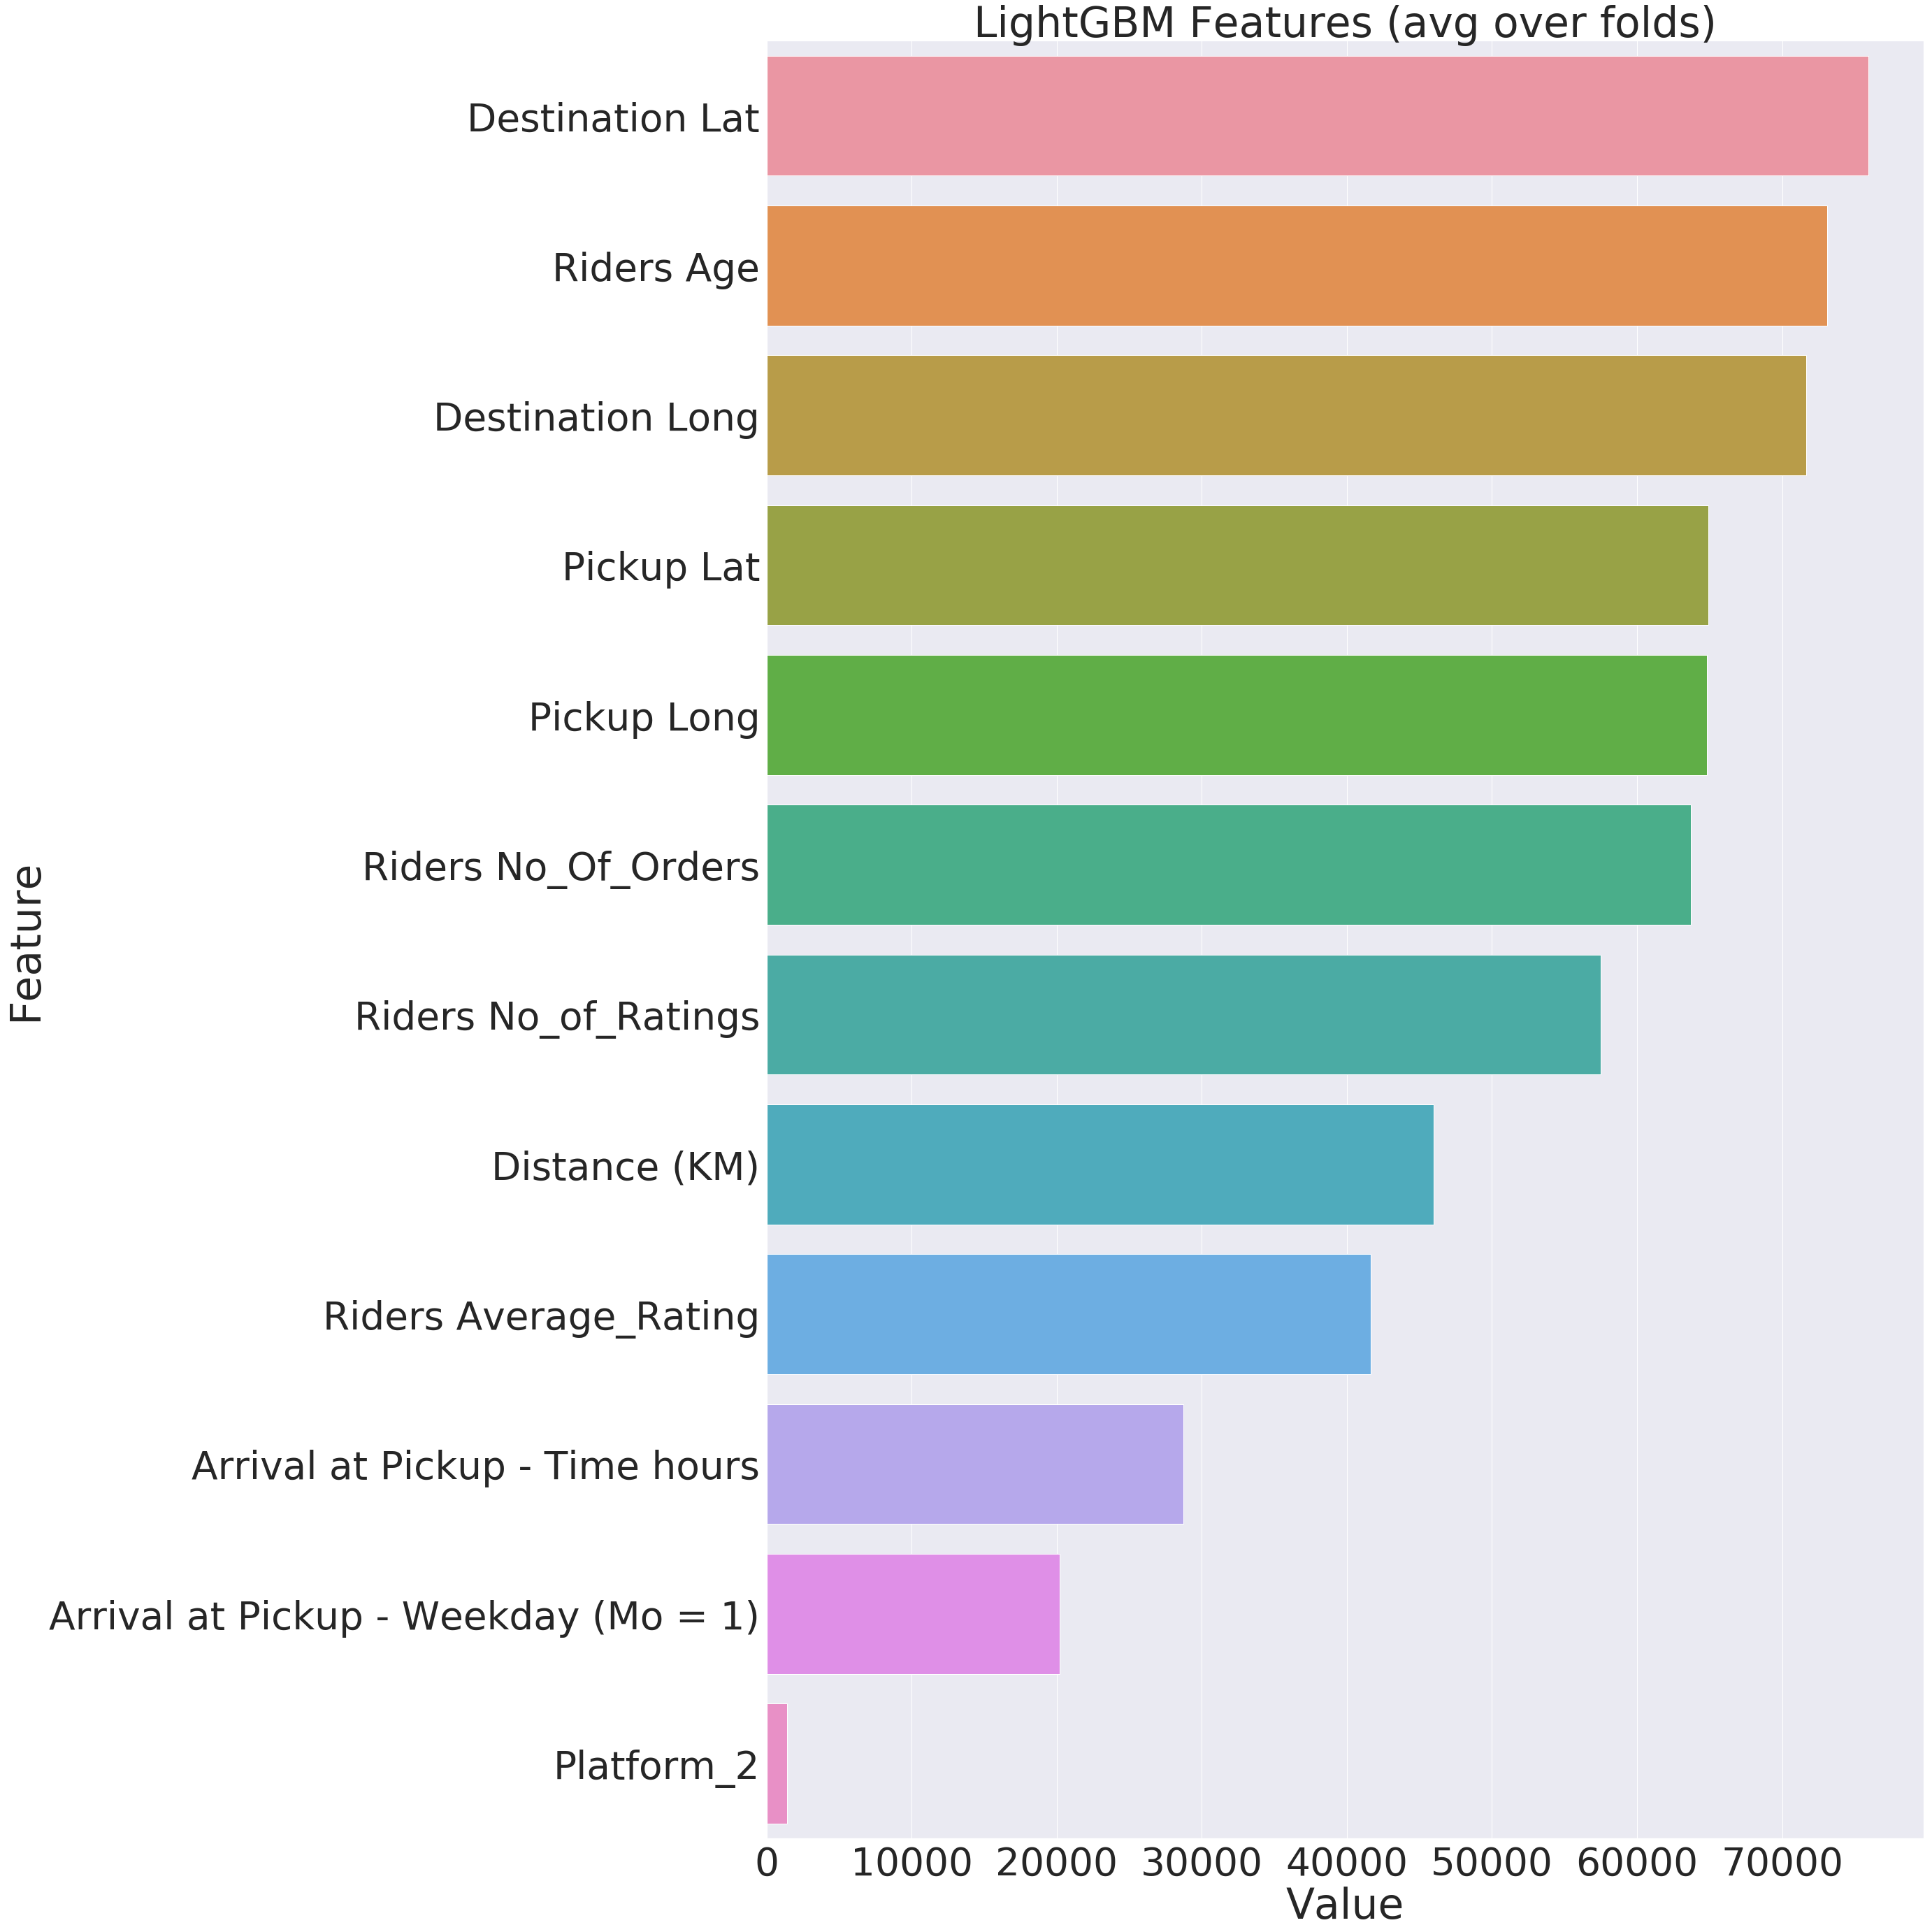

In [269]:
plotImp(lgbm_few_features, X_train[xgb_important_features[:12]], 50)

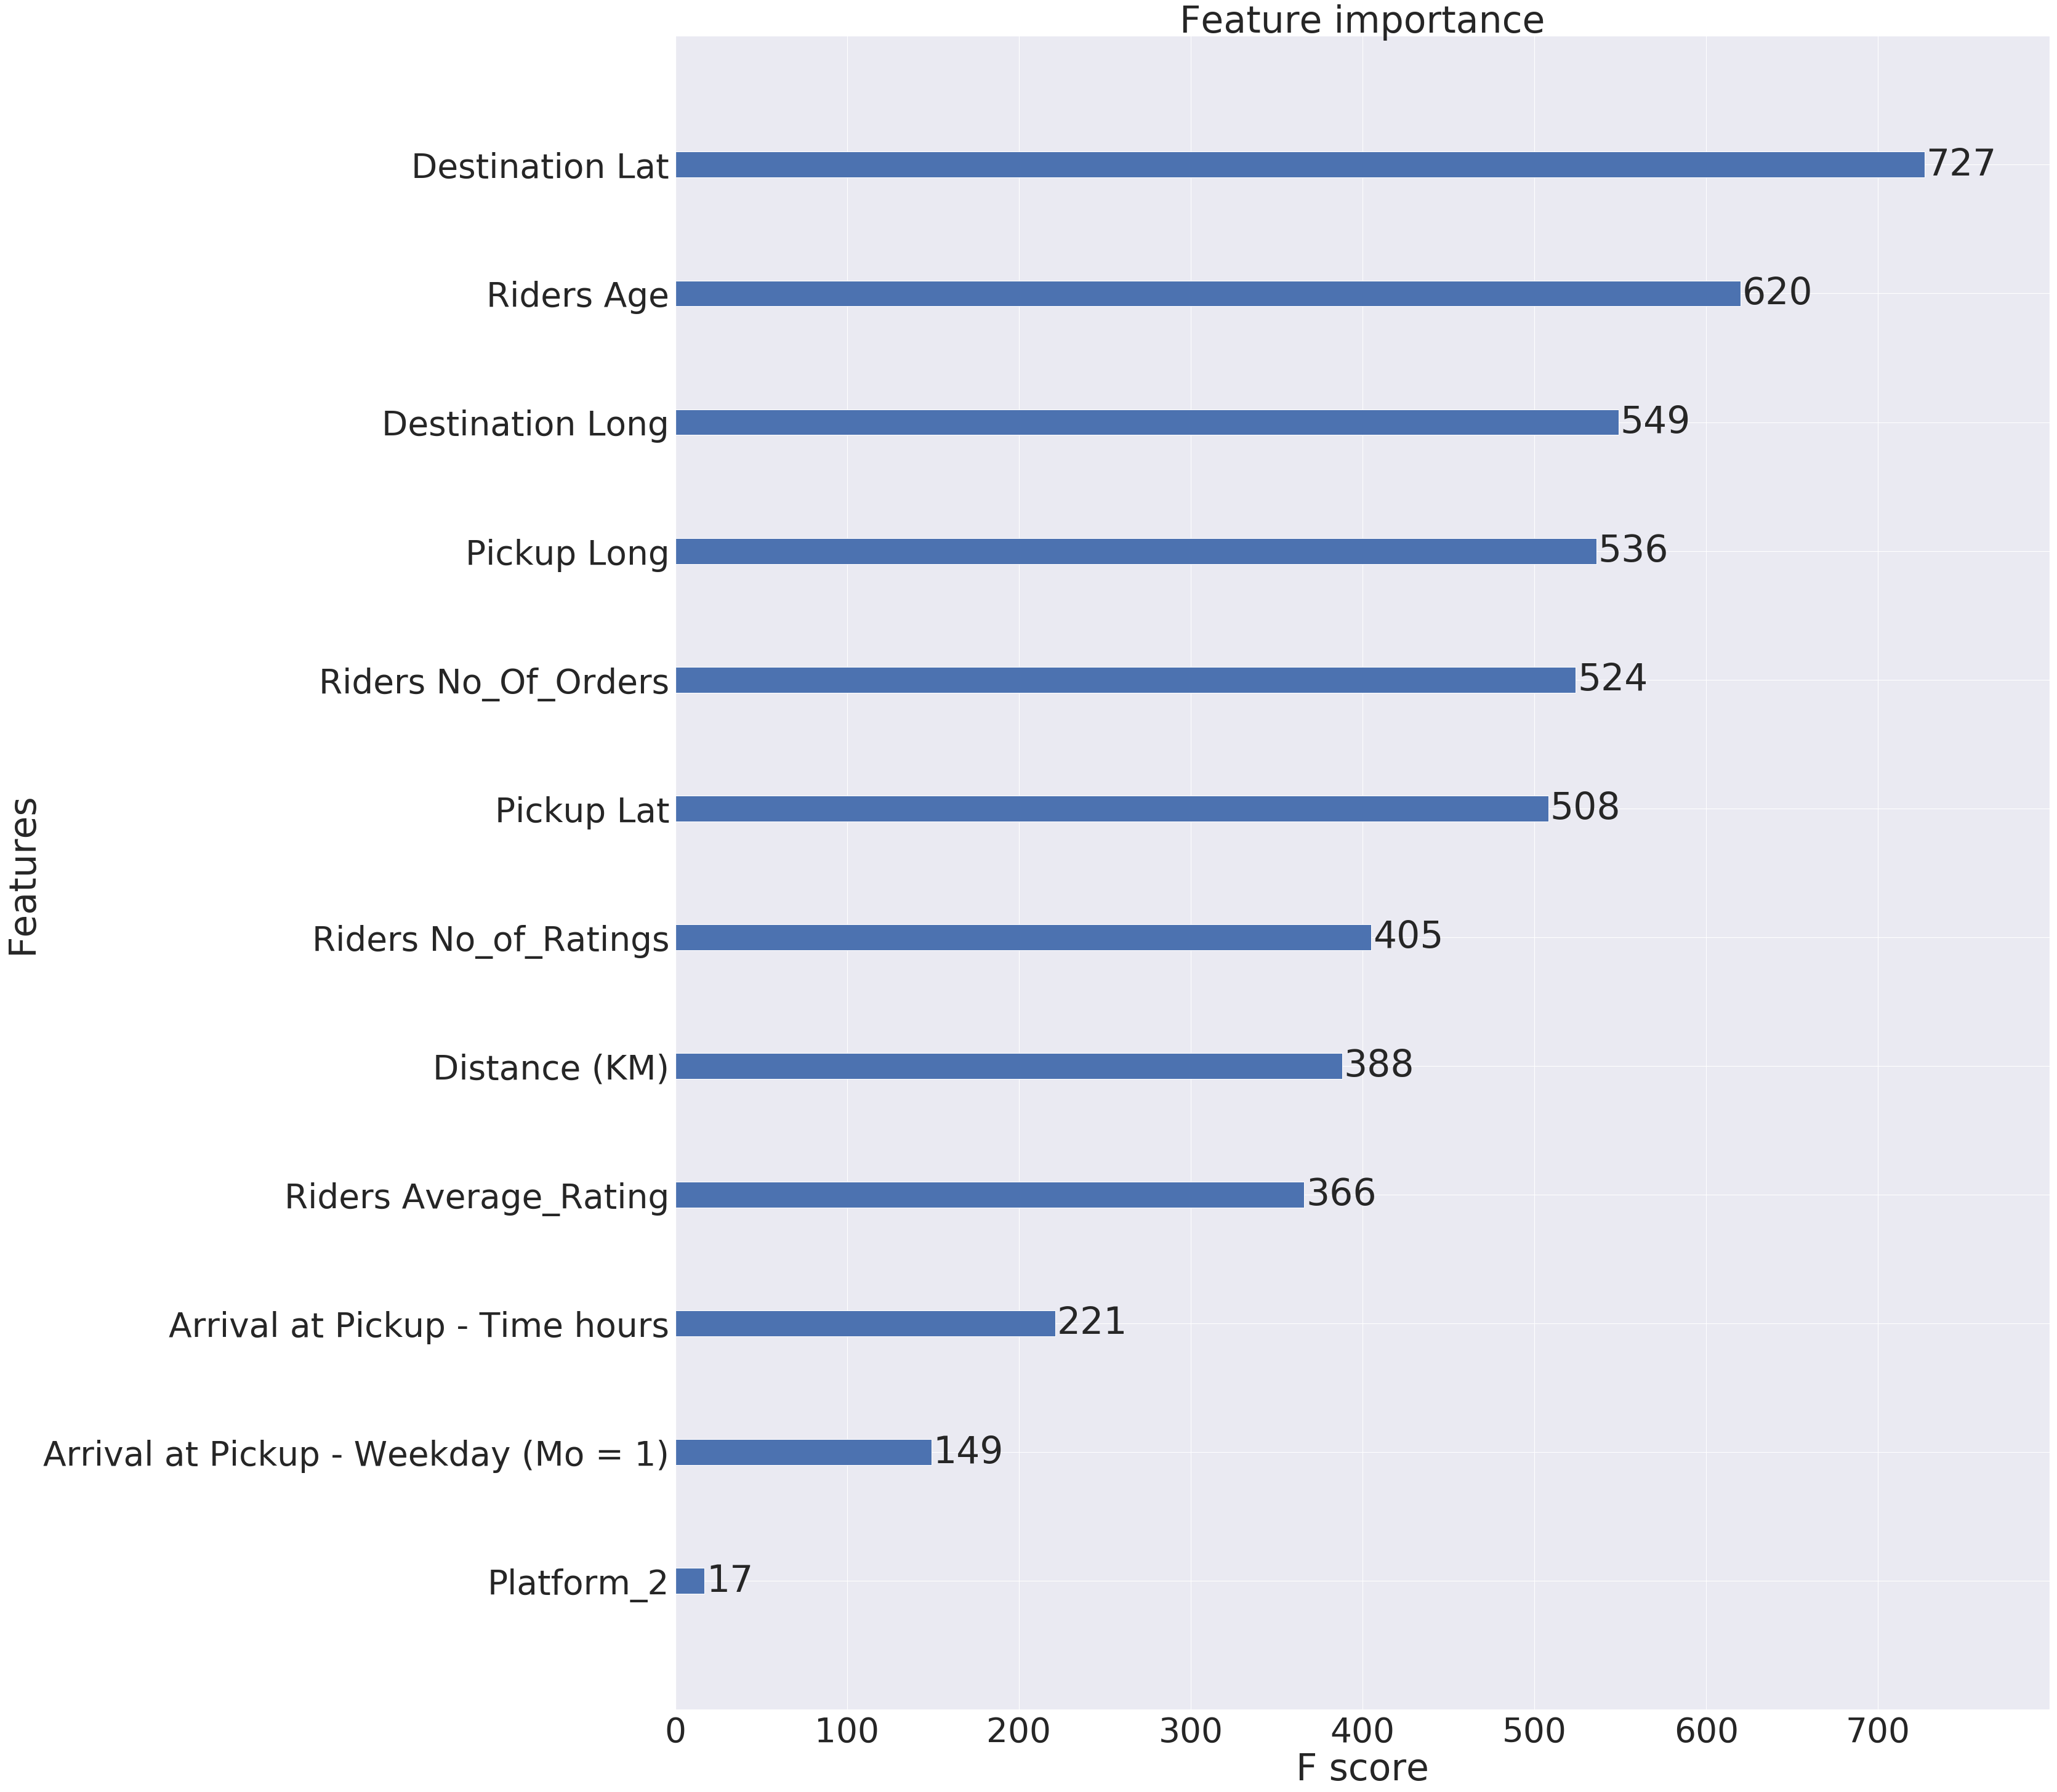

In [272]:
ax = plot_importance(xgb_few_features)
fig = ax.figure
fig.set_size_inches(40, 50)

In [274]:
xgb_important_features[:12]

['Distance (KM)',
 'Riders No_Of_Orders',
 'Platform_2',
 'Riders Average_Rating',
 'Riders Age',
 'Destination Lat',
 'Pickup Lat',
 'Riders No_of_Ratings',
 'Arrival at Pickup - Time hours',
 'Destination Long',
 'Pickup Long',
 'Arrival at Pickup - Weekday (Mo = 1)']